In [1]:
import scipy.stats as stats
import numpy as np
import scipy.optimize as optimize
import math
import matplotlib.pyplot as plt
import pandas as pd
import torch

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

log_plot = True

#Note: Need to normalize all values

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%%time
# Create synthetic data assuming the following values for theta
a_guess = np.array([-150,-75,-150,10, #A guess
                    0.5,0.5,-7,1, #a guess
                    -1, 1, 10, 1,#b guess
                    -8, -8, -8, 0,#c guess
                    0.5, 0.5, 0, 0,#x0 guess
                    0.5, 0.5, 0.5, 0.5]) #y0 guess
# a_guess = np.array([-1, 1, 10, 1]) #b guess

Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])

num_param_guess = int(len(a_guess)/Constants.shape[1])
##New Cell
# Evaluate model and add noise based on assumed theta values
# This generates experimental data points
exp_data_doc = "Input_CSVs/Exp_Data/n=30.csv"
exp_data = pd.read_csv(exp_data_doc, header=0,sep=",",index_col=0)
Num_params  = len(exp_data.T)
Xexp = np.array([exp_data.iloc[:,0:Num_params-1]])[0,:]
Yexp = np.array([exp_data.iloc[:,-1]])[0,:]
# print(Xexp)
print(a_guess[0])
print(Constants.shape)

-150.0
(6, 4)
CPU times: user 4.57 ms, sys: 956 µs, total: 5.53 ms
Wall time: 4.5 ms


/tmp/ipykernel_3413924/3587506400.py:34: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour3D(X1, X2, Y, 50, cmap='Reds', label = "True Model")


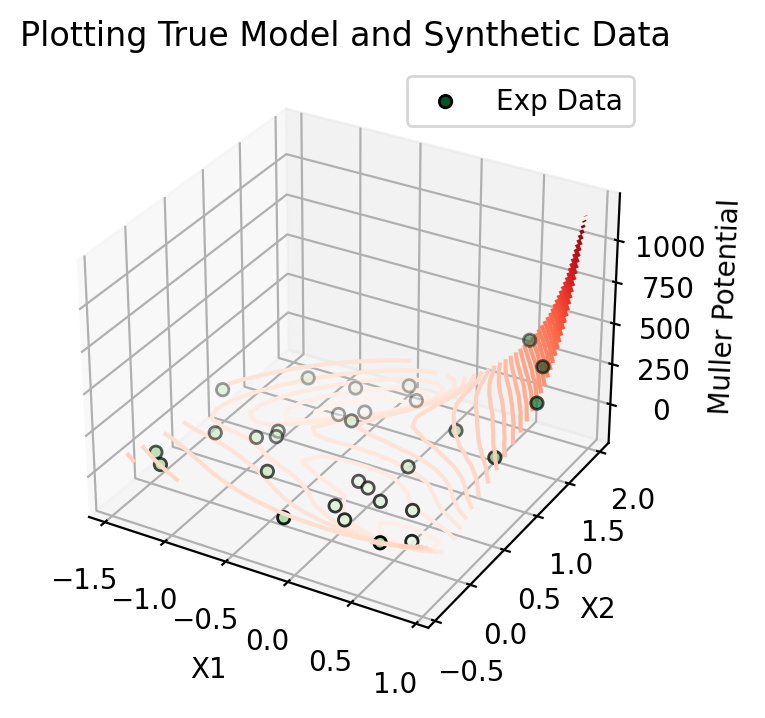

In [3]:
##New Cell

# Evaluate model based on the assumed experimental values
#Create Meshgrid for X1 and X2 and evaluate Y
len_mesh_data = 20
x1 = np.linspace(np.min(Xexp[:,0]),np.max(Xexp[:,0]),len_mesh_data)
x2 = np.linspace(np.min(Xexp[:,1]),np.max(Xexp[:,1]),len_mesh_data)
X1, X2 = np.meshgrid(x1,x2)
X_mesh = np.meshgrid(x1,x2)
# #Creates an array for Y that will be filled with the for loop
# #Initialize y_sim
Y = [] #len_data 

# #Find evey combination of X1/X2 to find the SSE for each combination
#Set constants
A, a, b, c, x0, y0 = Constants

#Calculate y_sim
#Define X1 and X2 (Need a better way do do this without for loops)
#Loop over combinations of X1 X2
for i in range(len_mesh_data):
    for j in range(len_mesh_data):
        Term1 = a*(X1[i,j] - x0)**2
        Term2 = b*(X1[i,j] - x0)*(X2[i,j] - y0)
        Term3 = c*(X2[i,j] - y0)**2
        Y.append( np.sum( A*np.exp(Term1 + Term2 + Term3) ) )
        
#Reshape to correct dimension (Is there an easier wat to do this?)        
Y = np.array(Y).reshape(len_mesh_data,-1)
# print(Y)
# Compare the experiments to the true model
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X1, X2, Y, 50, cmap='Reds', label = "True Model")
ax.scatter3D(Xexp[:,0], Xexp[:,1], Yexp, c=Yexp, cmap='Greens', label = "Exp Data", edgecolors = "k")
ax.legend() #Why won't this show both labels?
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Muller Potential');
plt.title("Plotting True Model and Synthetic Data")
plt.show()

# Y_scaled = np.array(Y_scaled).reshape(len_mesh_data,-1)
# Y_bounds = np.array([np.min(Y_scaled), np.max(Y_scaled)])
# Y = values_scaled_to_real(Y_scaled, Y_bounds)
# Y = Y.reshape(len_mesh_data,-1)

In [4]:
##New Cell

## define function that includes nonlinear model
def model(a_guess, Constants, x):
    '''
        """
    Creates Muller potential values given a guess for "a"
    Parameters
    ----------
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, Independent variable data (exp or pred)
    Returns
    -------
        y_model: ndarray, The simulated Muller potential given the guess
    '''
    #Assert statements check that the types defined in the doctring are satisfied
    
    #Converts parameters to numpy arrays if they are tensors
    if torch.is_tensor(a_guess)==True:
        a_guess = a_guess.numpy()
        
    if isinstance(a_guess, pd.DataFrame):
        a_guess = a_guess.to_numpy()
    
    #Initialize y_sim, set len_data and dim_x
    len_x_shape = len(x.shape) #Will tell us whether we're looking at Xexp or Xmesh
        
    if len_x_shape < 3:
        len_x_data = x.shape[0]
        y_model = np.zeros(len_x_data)
        
    else:
        len_x_data = x.shape[1]
        y_model = np.zeros((len_x_data, len_x_data))
    
    #Set dig out values of a from train_p
    #Set constants to change the a row to the index of the first loop
    Constants_local = np.copy(Constants)
    dim_guess = int(len(a_guess)/Constants.shape[1])
    a_guess = a_guess.reshape(dim_guess,-1)
    
    for i in range(dim_guess):
        Constants_local[i] = a_guess[i]#Since we've chosen A, a, b, c, x0, and y0
    
#     print(a_guess)
#     print(Constants_local)
    A, a, b, c, x0, y0 = Constants_local
#     print(a,A)

    #Iterates over Xexp to find the y for each combination
    for i in range(len_x_data):
        #Calculate y_sim
        if len_x_shape < 3:
            X1, X2 = x[i,0], x[i,1]
            Term1 = a*(X1 - x0)**2
            Term2 = b*(X1 - x0)*(X2 - y0)
            Term3 = c*(X2 - y0)**2
            y_model[i] = np.sum(A*np.exp(Term1 + Term2 + Term3) )
        else:
        #loop over all i and j
            X1, X2 = x
            for i in range(len_x_data):
                for j in range(len_x_data):
                    Term1 = a*(X1[i,j] - x0)**2
                    Term2 = b*(X1[i,j] - x0)*(X2[i,j] - y0)
                    Term3 = c*(X2[i,j] - y0)**2
                    y_model[i,j] = ( np.sum( A*np.exp(Term1 + Term2 + Term3) ) )
   
    if not len_x_shape < 3:
        y_model = y_model.reshape(len_x_data, -1)
    
    return y_model

# print(model(a_guess,Constants,Xexp))

##New Cell

# Create a function to optimize, in this case, least squares fitting
def regression_func(a_guess, Constants, x, y):
    '''
    Function to define regression function for least-squares fitting
    Arguments:
        a_guess: ndarray, guess value for a
        Constants: ndarray, The array containing the true values of Muller constants
        x: ndarray, experimental X data (Inependent Variable)
        y: ndarray, experimental Y data (Dependent Variable)
    Returns:
        e: residual vector
    '''
    
    error = y - model(a_guess, Constants, x); #NOTE: Least squares will calculate sse based off this to minimize
    
    return error

# print(regression_func(a_guess, Constants, Xexp, Yexp))


In [5]:

## specify initial guess
a0 = a_guess
#Define # of dimensions
try:
    d = a_guess.shape[0]*a_guess.shape[1]
except:
    d = a_guess.shape[0]
## specify bounds
# first array: lower bounds
# second array: upper bounds
lower = np.repeat(-np.inf, d)
upper = np.repeat(np.inf, d)
bounds = (lower, upper) 

## use least squares optimizer in scipy
# argument 1: function that takes theta as input, returns residual
# argument 2: initial guess for theta
# optional arguments 'bounds': bounds for theta
# optional arugment 'args': additional arguments to pass to residual function
# optional argument 'method': select the numerical method
#   if you want to consider bounds, choose 'trf'
#   if you do not want to consider bounds, try either 'lm' or 'trf'
Solution = optimize.least_squares(regression_func, a0 ,bounds=bounds, method='trf',args=(Constants, Xexp, Yexp),verbose=2)

a_model = Solution.x
a_model_soln = a_model.reshape(num_param_guess,-1)
print("a = ",a_model_soln)
print("Constants", Constants)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1387e+06                                    3.36e+06    
       1              6         2.8539e+05      8.53e+05       8.83e-01       8.66e+05    
       2              7         1.0386e+05      1.82e+05       1.77e+00       2.13e+05    
       3              8         7.5296e+04      2.86e+04       3.53e+00       5.53e+04    
       4              9         5.3781e+04      2.15e+04       3.53e+00       2.60e+04    
       5             12         4.4611e+04      9.17e+03       4.41e-01       4.36e+04    
       6             13         1.5556e+04      2.91e+04       8.83e-01       5.46e+04    
       7             15         1.1309e+04      4.25e+03       4.41e-01       2.86e+04    
       8             17         9.4134e+03      1.90e+03       1.10e-01       7.75e+03    
       9             18         9.2294e+03      1.84e+02       1.10e-01       6.41e+03    

/tmp/ipykernel_3413924/3391387112.py:59: RuntimeWarning: overflow encountered in exp
  y_model[i] = np.sum(A*np.exp(Term1 + Term2 + Term3) )


      14             23         8.6936e+03      1.66e+02       2.76e-02       1.92e+03    
      15             24         8.6624e+03      3.12e+01       2.76e-02       1.37e+03    
      16             25         8.6344e+03      2.81e+01       2.76e-02       1.01e+03    
      17             26         8.5800e+03      5.43e+01       5.52e-02       9.91e+02    
      18             27         8.4785e+03      1.01e+02       1.10e-01       1.76e+03    
      19             28         8.2829e+03      1.96e+02       2.21e-01       1.89e+03    
      20             29         7.9592e+03      3.24e+02       4.41e-01       4.61e+03    
      21             30         7.4021e+03      5.57e+02       8.83e-01       5.70e+03    
      22             34         7.3234e+03      7.87e+01       2.76e-02       7.88e+02    
      23             35         7.2971e+03      2.63e+01       2.76e-02       4.18e+02    
      24             36         7.2585e+03      3.86e+01       5.52e-02       7.73e+02    

      105            121        4.9399e+03      7.07e-01       6.90e-03       4.41e+02    
      106            122        4.9392e+03      7.26e-01       6.90e-03       4.35e+02    
      107            123        4.9385e+03      7.06e-01       6.90e-03       4.43e+02    
      108            124        4.9377e+03      7.25e-01       6.90e-03       4.37e+02    
      109            125        4.9370e+03      7.05e-01       6.90e-03       4.44e+02    
      110            126        4.9363e+03      7.24e-01       6.90e-03       4.38e+02    
      111            127        4.9356e+03      7.04e-01       6.90e-03       4.45e+02    
      112            128        4.9349e+03      7.23e-01       6.90e-03       4.39e+02    
      113            129        4.9342e+03      7.03e-01       6.90e-03       4.46e+02    
      114            130        4.9335e+03      7.22e-01       6.90e-03       4.40e+02    
      115            131        4.9328e+03      7.03e-01       6.90e-03       4.47e+02    

      196            212        4.8755e+03      7.15e-01       6.90e-03       4.53e+02    
      197            213        4.8748e+03      6.96e-01       6.90e-03       4.59e+02    
      198            214        4.8741e+03      7.15e-01       6.90e-03       4.54e+02    
      199            215        4.8734e+03      6.96e-01       6.90e-03       4.59e+02    
      200            216        4.8727e+03      7.15e-01       6.90e-03       4.54e+02    
      201            217        4.8720e+03      6.96e-01       6.90e-03       4.59e+02    
      202            218        4.8712e+03      7.15e-01       6.90e-03       4.54e+02    
      203            219        4.8705e+03      6.96e-01       6.90e-03       4.59e+02    
      204            220        4.8698e+03      7.15e-01       6.90e-03       4.54e+02    
      205            221        4.8691e+03      6.96e-01       6.90e-03       4.60e+02    
      206            222        4.8684e+03      7.15e-01       6.90e-03       4.54e+02    

      287            303        4.8112e+03      7.00e-01       6.90e-03       4.69e+02    
      288            304        4.8104e+03      7.19e-01       6.90e-03       4.64e+02    
      289            305        4.8097e+03      7.00e-01       6.90e-03       4.69e+02    
      290            306        4.8090e+03      7.19e-01       6.90e-03       4.64e+02    
      291            307        4.8083e+03      7.00e-01       6.90e-03       4.69e+02    
      292            308        4.8076e+03      7.19e-01       6.90e-03       4.64e+02    
      293            309        4.8069e+03      7.00e-01       6.90e-03       4.70e+02    
      294            310        4.8062e+03      7.19e-01       6.90e-03       4.64e+02    
      295            311        4.8055e+03      7.00e-01       6.90e-03       4.70e+02    
      296            312        4.8048e+03      7.19e-01       6.90e-03       4.65e+02    
      297            313        4.8041e+03      7.00e-01       6.90e-03       4.70e+02    

      392            408        4.7361e+03      7.31e-01       6.90e-03       4.76e+02    
      393            409        4.7354e+03      7.11e-01       6.90e-03       4.81e+02    
      394            410        4.7347e+03      7.31e-01       6.90e-03       4.76e+02    
      395            411        4.7340e+03      7.12e-01       6.90e-03       4.81e+02    
      396            412        4.7333e+03      7.31e-01       6.90e-03       4.76e+02    
      397            413        4.7325e+03      7.12e-01       6.90e-03       4.81e+02    
      398            414        4.7318e+03      7.32e-01       6.90e-03       4.76e+02    
      399            415        4.7311e+03      7.12e-01       6.90e-03       4.81e+02    
      400            416        4.7304e+03      7.32e-01       6.90e-03       4.76e+02    
      401            417        4.7297e+03      7.13e-01       6.90e-03       4.82e+02    
      402            418        4.7289e+03      7.32e-01       6.90e-03       4.77e+02    

      484            500        4.6691e+03      7.48e-01       6.90e-03       4.85e+02    
      485            501        4.6683e+03      7.28e-01       6.90e-03       4.90e+02    
      486            502        4.6676e+03      7.48e-01       6.90e-03       4.85e+02    
      487            503        4.6668e+03      7.29e-01       6.90e-03       4.91e+02    
      488            504        4.6661e+03      7.49e-01       6.90e-03       4.86e+02    
      489            505        4.6654e+03      7.29e-01       6.90e-03       4.91e+02    
      490            506        4.6646e+03      7.49e-01       6.90e-03       4.86e+02    
      491            507        4.6639e+03      7.30e-01       6.90e-03       4.91e+02    
      492            508        4.6631e+03      7.50e-01       6.90e-03       4.86e+02    
      493            509        4.6624e+03      7.30e-01       6.90e-03       4.91e+02    
      494            510        4.6617e+03      7.50e-01       6.90e-03       4.86e+02    

      575            591        4.6010e+03      7.48e-01       6.90e-03       5.01e+02    
      576            592        4.6002e+03      7.69e-01       6.90e-03       4.96e+02    
      577            593        4.5995e+03      7.48e-01       6.90e-03       5.01e+02    
      578            594        4.5987e+03      7.69e-01       6.90e-03       4.96e+02    
      579            595        4.5979e+03      7.49e-01       6.90e-03       5.01e+02    
      580            596        4.5972e+03      7.70e-01       6.90e-03       4.96e+02    
      581            597        4.5964e+03      7.49e-01       6.90e-03       5.02e+02    
      582            598        4.5957e+03      7.70e-01       6.90e-03       4.97e+02    
      583            599        4.5949e+03      7.50e-01       6.90e-03       5.02e+02    
      584            600        4.5941e+03      7.71e-01       6.90e-03       4.97e+02    
      585            601        4.5934e+03      7.50e-01       6.90e-03       5.02e+02    

      666            682        4.5310e+03      7.89e-01       6.90e-03       5.09e+02    
      667            683        4.5303e+03      7.67e-01       6.90e-03       5.14e+02    
      668            684        4.5295e+03      7.90e-01       6.90e-03       5.09e+02    
      669            685        4.5287e+03      7.68e-01       6.90e-03       5.15e+02    
      670            686        4.5279e+03      7.90e-01       6.90e-03       5.09e+02    
      671            687        4.5272e+03      7.68e-01       6.90e-03       5.15e+02    
      672            688        4.5264e+03      7.90e-01       6.90e-03       5.10e+02    
      673            689        4.5256e+03      7.68e-01       6.90e-03       5.15e+02    
      674            690        4.5248e+03      7.91e-01       6.90e-03       5.10e+02    
      675            691        4.5240e+03      7.69e-01       6.90e-03       5.16e+02    
      676            692        4.5232e+03      7.91e-01       6.90e-03       5.10e+02    

      771            787        4.4483e+03      7.84e-01       6.90e-03       5.34e+02    
      772            788        4.4475e+03      8.09e-01       6.90e-03       5.27e+02    
      773            789        4.4467e+03      7.84e-01       6.90e-03       5.34e+02    
      774            790        4.4459e+03      8.10e-01       6.90e-03       5.28e+02    
      775            791        4.4451e+03      7.84e-01       6.90e-03       5.34e+02    
      776            792        4.4443e+03      8.10e-01       6.90e-03       5.28e+02    
      777            793        4.4435e+03      7.85e-01       6.90e-03       5.35e+02    
      778            794        4.4427e+03      8.10e-01       6.90e-03       5.28e+02    
      779            795        4.4419e+03      7.85e-01       6.90e-03       5.35e+02    
      780            796        4.4411e+03      8.11e-01       6.90e-03       5.29e+02    
      781            797        4.4403e+03      7.85e-01       6.90e-03       5.36e+02    

      876            892        4.3640e+03      8.22e-01       6.90e-03       5.48e+02    
      877            893        4.3632e+03      7.92e-01       6.90e-03       5.56e+02    
      878            894        4.3624e+03      8.23e-01       6.90e-03       5.49e+02    
      879            895        4.3616e+03      7.92e-01       6.90e-03       5.57e+02    
      880            896        4.3608e+03      8.23e-01       6.90e-03       5.49e+02    
      881            897        4.3600e+03      7.93e-01       6.90e-03       5.57e+02    
      882            898        4.3592e+03      8.23e-01       6.90e-03       5.50e+02    
      883            899        4.3584e+03      7.93e-01       6.90e-03       5.58e+02    
      884            900        4.3575e+03      8.23e-01       6.90e-03       5.50e+02    
      885            901        4.3567e+03      7.93e-01       6.90e-03       5.58e+02    
      886            902        4.3559e+03      8.23e-01       6.90e-03       5.50e+02    

      982            998        4.2783e+03      8.27e-01       6.90e-03       5.71e+02    
      983            999        4.2775e+03      7.90e-01       6.90e-03       5.81e+02    
      984           1000        4.2767e+03      8.27e-01       6.90e-03       5.72e+02    
      985           1001        4.2759e+03      7.90e-01       6.90e-03       5.82e+02    
      986           1002        4.2750e+03      8.26e-01       6.90e-03       5.72e+02    
      987           1003        4.2742e+03      7.90e-01       6.90e-03       5.82e+02    
      988           1004        4.2734e+03      8.26e-01       6.90e-03       5.73e+02    
      989           1005        4.2726e+03      7.90e-01       6.90e-03       5.83e+02    
      990           1006        4.2718e+03      8.26e-01       6.90e-03       5.73e+02    
      991           1007        4.2710e+03      7.90e-01       6.90e-03       5.83e+02    
      992           1008        4.2702e+03      8.26e-01       6.90e-03       5.73e+02    

     1087           1103        4.1938e+03      7.78e-01       6.90e-03       6.06e+02    
     1088           1104        4.1930e+03      8.21e-01       6.90e-03       5.94e+02    
     1089           1105        4.1922e+03      7.78e-01       6.90e-03       6.06e+02    
     1090           1106        4.1914e+03      8.21e-01       6.90e-03       5.95e+02    
     1091           1107        4.1906e+03      7.78e-01       6.90e-03       6.07e+02    
     1092           1108        4.1898e+03      8.21e-01       6.90e-03       5.95e+02    
     1093           1109        4.1890e+03      7.77e-01       6.90e-03       6.07e+02    
     1094           1110        4.1882e+03      8.21e-01       6.90e-03       5.96e+02    
     1095           1111        4.1874e+03      7.77e-01       6.90e-03       6.08e+02    
     1096           1112        4.1866e+03      8.20e-01       6.90e-03       5.96e+02    
     1097           1113        4.1858e+03      7.76e-01       6.90e-03       6.08e+02    

     1192           1208        4.1106e+03      8.07e-01       6.90e-03       6.16e+02    
     1193           1209        4.1099e+03      7.57e-01       6.90e-03       6.30e+02    
     1194           1210        4.1091e+03      8.07e-01       6.90e-03       6.17e+02    
     1195           1211        4.1083e+03      7.56e-01       6.90e-03       6.31e+02    
     1196           1212        4.1075e+03      8.07e-01       6.90e-03       6.17e+02    
     1197           1213        4.1068e+03      7.56e-01       6.90e-03       6.31e+02    
     1198           1214        4.1060e+03      8.06e-01       6.90e-03       6.18e+02    
     1199           1215        4.1052e+03      7.55e-01       6.90e-03       6.32e+02    
     1200           1216        4.1044e+03      8.06e-01       6.90e-03       6.18e+02    
     1201           1217        4.1036e+03      7.55e-01       6.90e-03       6.32e+02    
     1202           1218        4.1028e+03      8.06e-01       6.90e-03       6.18e+02    

     1283           1299        4.0404e+03      7.34e-01       6.90e-03       6.50e+02    
     1284           1300        4.0396e+03      7.90e-01       6.90e-03       6.35e+02    
     1285           1301        4.0389e+03      7.33e-01       6.90e-03       6.50e+02    
     1286           1302        4.0381e+03      7.89e-01       6.90e-03       6.35e+02    
     1287           1303        4.0374e+03      7.33e-01       6.90e-03       6.51e+02    
     1288           1304        4.0366e+03      7.89e-01       6.90e-03       6.35e+02    
     1289           1305        4.0358e+03      7.32e-01       6.90e-03       6.51e+02    
     1290           1306        4.0350e+03      7.89e-01       6.90e-03       6.36e+02    
     1291           1307        4.0343e+03      7.31e-01       6.90e-03       6.51e+02    
     1292           1308        4.0335e+03      7.88e-01       6.90e-03       6.36e+02    
     1293           1309        4.0328e+03      7.31e-01       6.90e-03       6.52e+02    

     1388           1404        3.9618e+03      7.66e-01       6.90e-03       6.54e+02    
     1389           1405        3.9611e+03      7.03e-01       6.90e-03       6.71e+02    
     1390           1406        3.9603e+03      7.65e-01       6.90e-03       6.54e+02    
     1391           1407        3.9596e+03      7.02e-01       6.90e-03       6.71e+02    
     1392           1408        3.9589e+03      7.65e-01       6.90e-03       6.54e+02    
     1393           1409        3.9582e+03      7.02e-01       6.90e-03       6.71e+02    
     1394           1410        3.9574e+03      7.64e-01       6.90e-03       6.55e+02    
     1395           1411        3.9567e+03      7.01e-01       6.90e-03       6.72e+02    
     1396           1412        3.9559e+03      7.64e-01       6.90e-03       6.55e+02    
     1397           1413        3.9552e+03      7.00e-01       6.90e-03       6.72e+02    
     1398           1414        3.9545e+03      7.64e-01       6.90e-03       6.55e+02    

     1479           1495        3.8961e+03      6.75e-01       6.90e-03       6.87e+02    
     1480           1496        3.8954e+03      7.43e-01       6.90e-03       6.69e+02    
     1481           1497        3.8947e+03      6.75e-01       6.90e-03       6.87e+02    
     1482           1498        3.8940e+03      7.42e-01       6.90e-03       6.69e+02    
     1483           1499        3.8933e+03      6.74e-01       6.90e-03       6.87e+02    
     1484           1500        3.8926e+03      7.42e-01       6.90e-03       6.70e+02    
     1485           1501        3.8919e+03      6.73e-01       6.90e-03       6.88e+02    
     1486           1502        3.8912e+03      7.41e-01       6.90e-03       6.70e+02    
     1487           1503        3.8905e+03      6.73e-01       6.90e-03       6.88e+02    
     1488           1504        3.8897e+03      7.41e-01       6.90e-03       6.70e+02    
     1489           1505        3.8891e+03      6.72e-01       6.90e-03       6.88e+02    

     1571           1588        3.7935e+03      2.11e-01       1.38e-02       1.46e+03    
     1572           1589        3.7904e+03      3.17e+00       3.45e-03       3.52e+02    
     1573           1590        3.7895e+03      8.60e-01       6.90e-03       4.23e+02    
     1574           1591        3.7887e+03      7.83e-01       6.90e-03       4.82e+02    
     1575           1592        3.7880e+03      7.59e-01       6.90e-03       5.29e+02    
     1576           1593        3.7873e+03      6.93e-01       6.90e-03       5.88e+02    
     1577           1594        3.7866e+03      7.05e-01       6.90e-03       6.15e+02    
     1578           1595        3.7859e+03      6.45e-01       6.90e-03       6.58e+02    
     1579           1596        3.7852e+03      6.93e-01       6.90e-03       6.62e+02    
     1580           1597        3.7846e+03      6.32e-01       6.90e-03       6.92e+02    
     1581           1598        3.7839e+03      6.96e-01       6.90e-03       6.81e+02    

     1676           1699        3.4970e+03      6.03e-01       6.90e-03       6.87e+02    
     1677           1700        3.4964e+03      6.12e-01       6.90e-03       6.85e+02    
     1678           1701        3.4958e+03      5.44e-01       6.90e-03       7.20e+02    
     1679           1702        3.4950e+03      8.01e-01       1.72e-03       1.73e+02    
     1680           1703        3.4946e+03      4.35e-01       3.45e-03       1.58e+02    
     1681           1704        3.4938e+03      8.49e-01       6.90e-03       1.85e+02    
     1682           1705        3.4921e+03      1.69e+00       1.38e-02       2.64e+02    
     1683           1706        3.4888e+03      3.25e+00       2.76e-02       4.46e+02    
     1684           1707        3.4827e+03      6.15e+00       5.52e-02       8.10e+02    
     1685           1708        3.4727e+03      9.98e+00       1.10e-01       1.64e+03    
     1686           1709        3.4714e+03      1.23e+00       1.10e-01       3.10e+03    

     1767           1796        3.2463e+03      1.52e+00       1.38e-02       1.09e+02    
     1768           1797        3.2433e+03      3.03e+00       2.76e-02       1.66e+02    
     1769           1798        3.2373e+03      5.96e+00       5.52e-02       3.02e+02    
     1770           1799        3.2257e+03      1.16e+01       1.10e-01       5.93e+02    
     1771           1800        3.2042e+03      2.15e+01       2.21e-01       1.24e+03    
     1772           1801        3.1683e+03      3.58e+01       4.41e-01       2.81e+03    
     1773           1805        3.1568e+03      1.15e+01       6.90e-03       5.24e+02    
     1774           1806        3.1560e+03      7.83e-01       6.90e-03       6.13e+02    
     1775           1807        3.1553e+03      7.22e-01       6.90e-03       5.75e+02    
     1776           1808        3.1547e+03      5.66e-01       6.90e-03       6.28e+02    
     1777           1809        3.1541e+03      5.92e-01       6.90e-03       6.28e+02    

     1858           1899        2.5225e+03      4.59e+00       5.52e-02       1.49e+02    
     1859           1900        2.5134e+03      9.08e+00       1.10e-01       2.27e+02    
     1860           1901        2.4956e+03      1.78e+01       2.21e-01       4.13e+02    
     1861           1902        2.4607e+03      3.49e+01       4.41e-01       9.32e+02    
     1862           1903        2.3964e+03      6.43e+01       8.83e-01       1.87e+03    
     1863           1904        2.2928e+03      1.04e+02       1.77e+00       1.06e+04    
     1864           1908        2.2807e+03      1.21e+01       2.76e-02       3.93e+03    
     1865           1909        2.2629e+03      1.78e+01       6.90e-03       1.23e+03    
     1866           1910        2.2603e+03      2.61e+00       1.38e-02       1.27e+03    
     1867           1911        2.2587e+03      1.62e+00       1.38e-02       1.29e+03    
     1868           1912        2.2564e+03      2.31e+00       3.45e-03       1.27e+02    

     1955           2015        4.7756e+02      1.12e+01       4.41e-01       1.64e+02    
     1956           2016        4.5597e+02      2.16e+01       8.83e-01       5.61e+02    
     1957           2017        4.2833e+02      2.76e+01       1.77e+00       1.30e+03    
     1958           2018        4.2350e+02      4.82e+00       1.77e+00       1.40e+03    
     1959           2019        3.9100e+02      3.25e+01       4.41e-01       1.45e+03    
     1960           2020        3.7219e+02      1.88e+01       8.83e-01       9.54e+02    
     1961           2021        3.4869e+02      2.35e+01       1.77e+00       2.42e+03    
     1962           2022        3.3952e+02      9.17e+00       3.53e+00       2.82e+04    
     1963           2023        3.2443e+02      1.51e+01       8.83e-01       1.16e+04    
     1964           2024        3.0298e+02      2.15e+01       8.83e-01       4.54e+03    
     1965           2026        2.9823e+02      4.74e+00       4.41e-01       7.39e+02    

     2048           2129        1.1572e+02      6.88e-01       3.53e+00       2.34e+03    
     2049           2130        1.1518e+02      5.37e-01       7.06e+00       5.90e+03    
     2050           2131        1.1391e+02      1.27e+00       7.06e+00       5.03e+03    
     2051           2133        1.1326e+02      6.52e-01       3.53e+00       1.49e+03    
     2052           2134        1.1292e+02      3.40e-01       7.06e+00       3.32e+03    
     2053           2135        1.1226e+02      6.65e-01       7.06e+00       2.81e+03    
     2054           2137        1.1197e+02      2.88e-01       3.53e+00       8.27e+02    
     2055           2138        1.1167e+02      3.00e-01       7.06e+00       2.19e+03    
     2056           2139        1.1127e+02      4.03e-01       7.06e+00       1.94e+03    
     2057           2141        1.1107e+02      2.00e-01       3.53e+00       5.78e+02    
     2058           2142        1.1080e+02      2.67e-01       7.06e+00       1.63e+03    

     2140           2238        8.5261e+01      1.73e-01       4.52e+02       1.46e+04    
     2141           2239        8.5100e+01      1.61e-01       4.52e+02       1.36e+04    
     2142           2240        8.4950e+01      1.51e-01       4.52e+02       1.27e+04    
     2143           2241        8.4808e+01      1.41e-01       4.52e+02       1.20e+04    
     2144           2242        8.4675e+01      1.34e-01       4.52e+02       1.13e+04    
     2145           2243        8.4549e+01      1.26e-01       4.52e+02       1.06e+04    
     2146           2244        8.4429e+01      1.20e-01       4.52e+02       1.00e+04    
     2147           2246        8.4341e+01      8.80e-02       2.26e+02       2.63e+03    
     2148           2247        8.4258e+01      8.31e-02       4.52e+02       8.83e+03    
     2149           2248        8.4154e+01      1.04e-01       4.52e+02       8.72e+03    
     2150           2250        8.4081e+01      7.30e-02       2.26e+02       2.31e+03    

     2235           2352        7.9056e+01      4.76e-02       3.62e+03       1.41e+04    
     2236           2353        7.9010e+01      4.61e-02       3.62e+03       1.33e+04    
     2237           2354        7.8966e+01      4.42e-02       3.62e+03       1.27e+04    
     2238           2355        7.8924e+01      4.27e-02       3.62e+03       1.22e+04    
     2239           2357        7.8891e+01      3.25e-02       1.81e+03       3.06e+03    
     2240           2358        7.8862e+01      2.90e-02       3.62e+03       1.12e+04    
     2241           2359        7.8823e+01      3.89e-02       3.62e+03       1.08e+04    
     2242           2361        7.8795e+01      2.82e-02       1.81e+03       2.75e+03    
     2243           2362        7.8767e+01      2.83e-02       3.62e+03       1.01e+04    
     2244           2364        7.8741e+01      2.60e-02       1.81e+03       2.55e+03    
     2245           2365        7.8713e+01      2.78e-02       3.62e+03       9.52e+03    

In [6]:
def sse_func(a_model, x, y, P_inds, P1_vals, P2_vals):
    '''
    Function to define define sum of squared error function for heat map
    Arguments:
        xx: An N X D array of all a_1 values
        yy: An D X N array of all a_2 values
        x: independent variable vector (predicted x values including noise)
        y: dependent variable vector (predicted y values on Heat Map)
    Returns:
        sse: N x N sum of squared error matrix of all generated combination of xx and yy
    '''
    #Meshgrid
    P1_mesh, P2_mesh = np.meshgrid(P1_vals,P2_vals)
    #Copy Center Point
    a_guess_local = np.copy(a_model)
    
    #Initialize SSE Maxtrix
    sse = np.zeros((len(P1_mesh),len(P2_mesh)))
    
    #Calculate SSE
    for i in range(len(P1_mesh)):
        for j in range(len(P2_mesh)):
            a_guess_local[P_inds[0]] = P1_mesh[i,j]
            a_guess_local[P_inds[1]] = P2_mesh[i,j]
#             print(a_guess_local)
            sse[i,j] = sum((y - model(a_guess_local, Constants, x))**2) 
    
    return sse

In [7]:
# a1, a2, a3, a4 = np.meshgrid(a1_lin, a2_lin, a3_lin, a4_lin)
# a_guesses = np.meshgrid(a1_lin, a2_lin, a3_lin, a4_lin)

# P_inds = np.array([0,3])
# print(sse_func(a_model, Xexp, Yexp, P_inds, a1_lin, a2_lin))

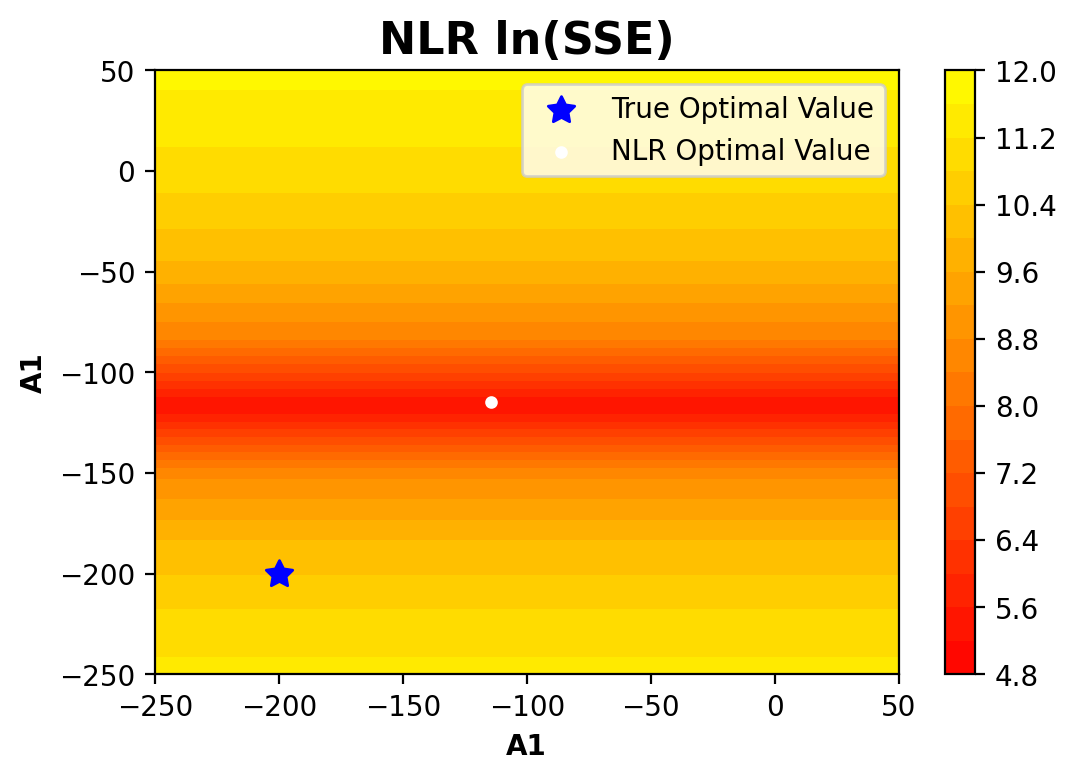

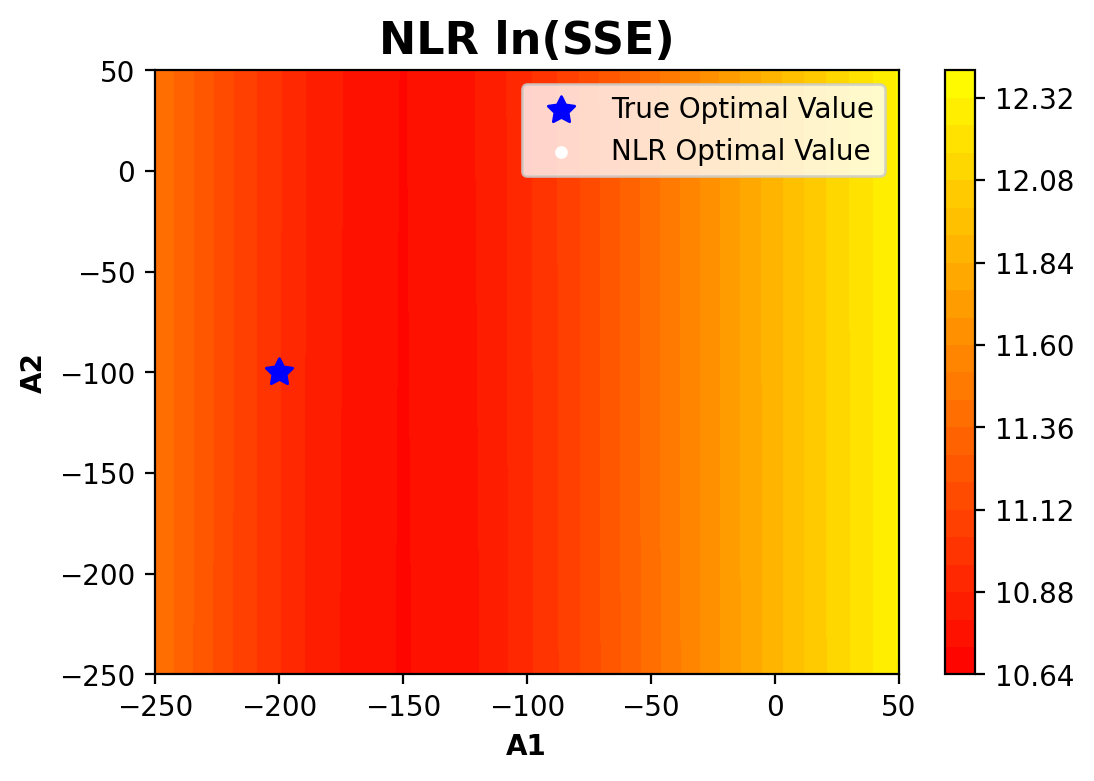

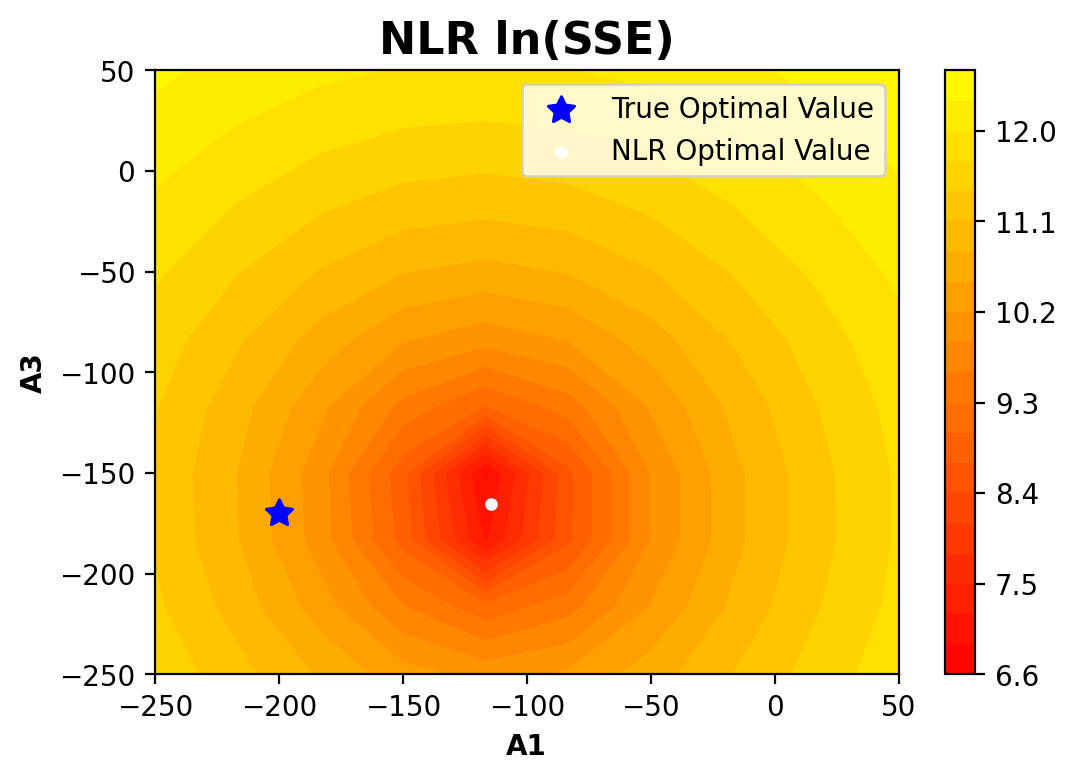

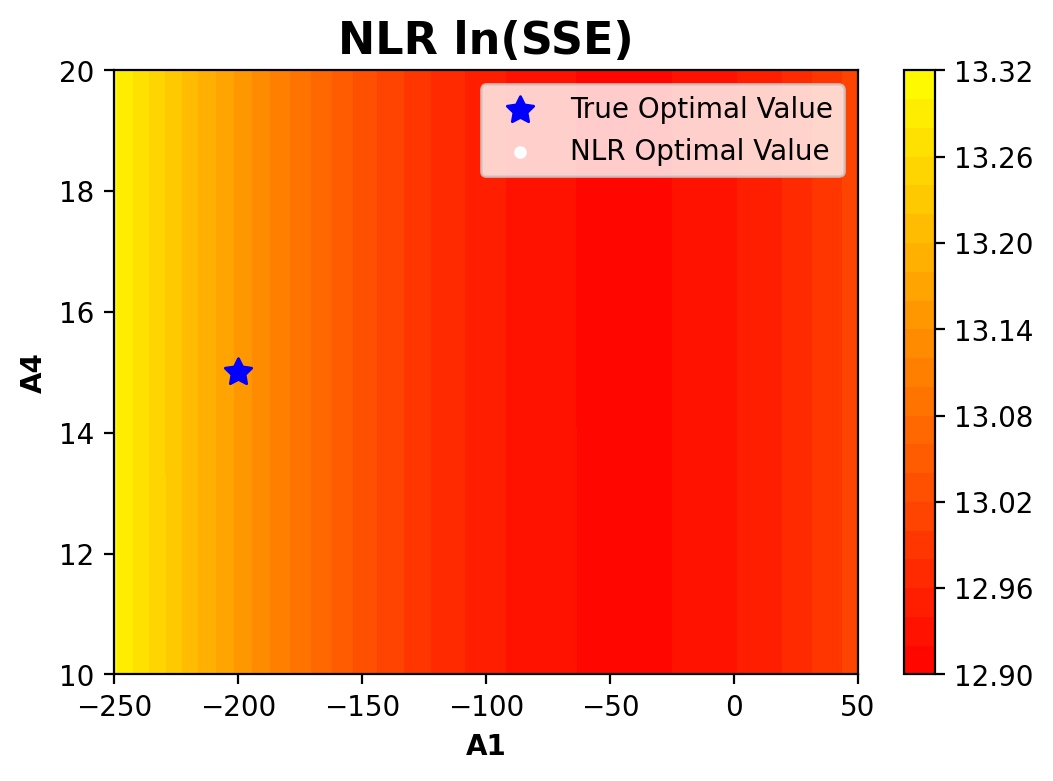

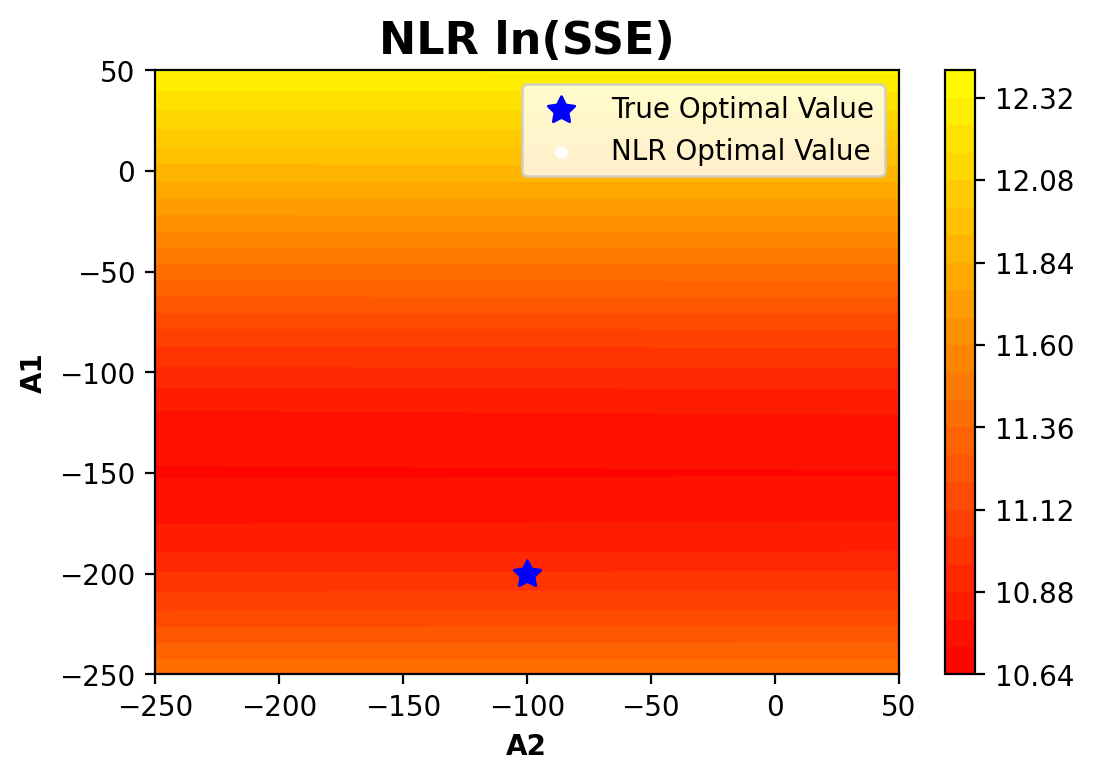

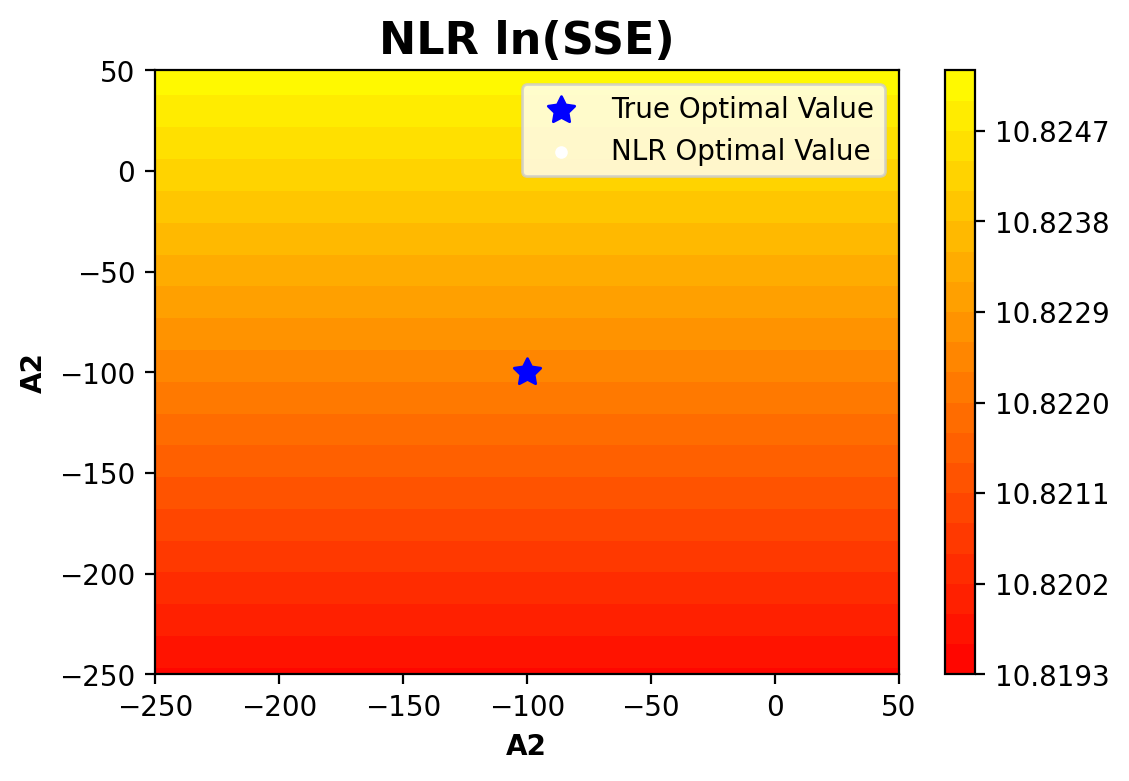

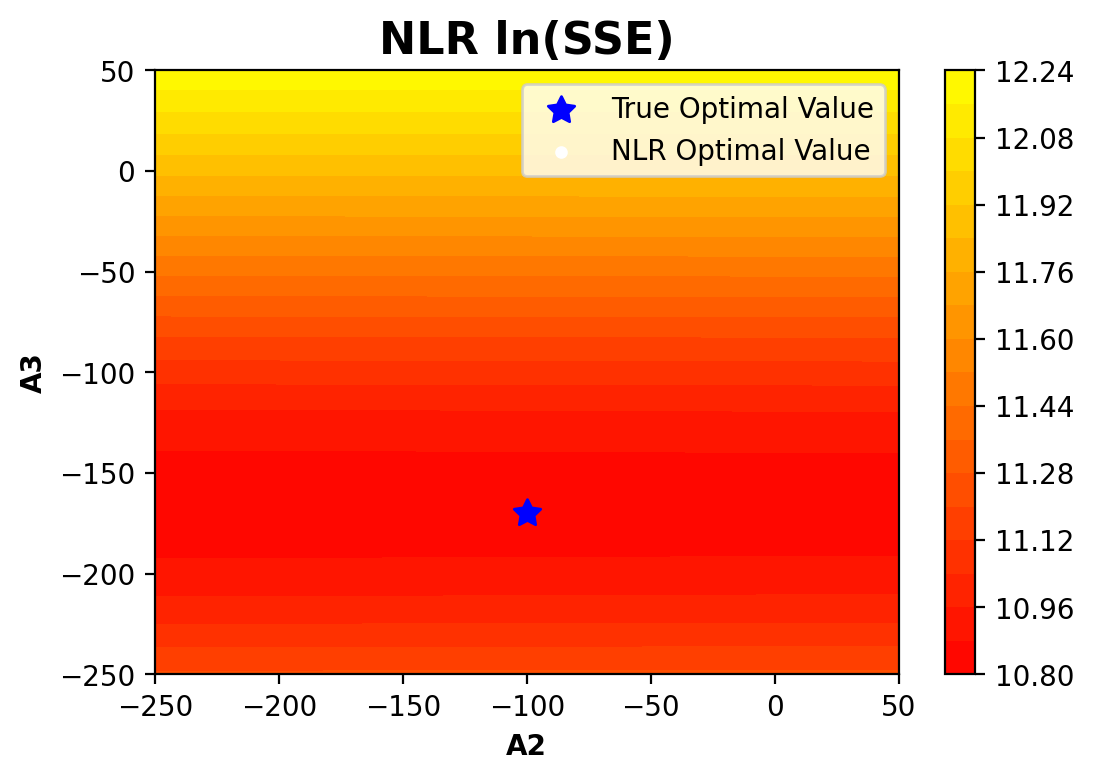

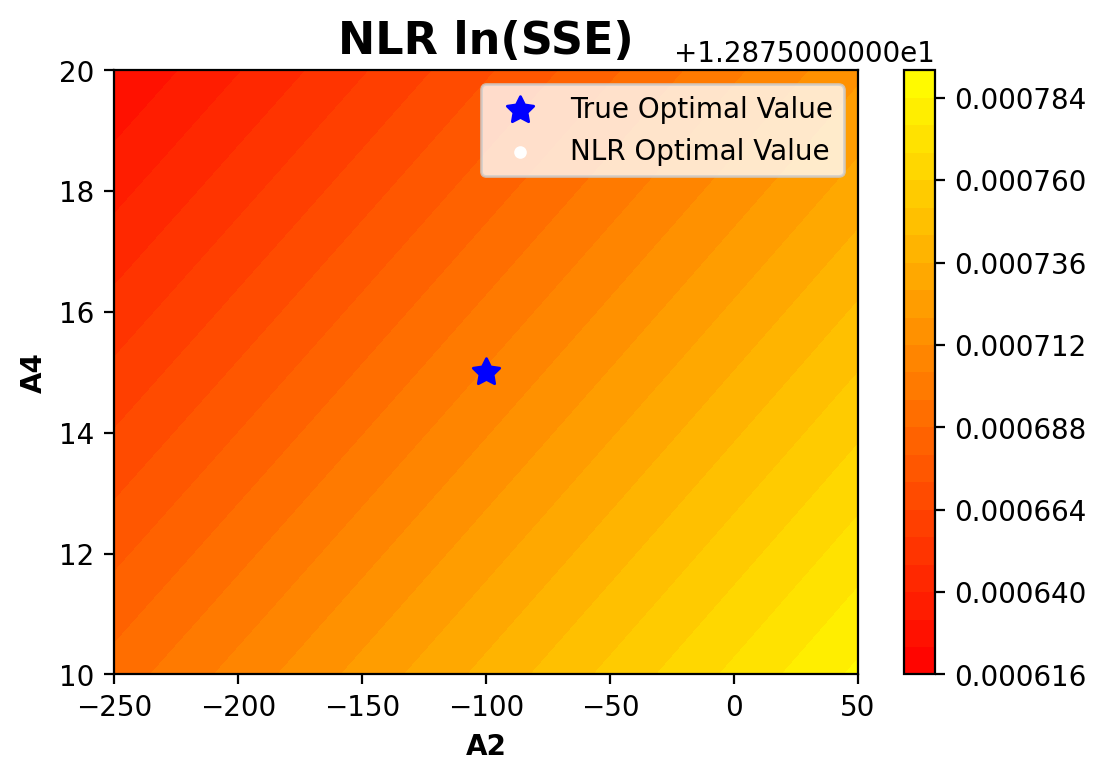

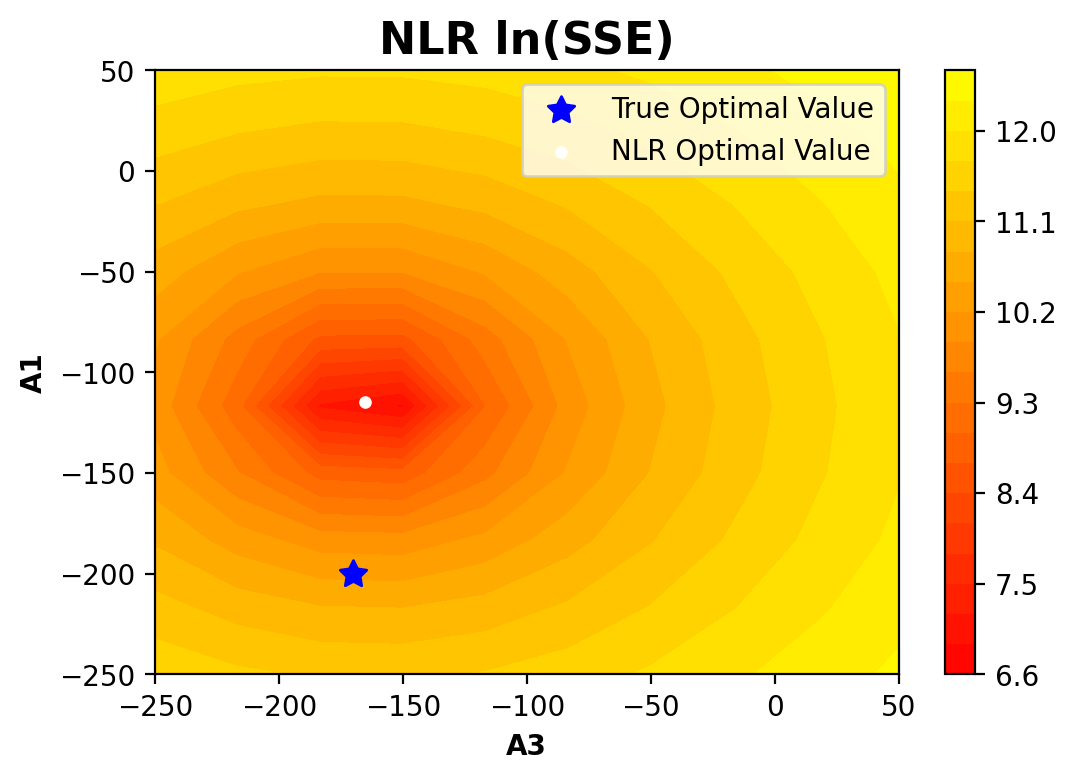

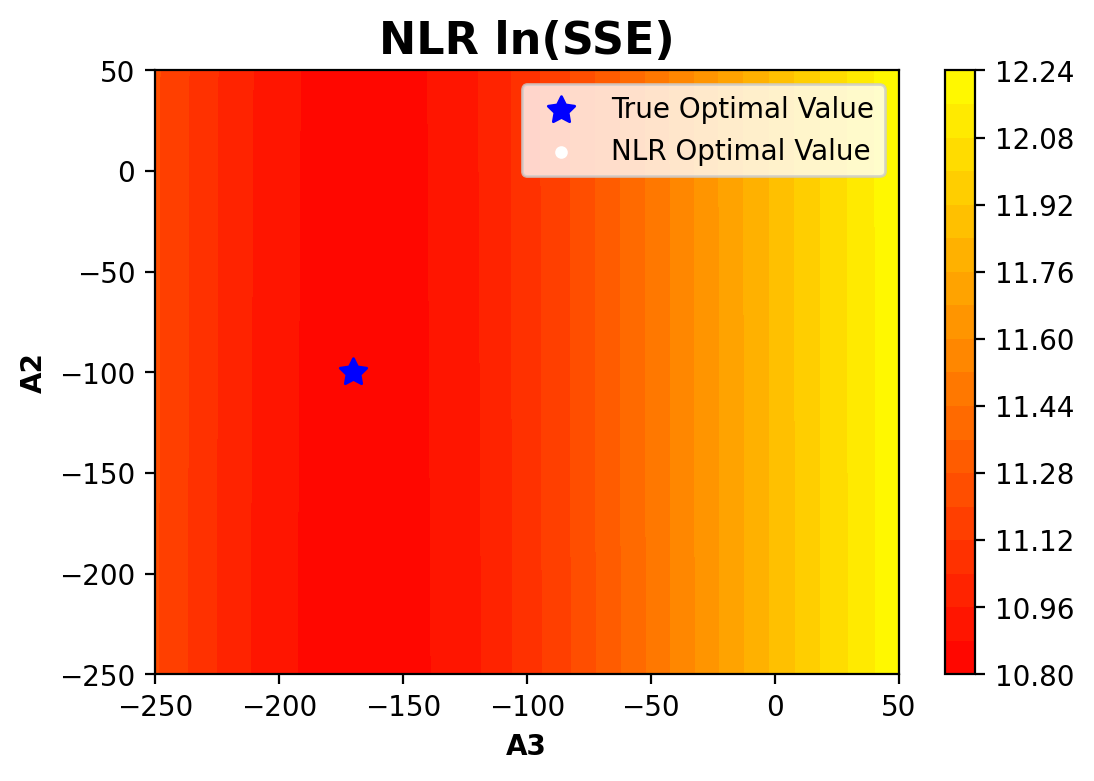

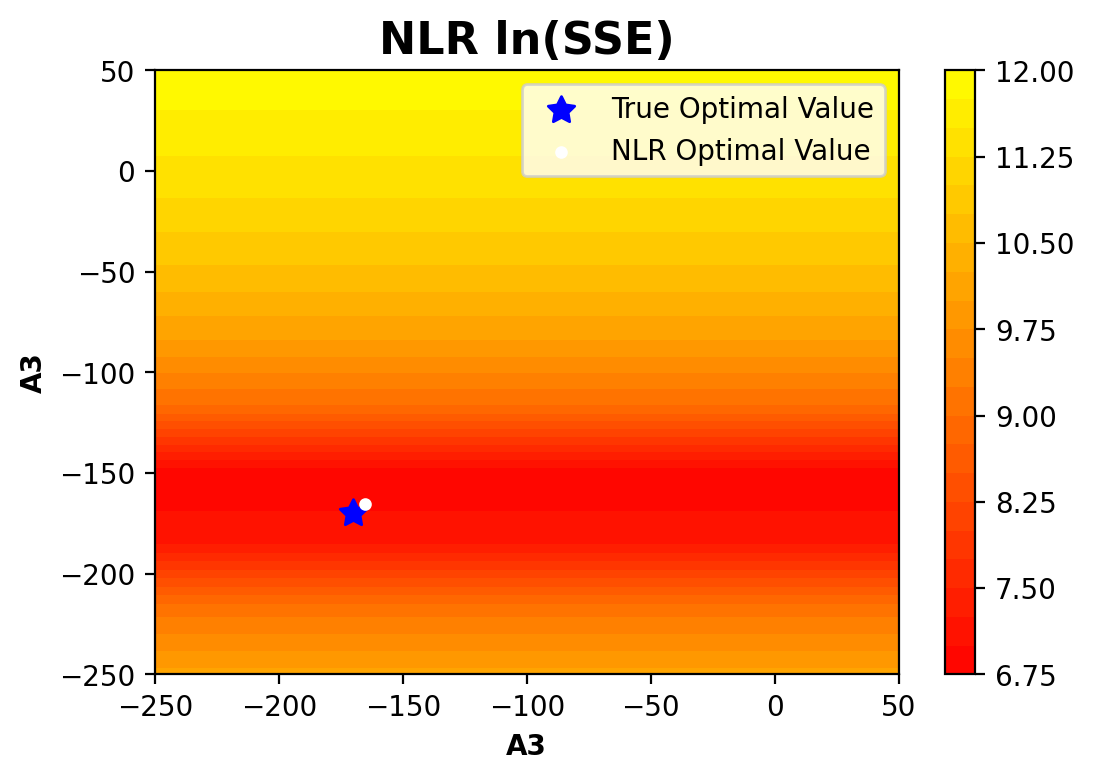

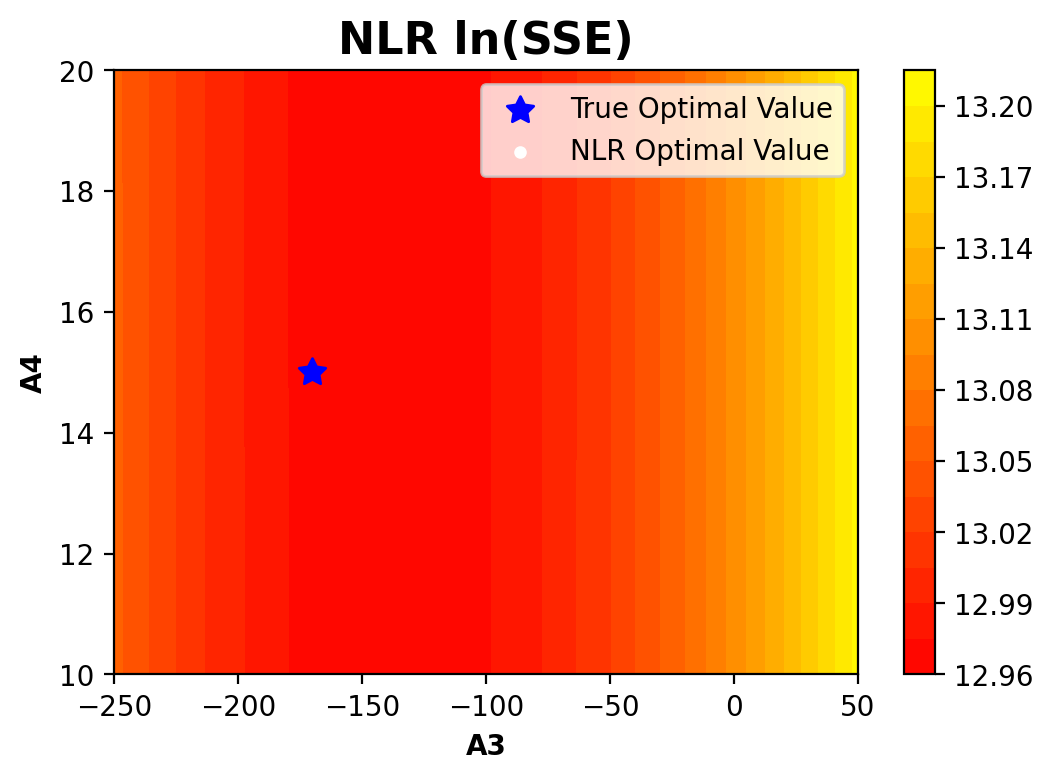

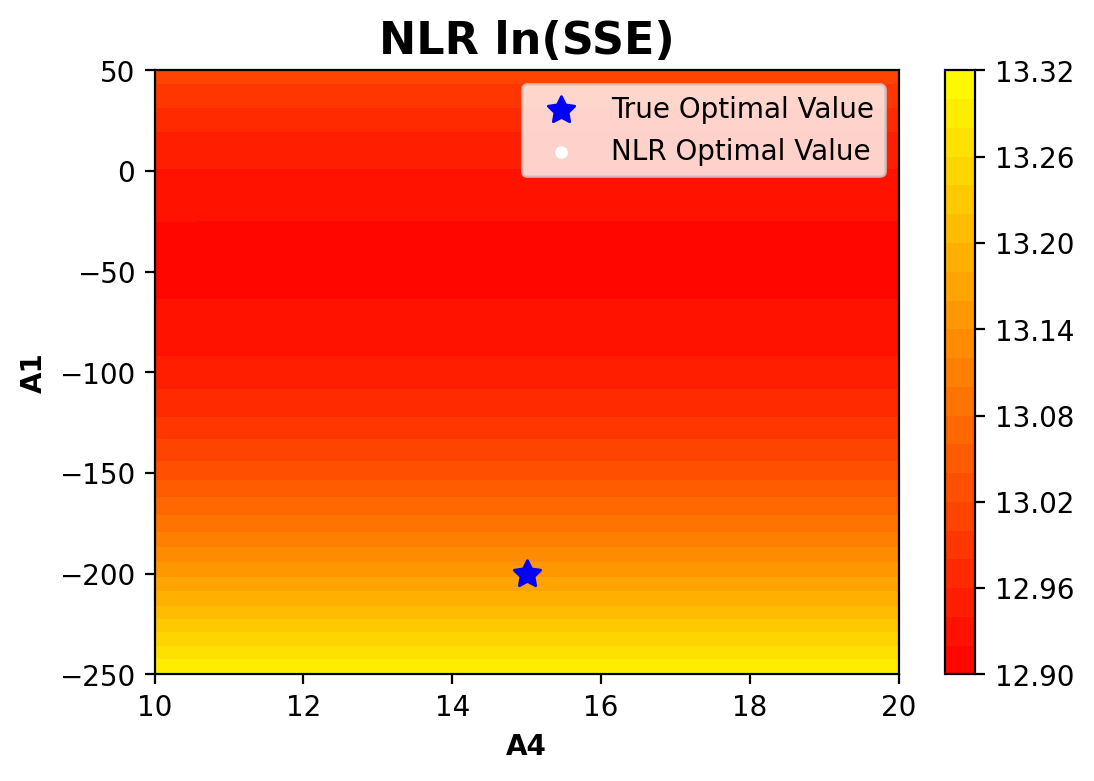

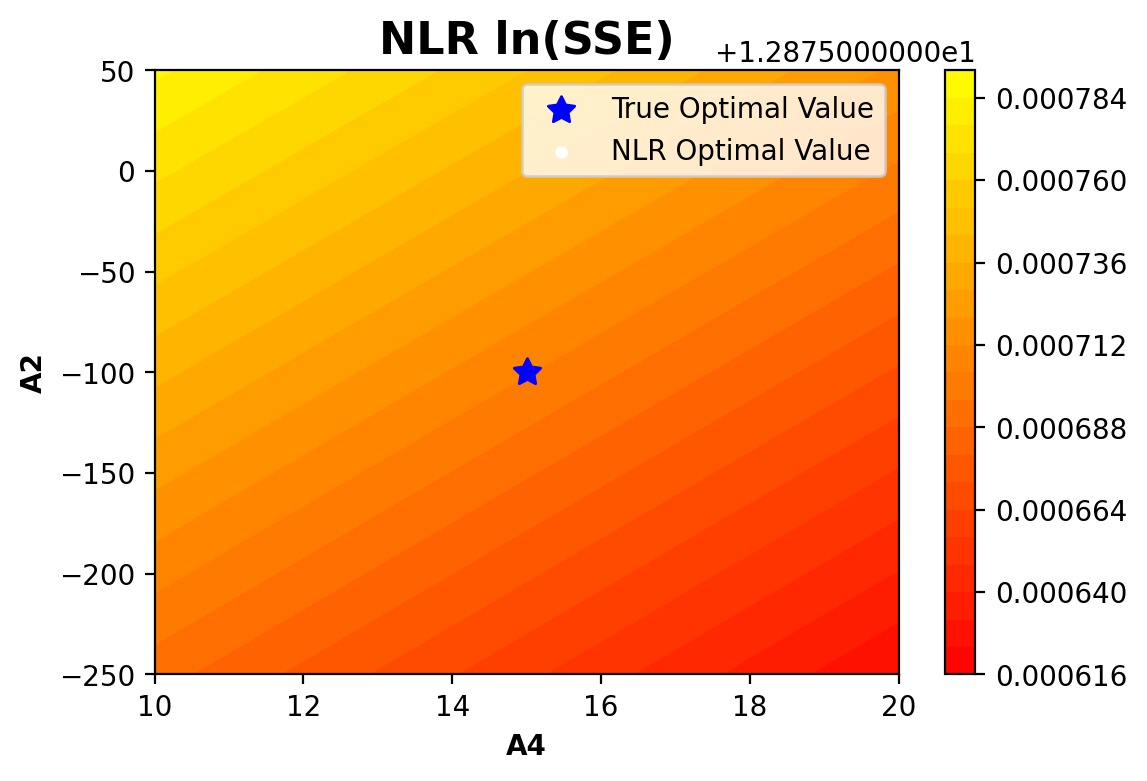

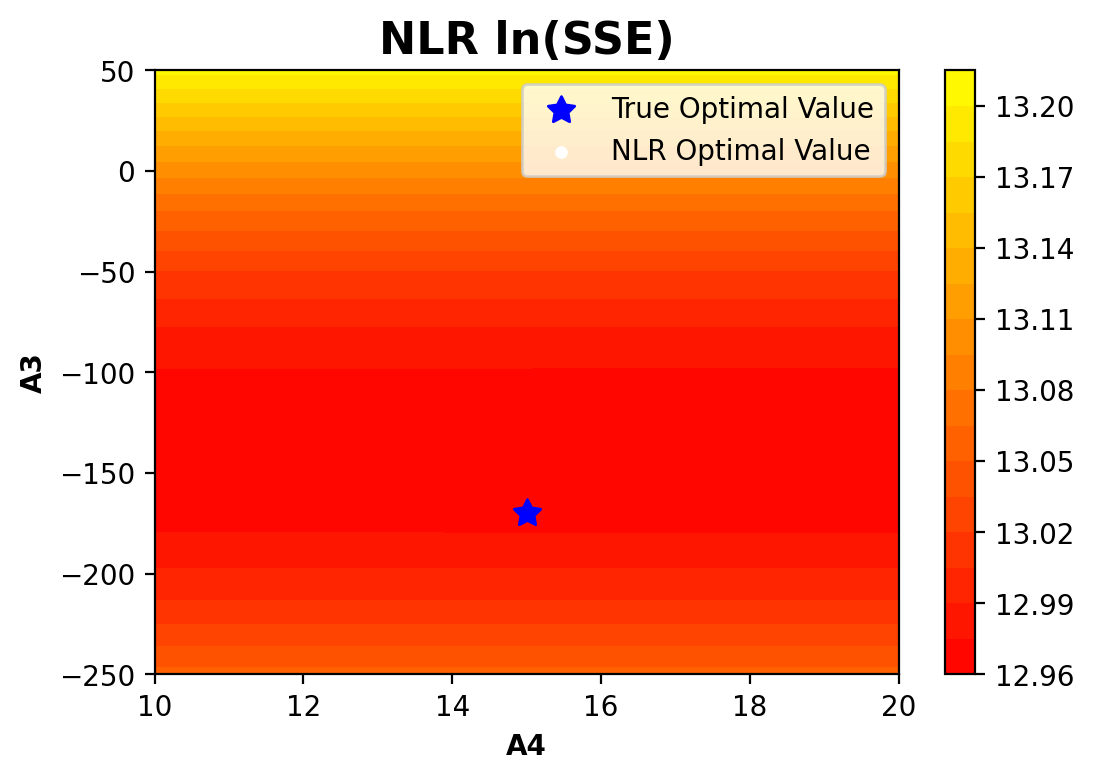

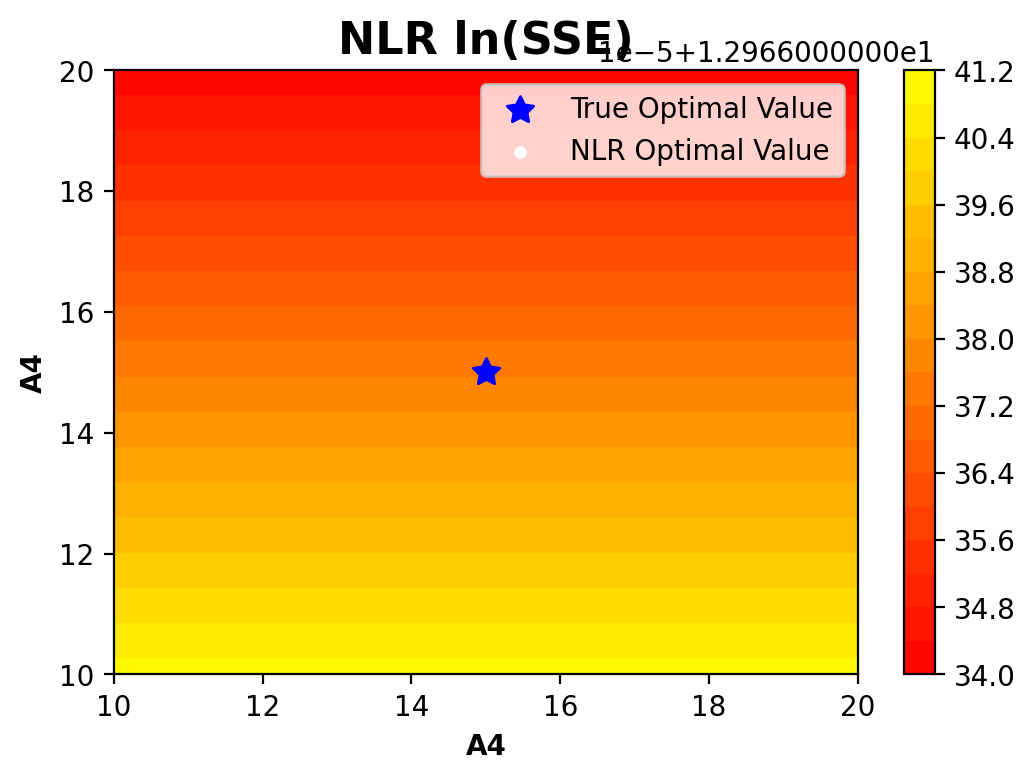

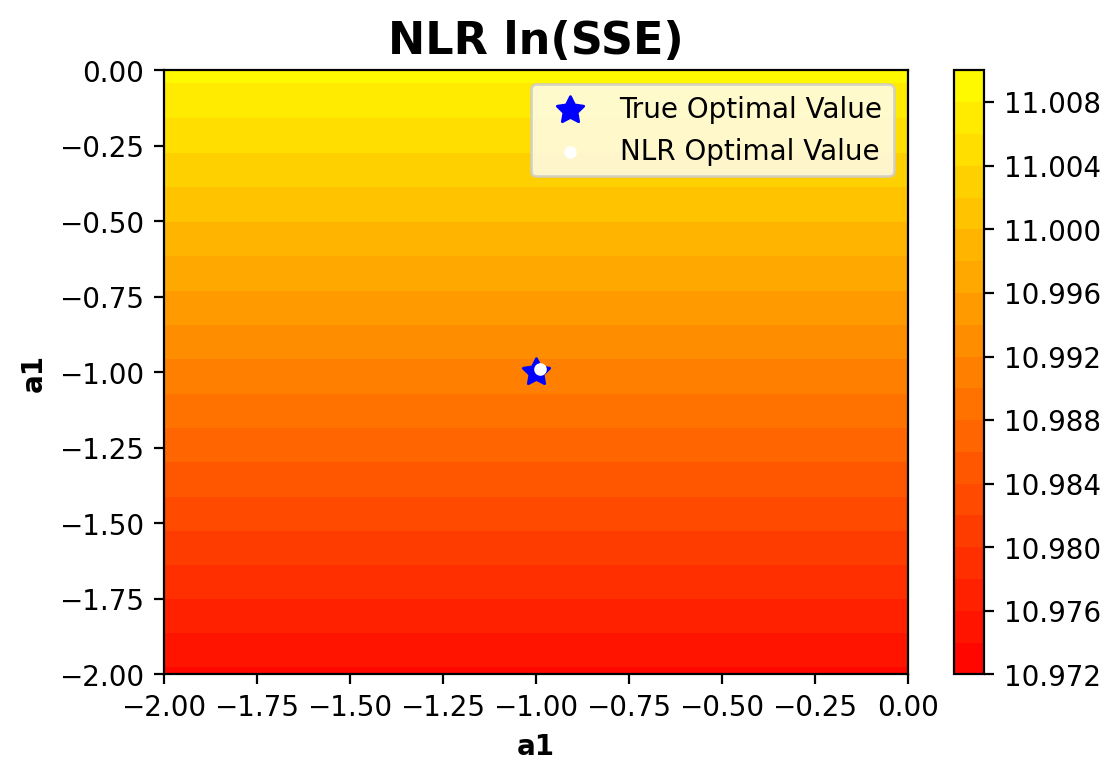

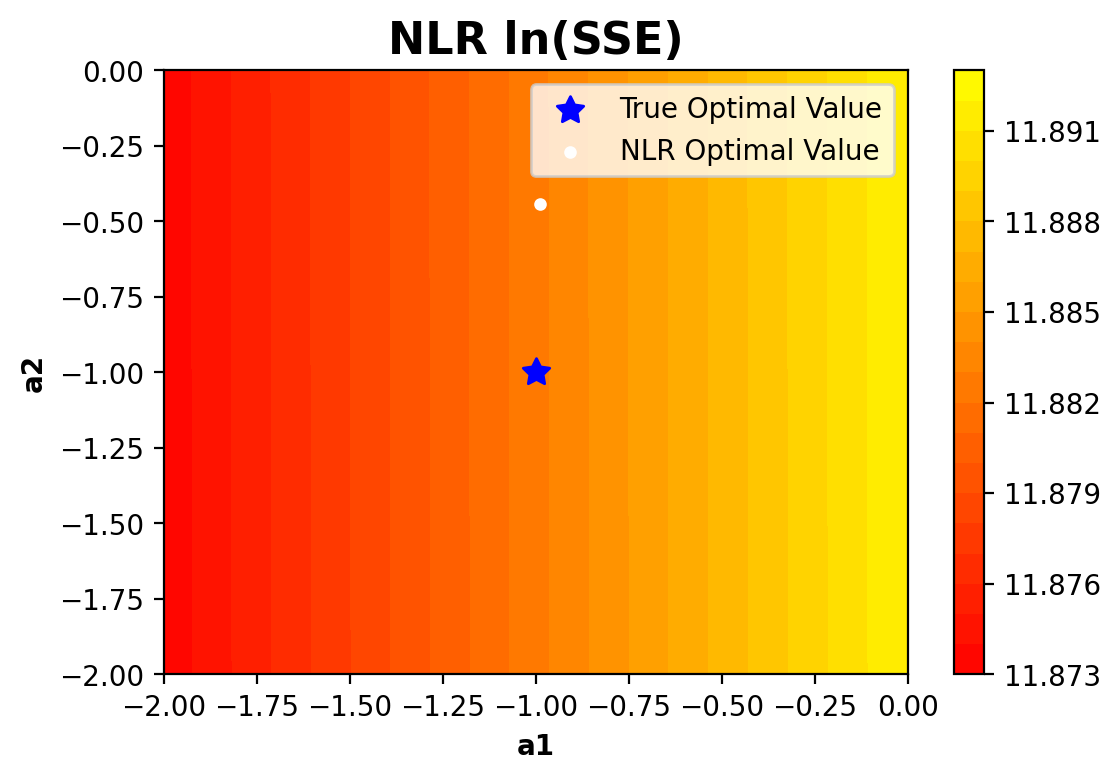

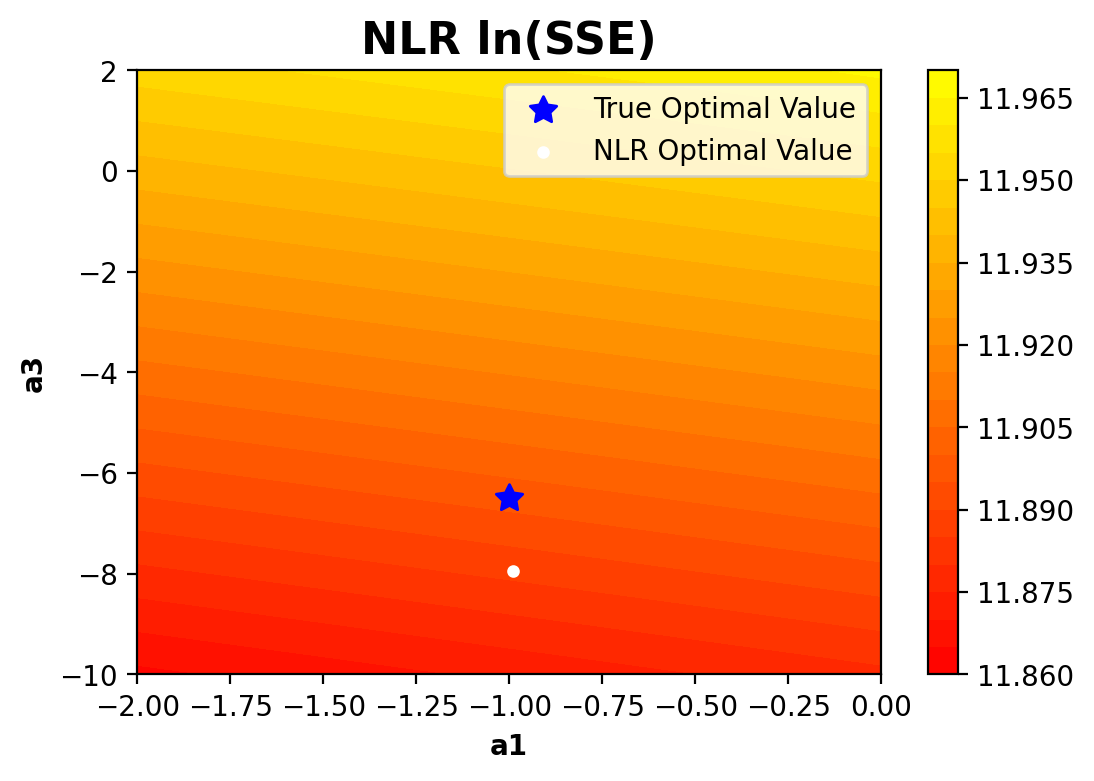

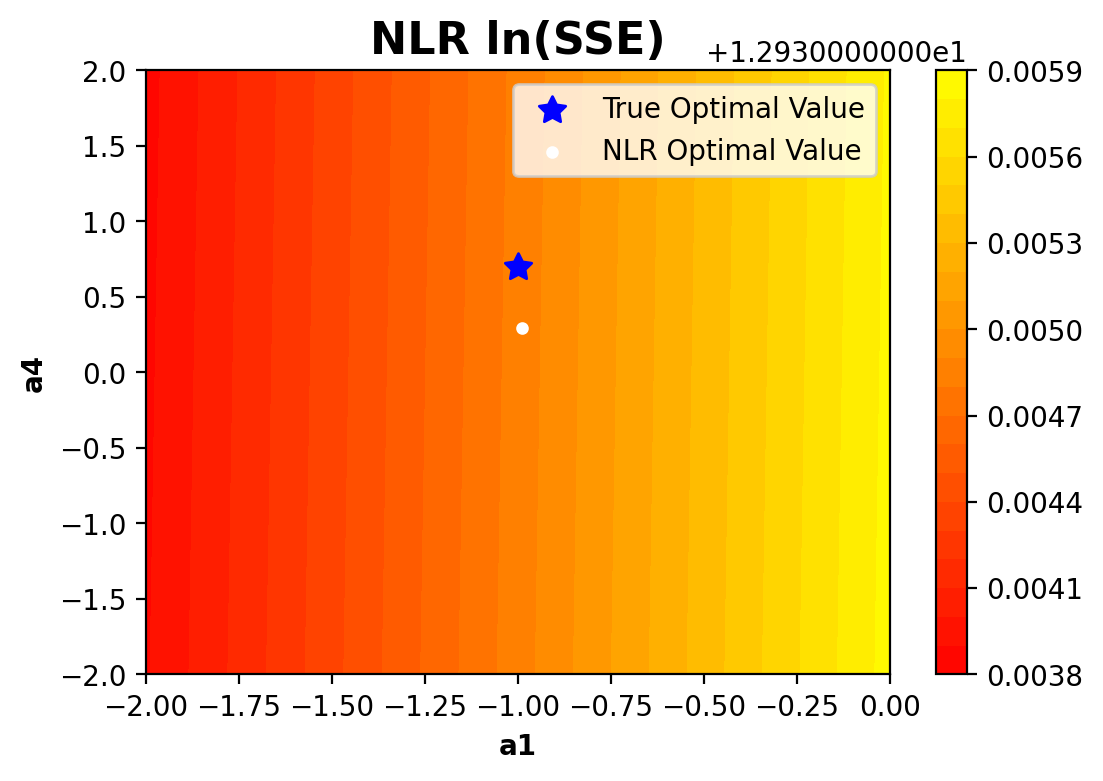

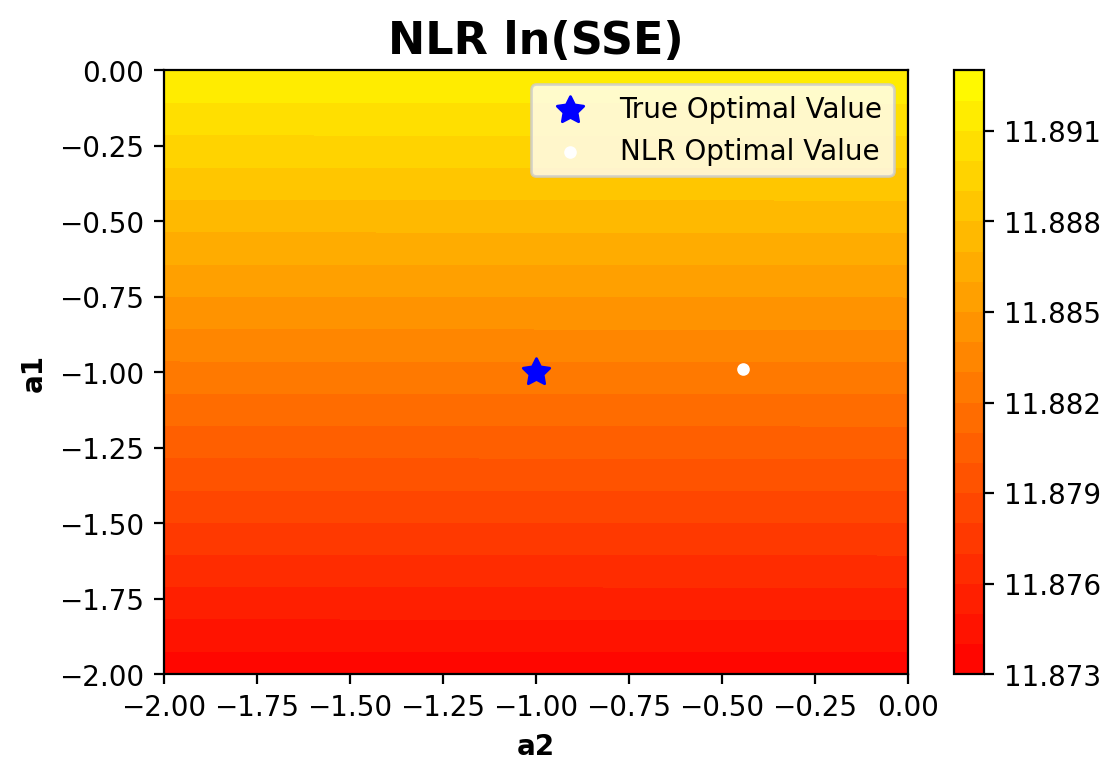

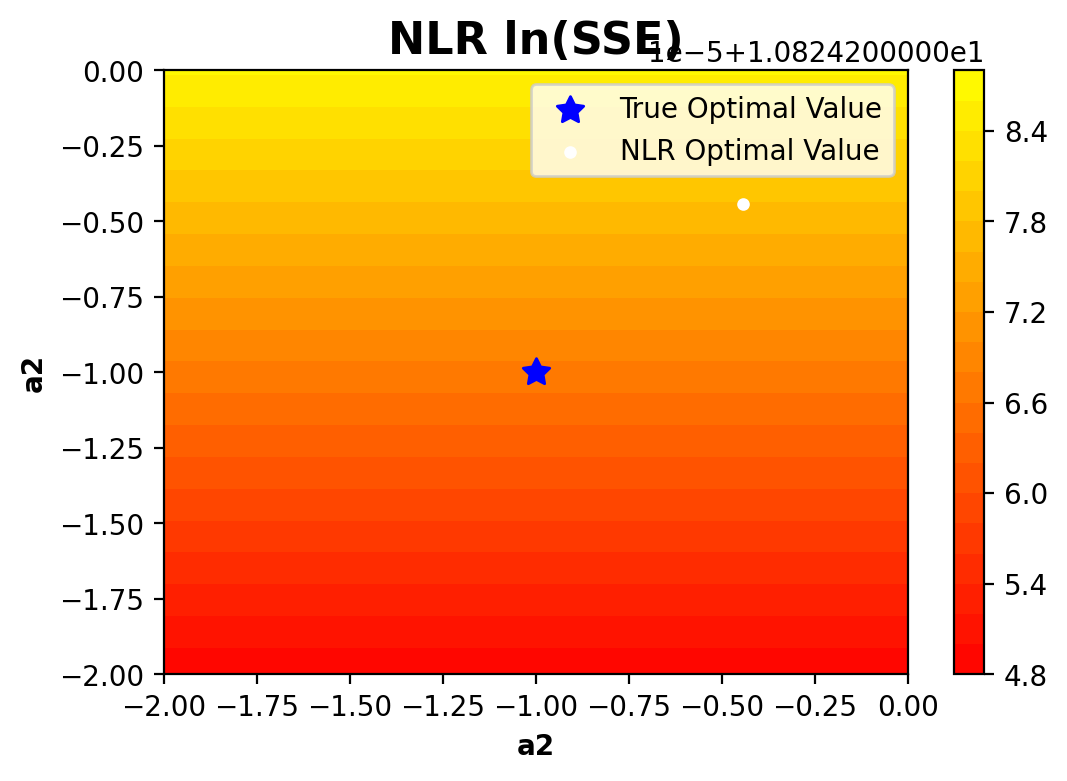

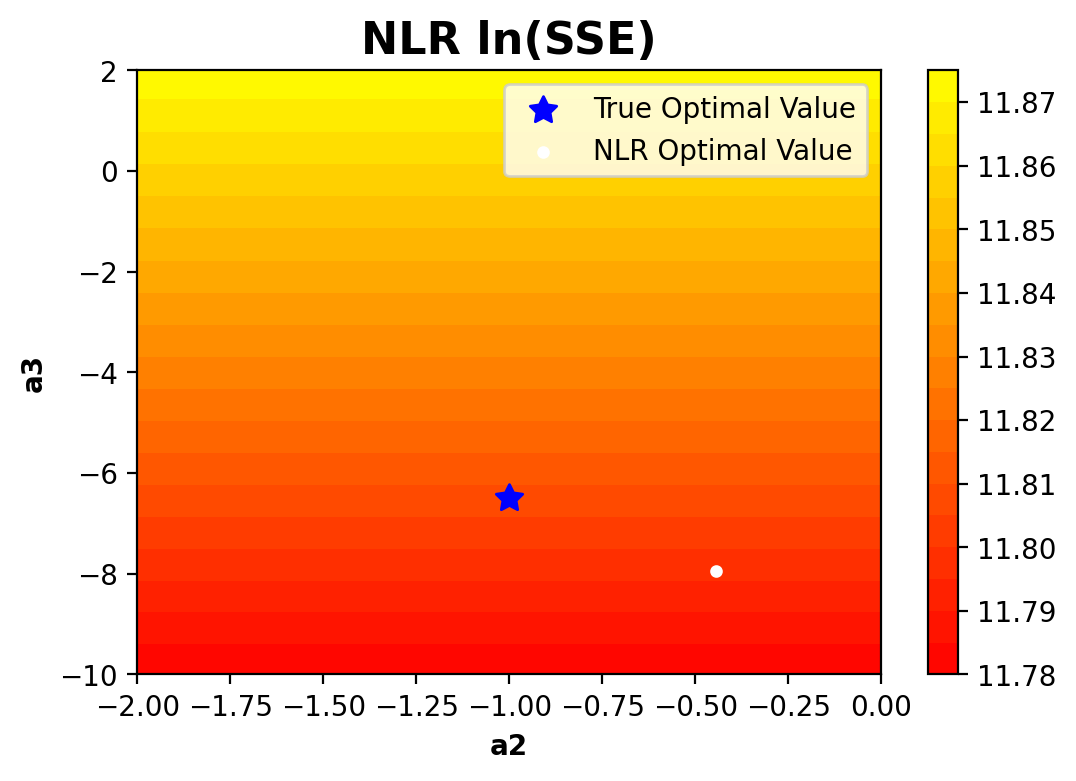

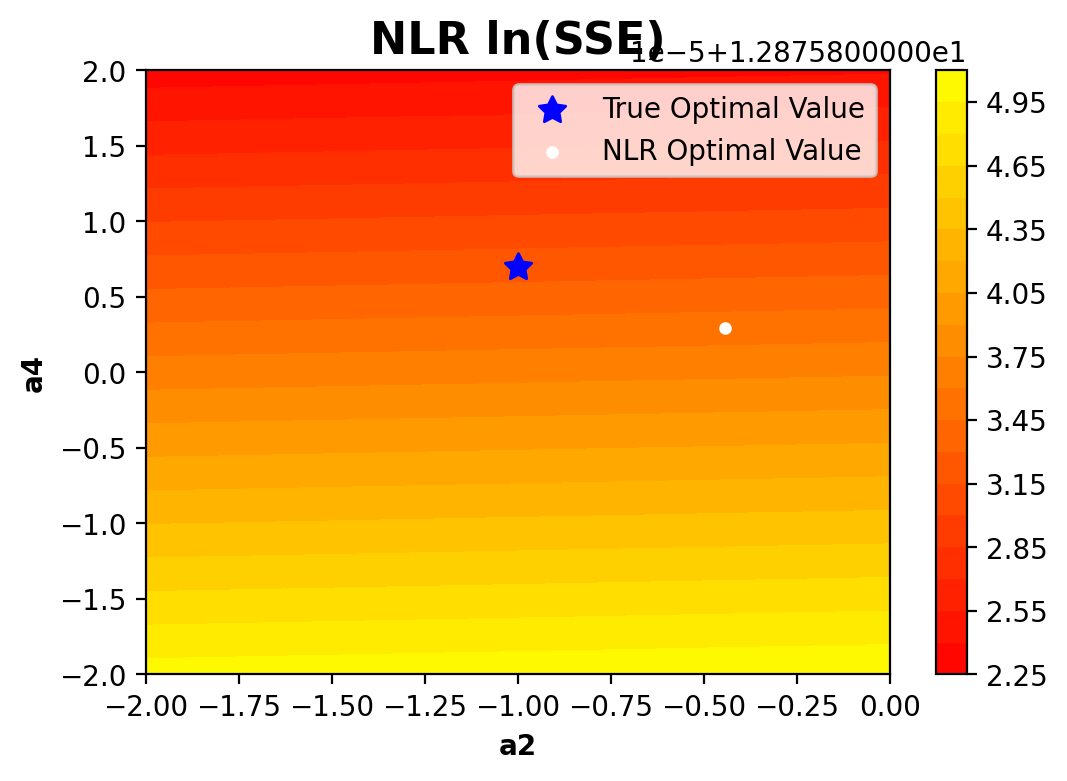

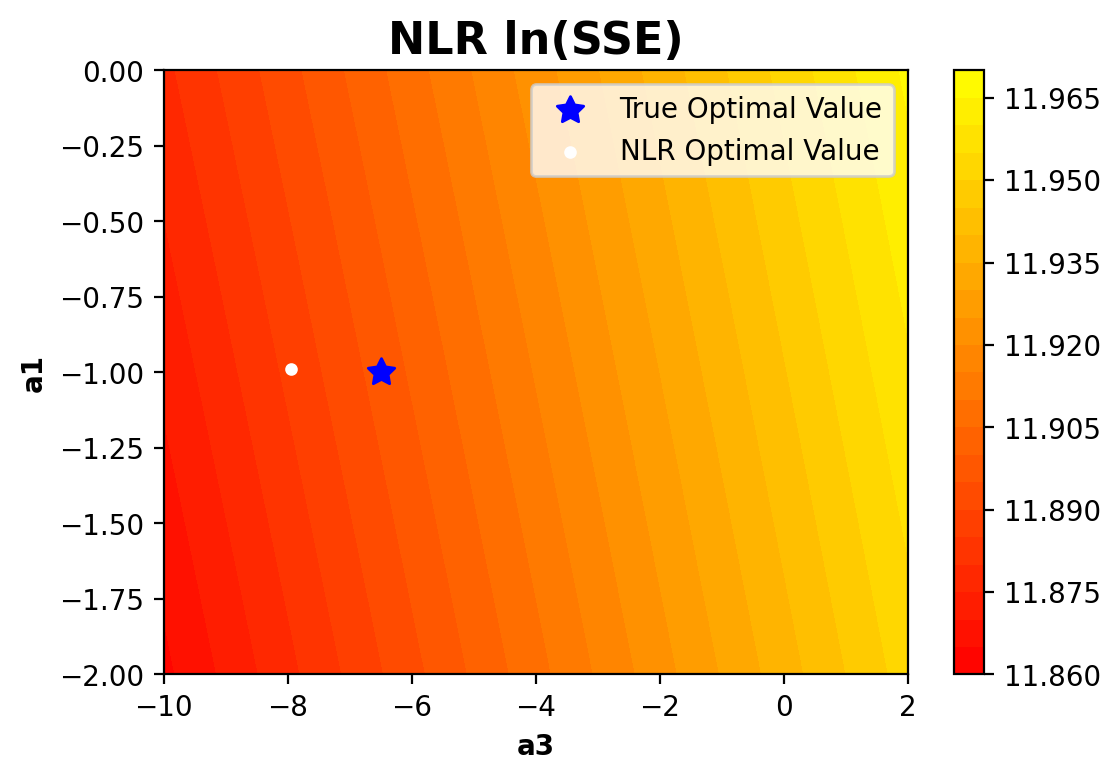

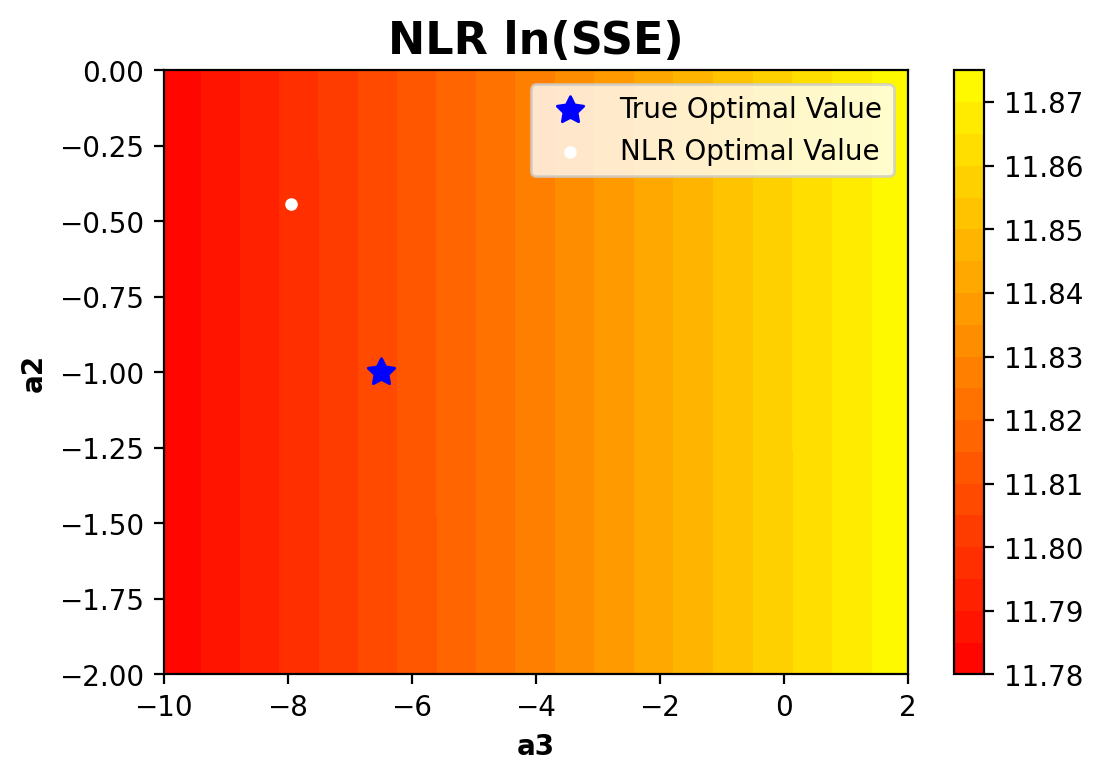

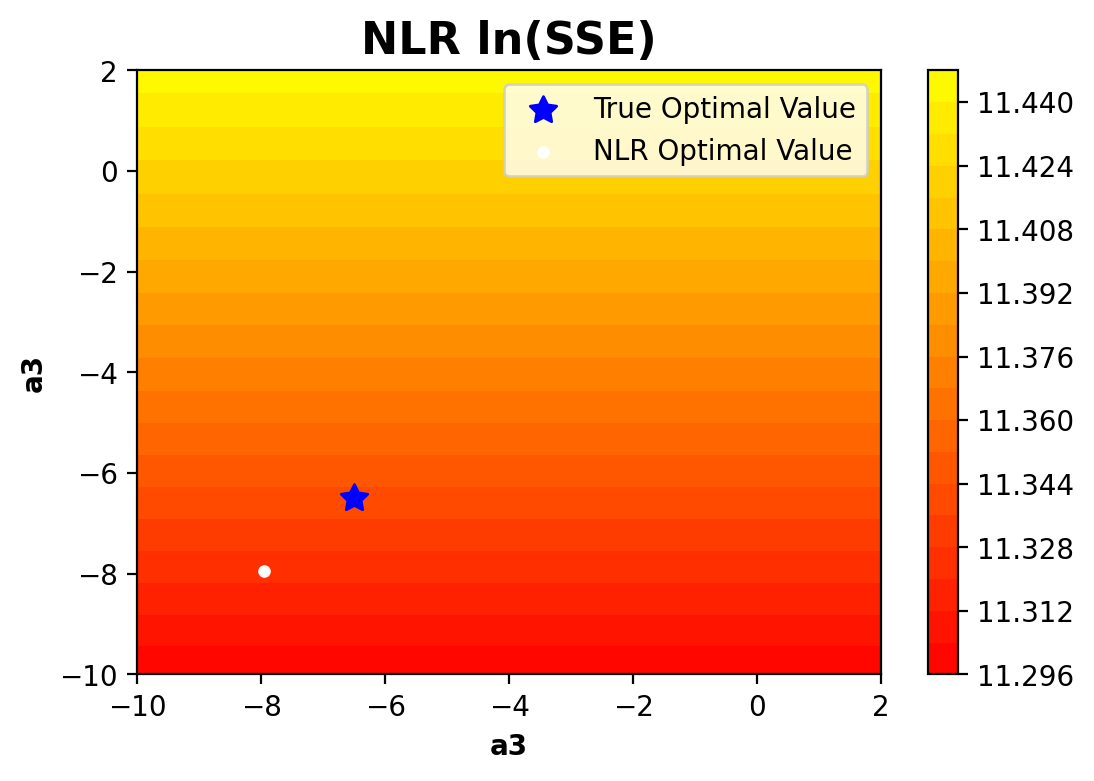

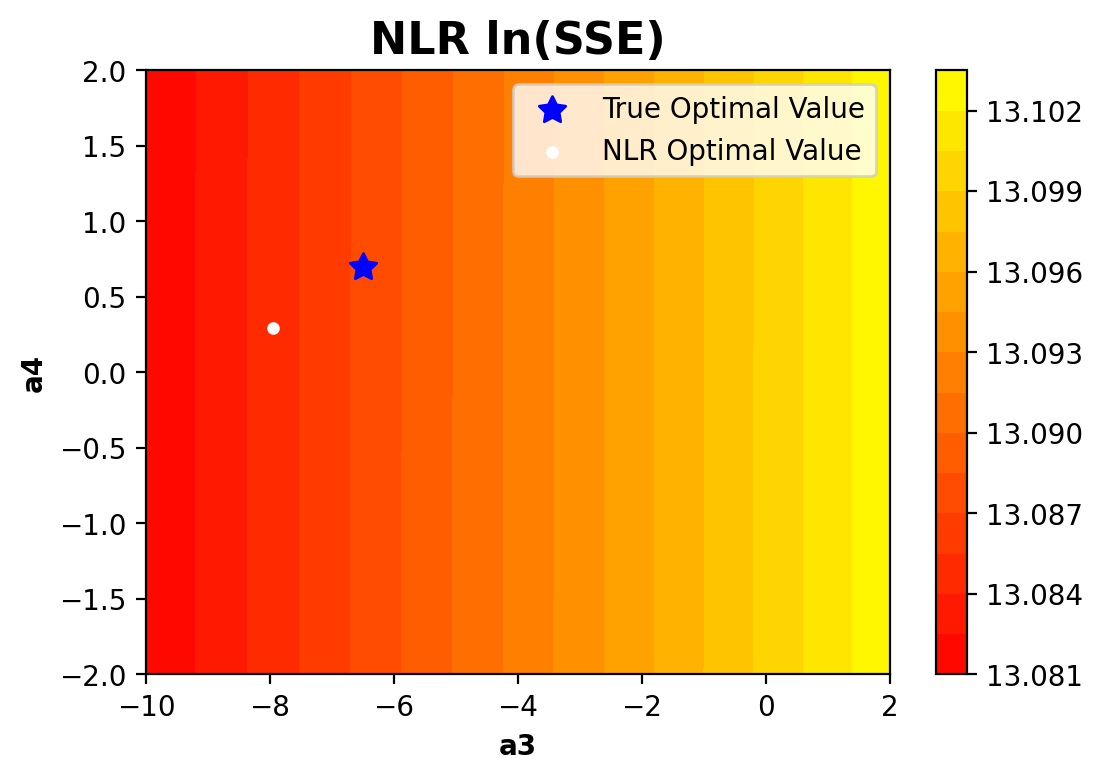

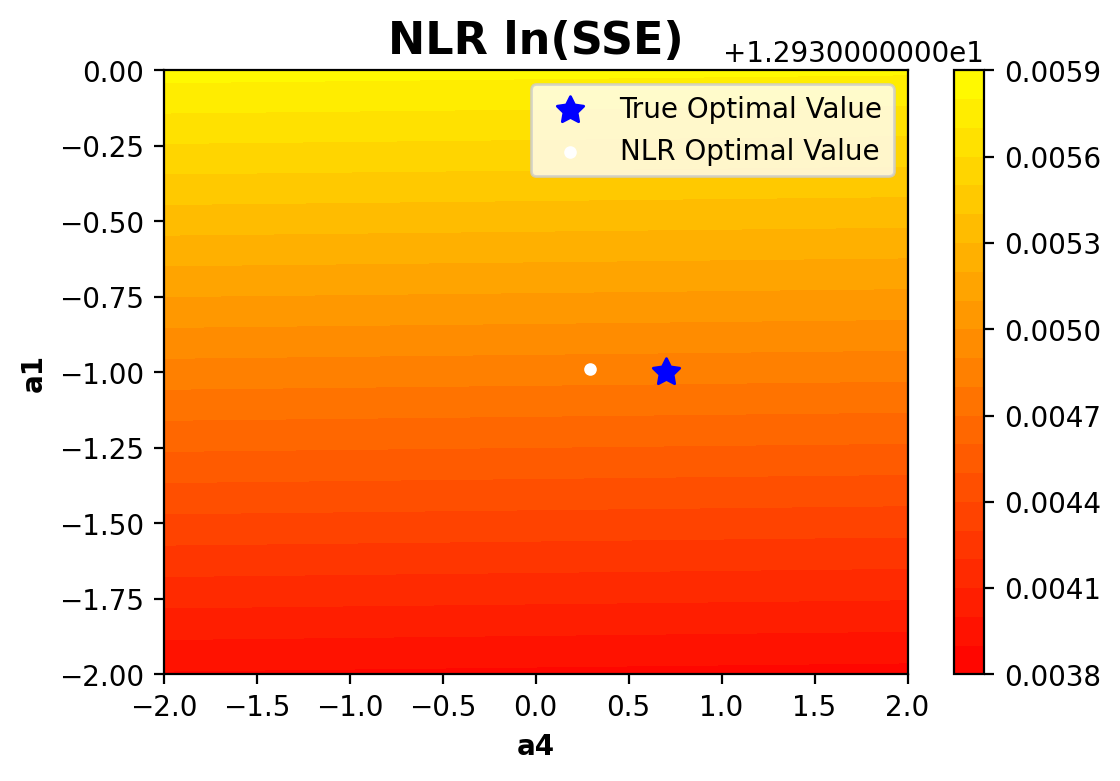

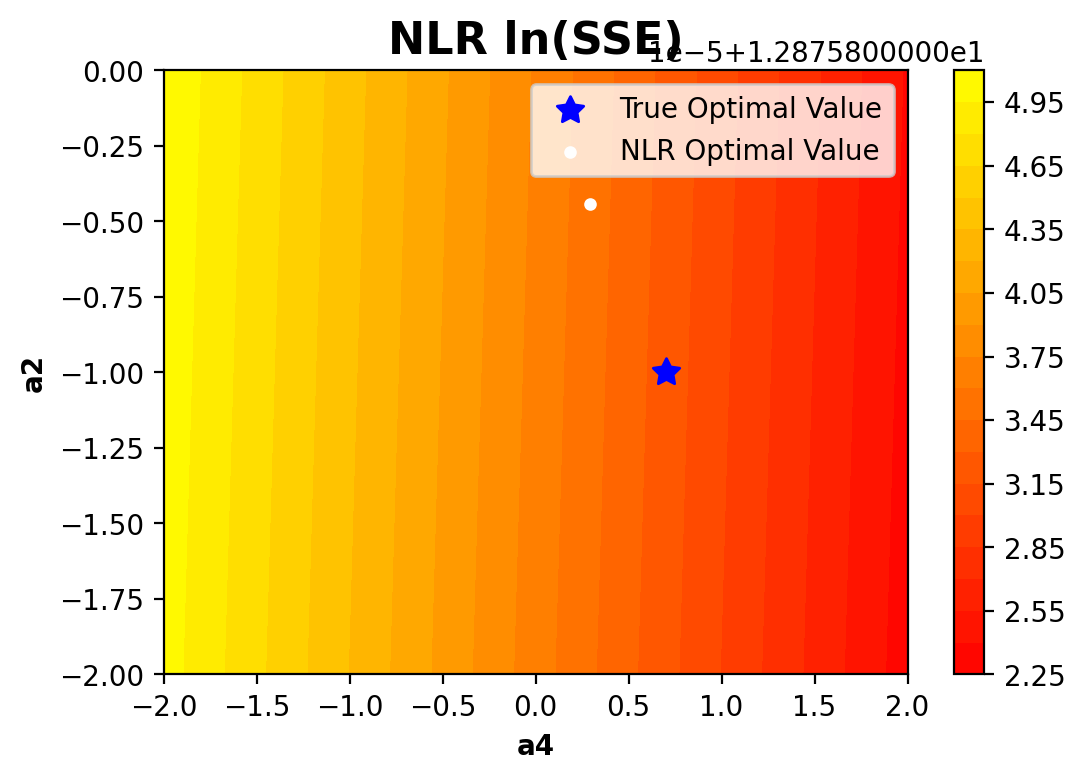

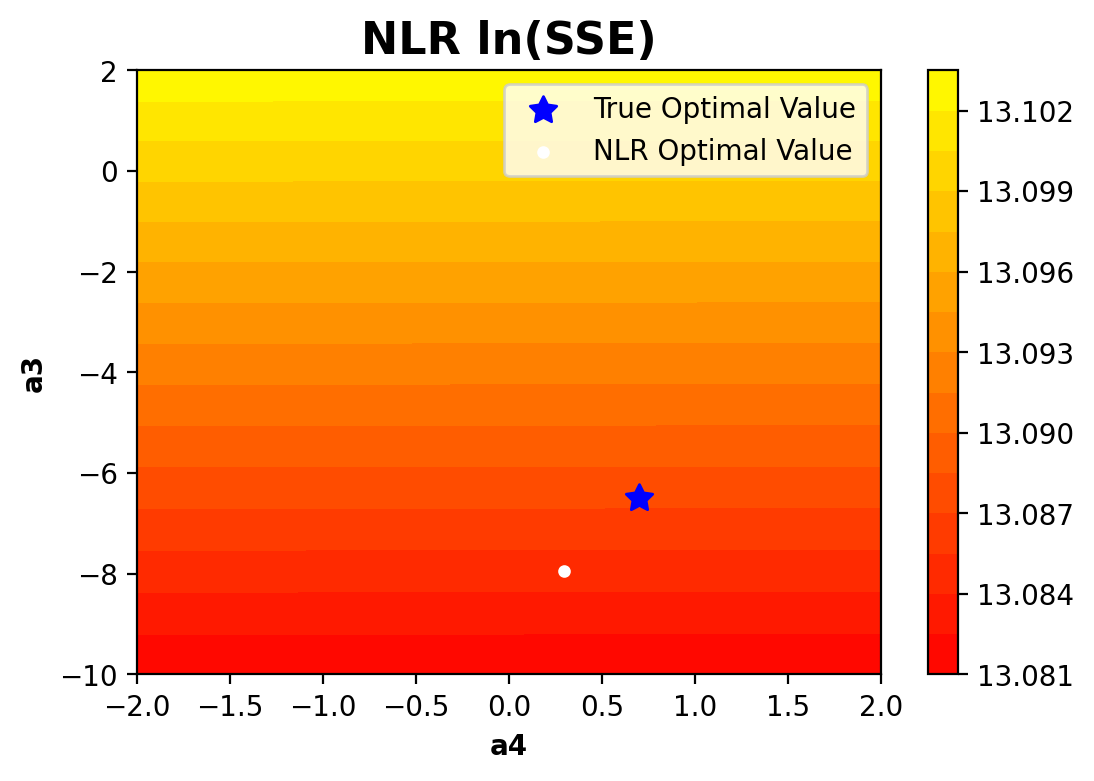

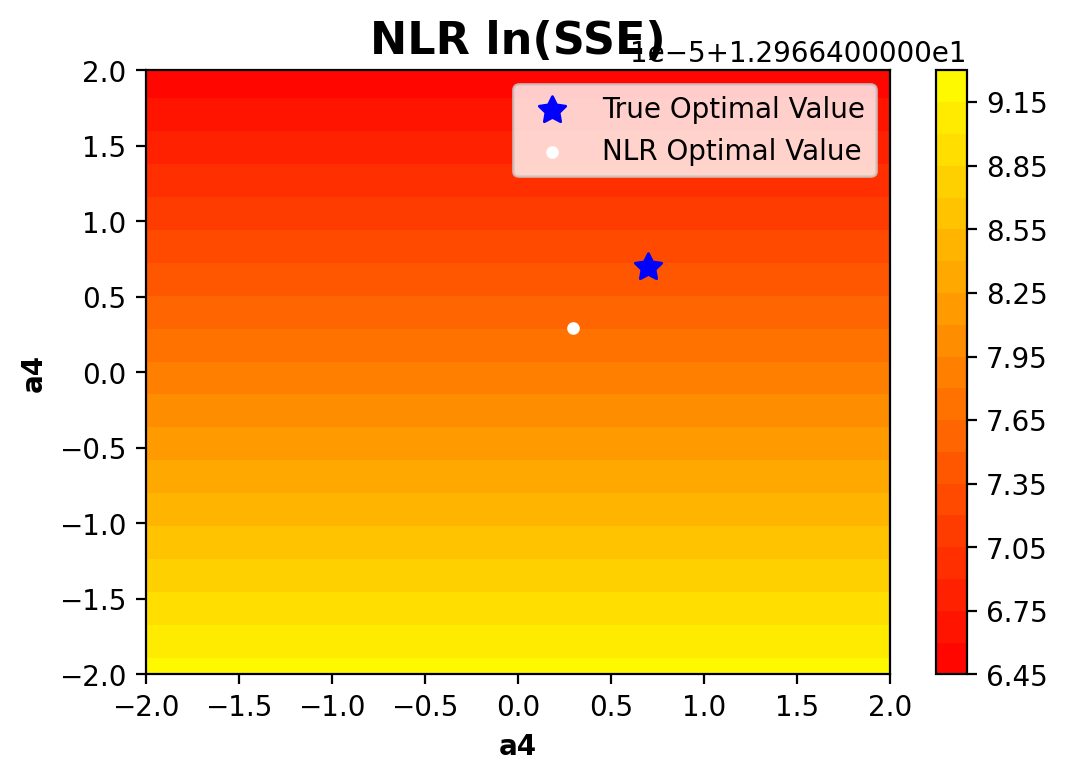

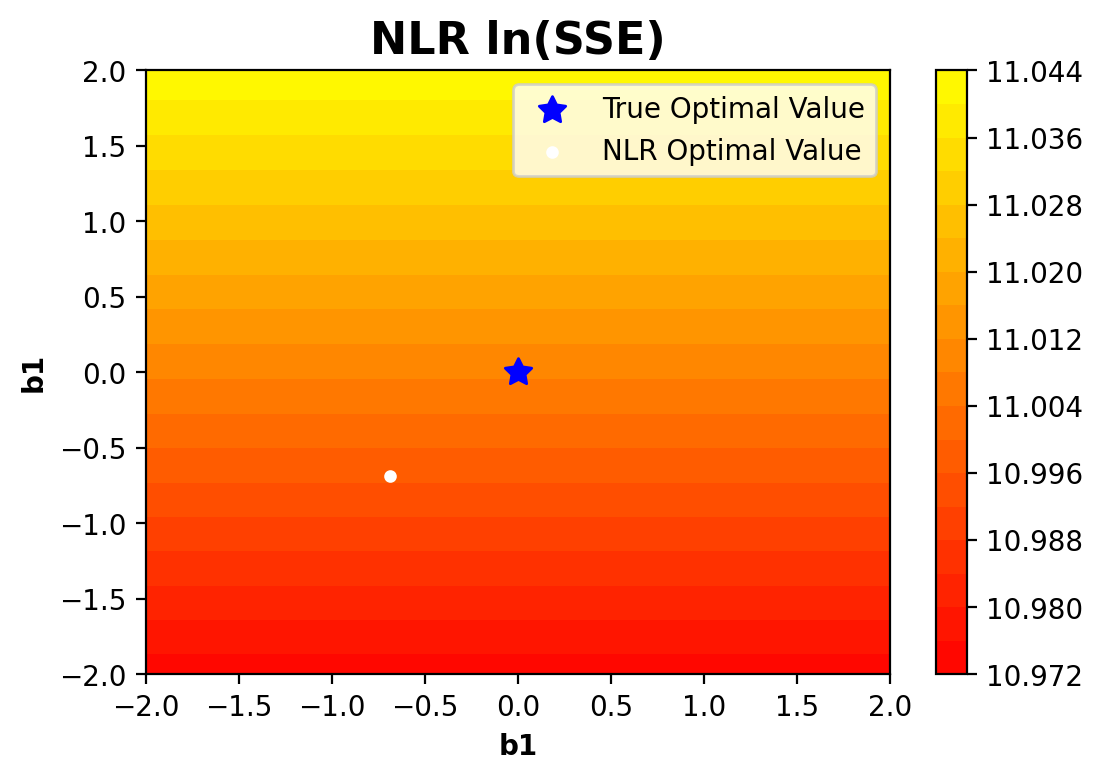

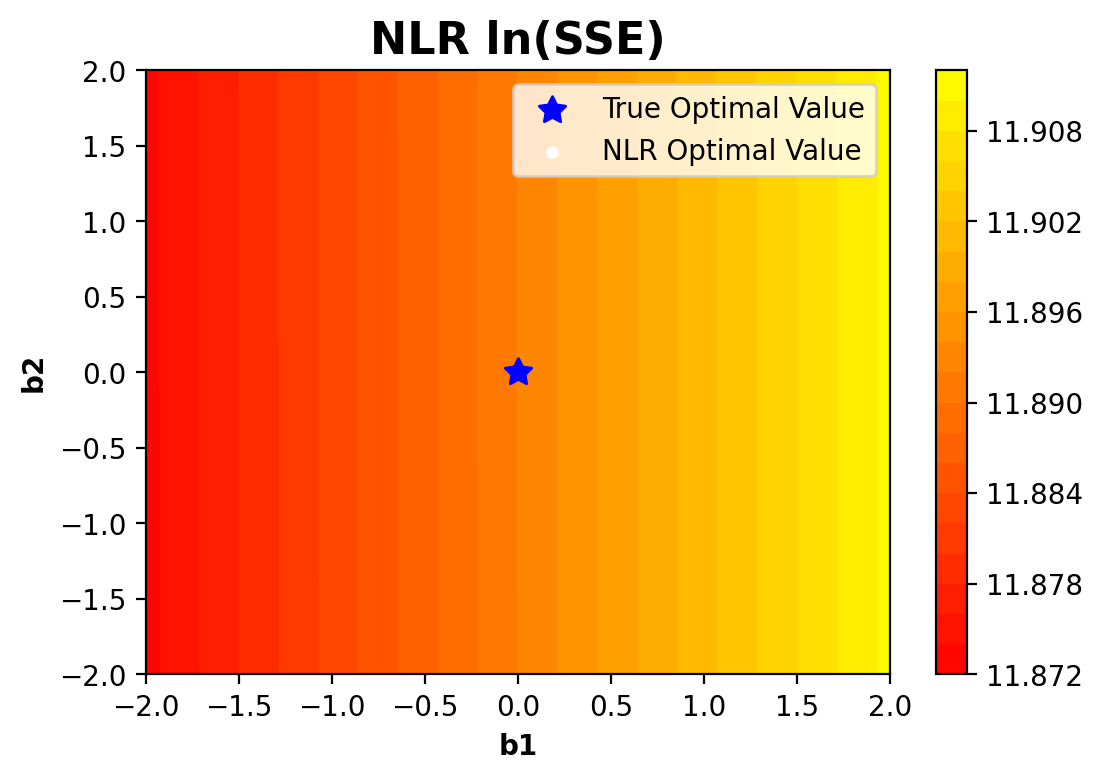

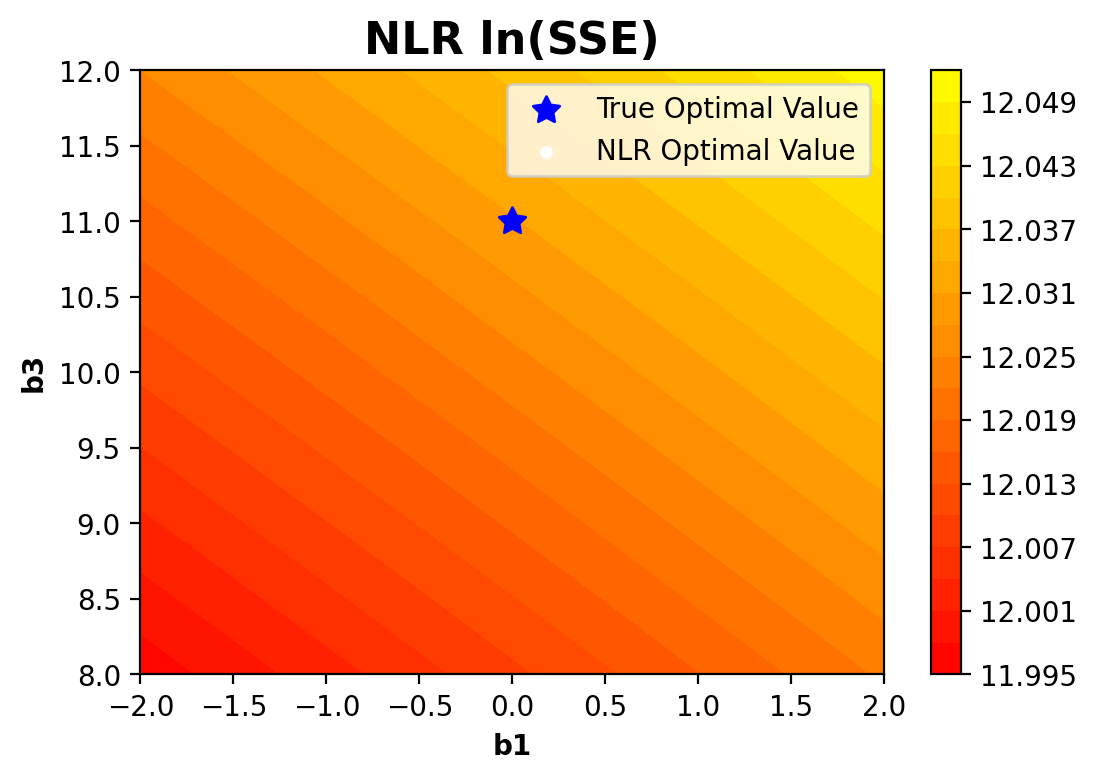

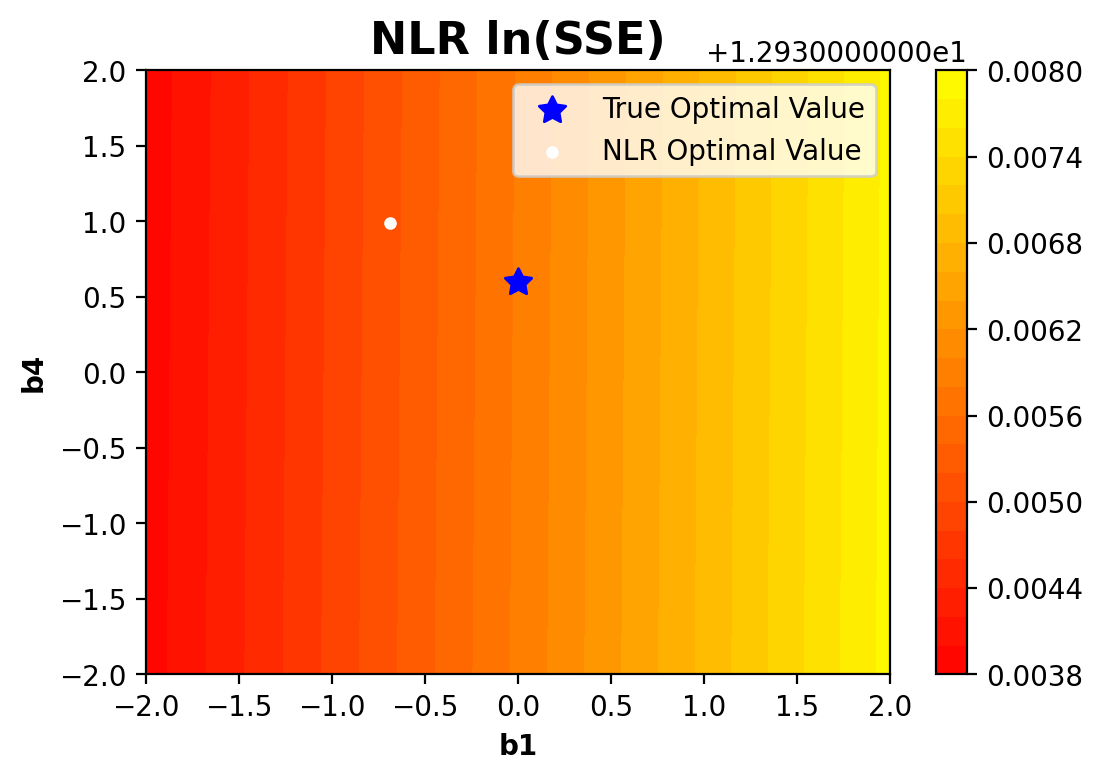

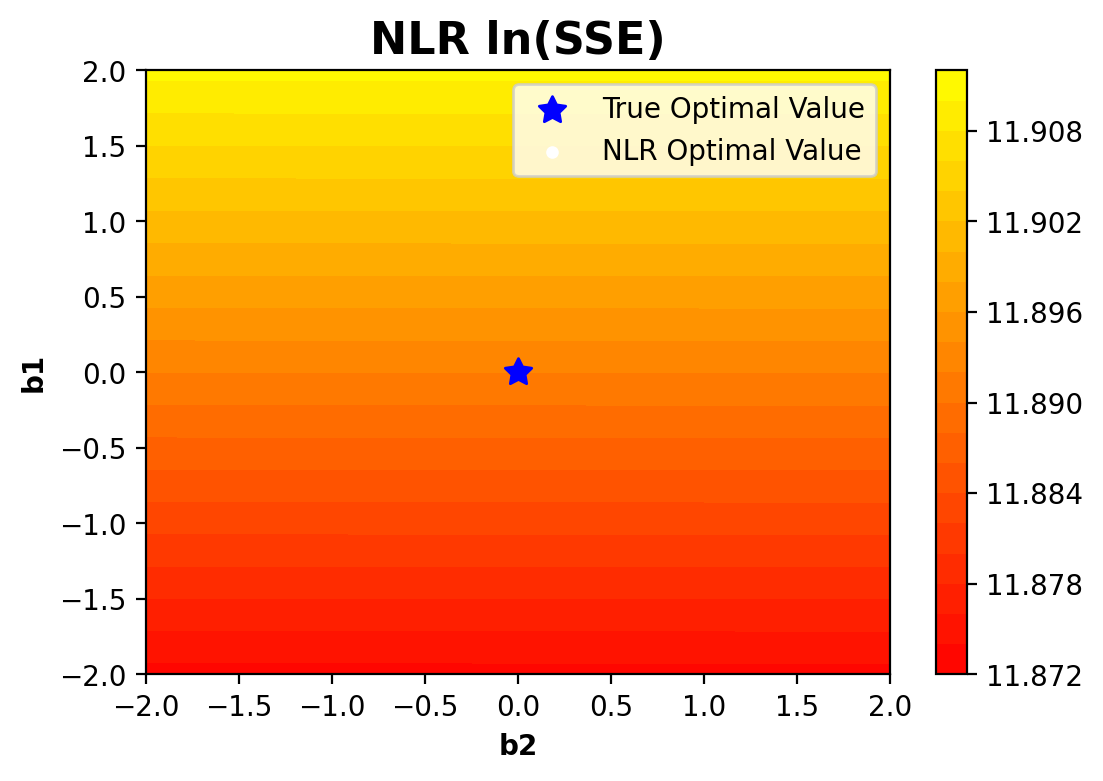

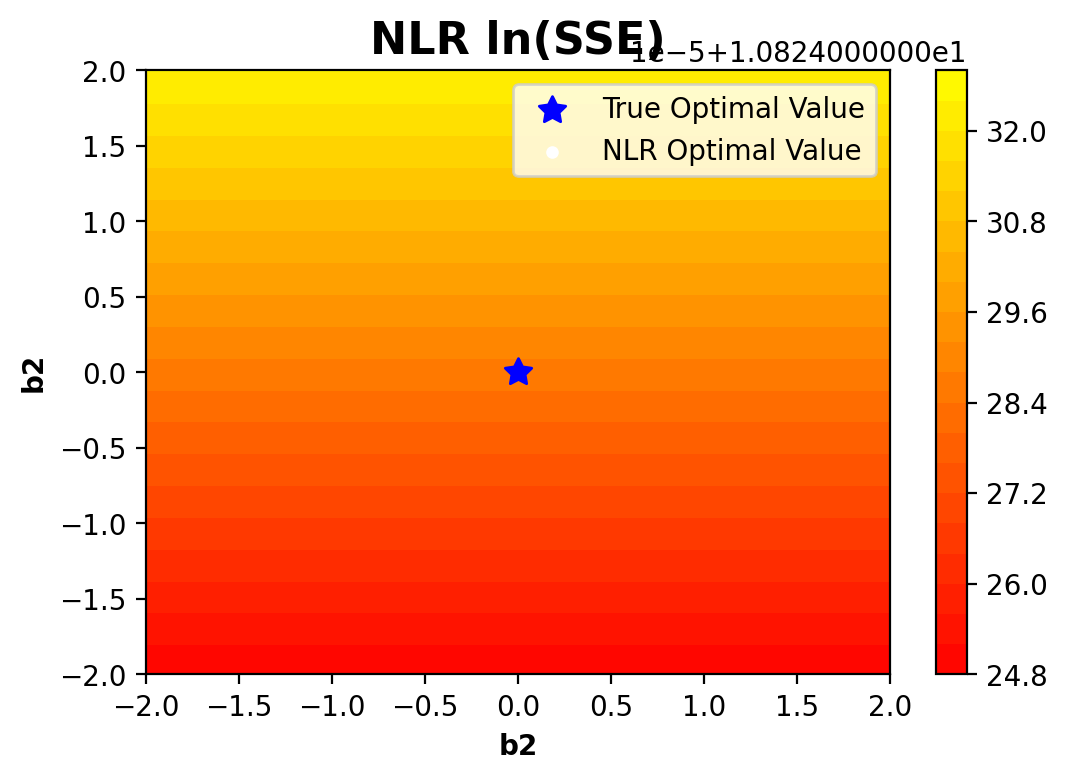

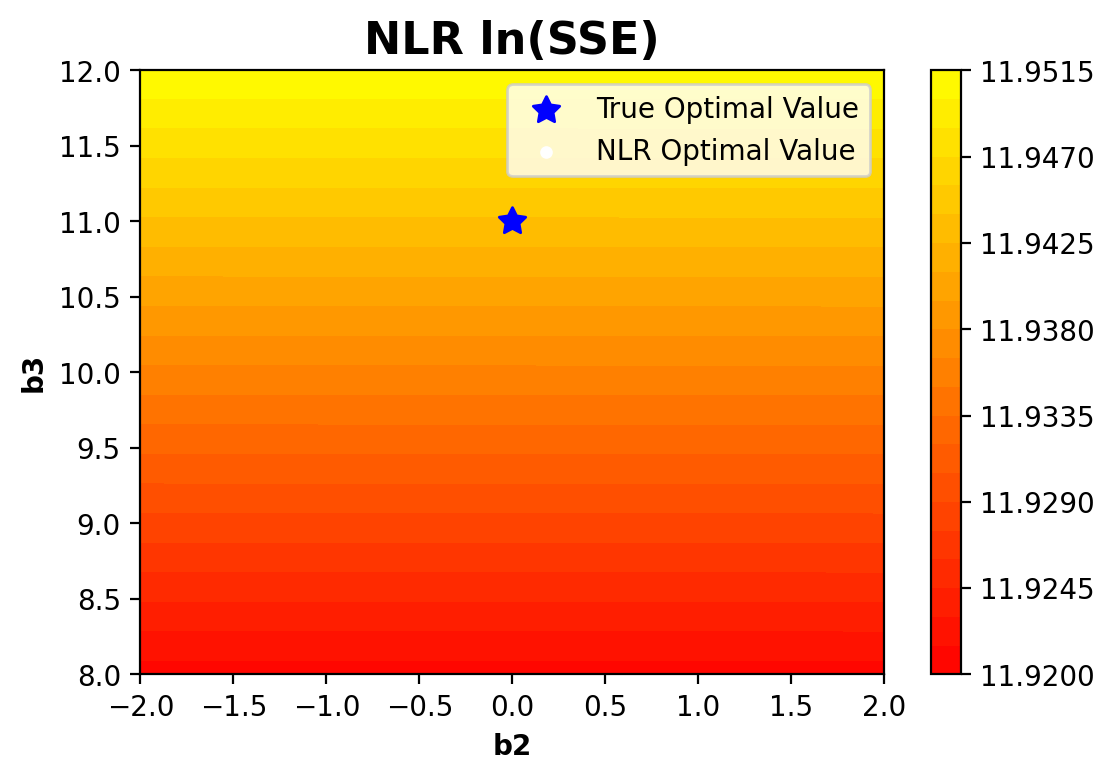

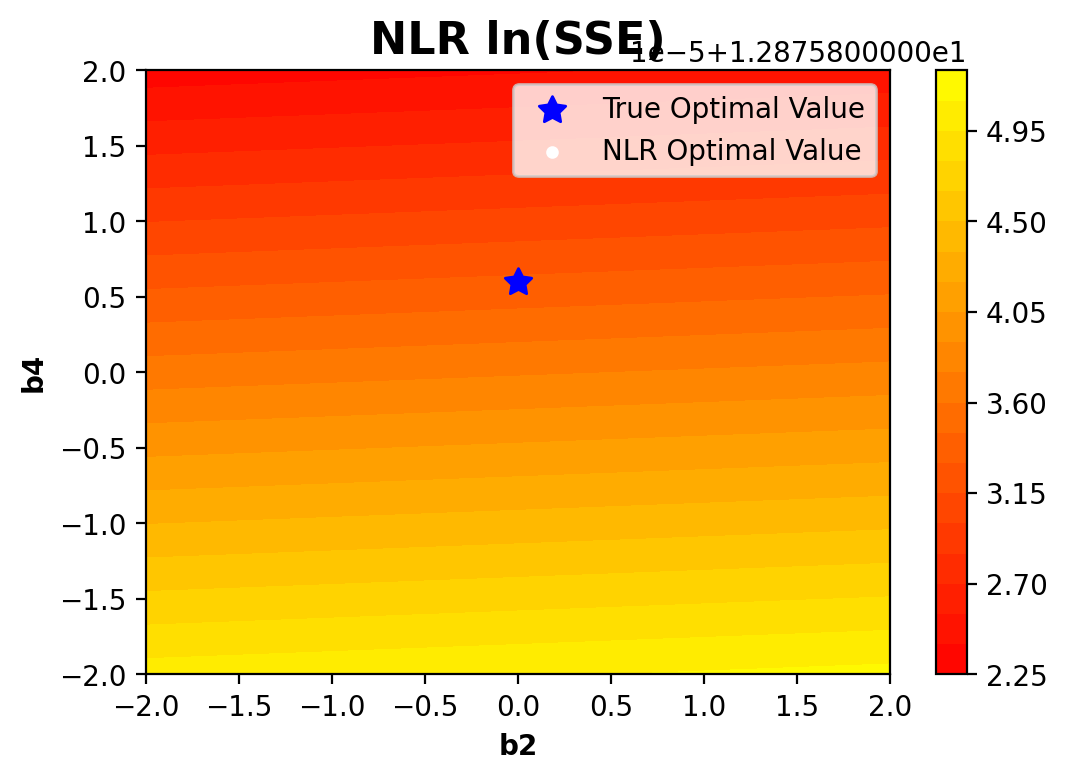

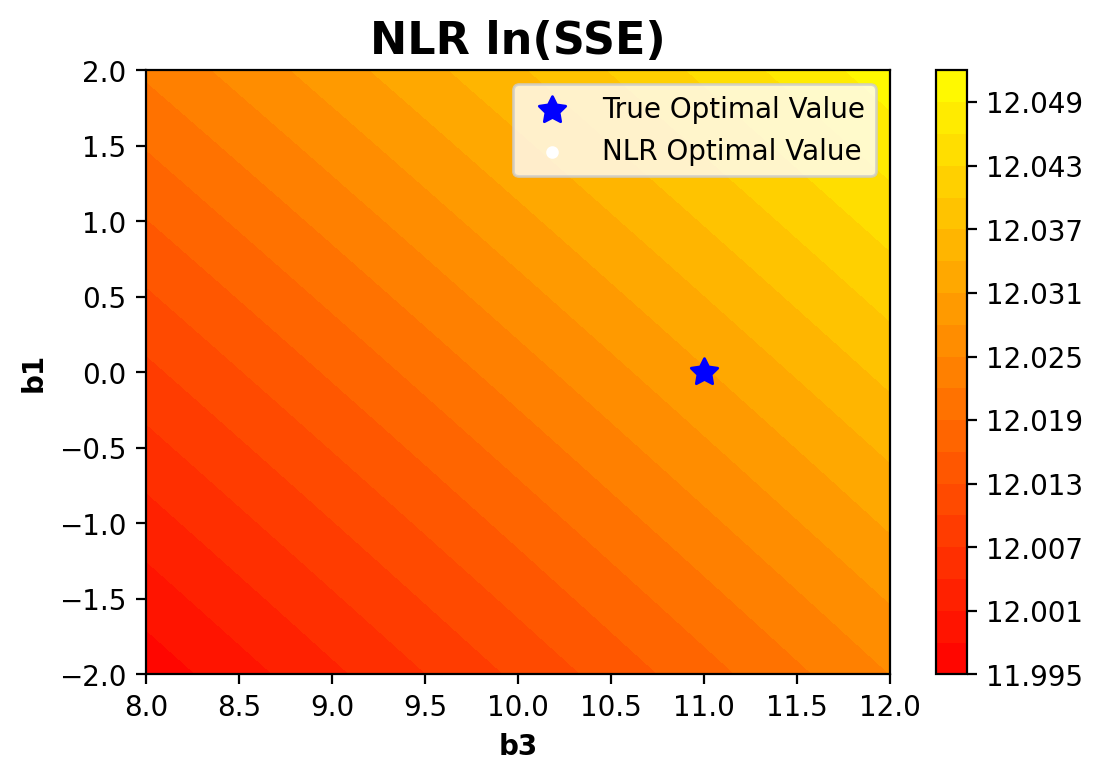

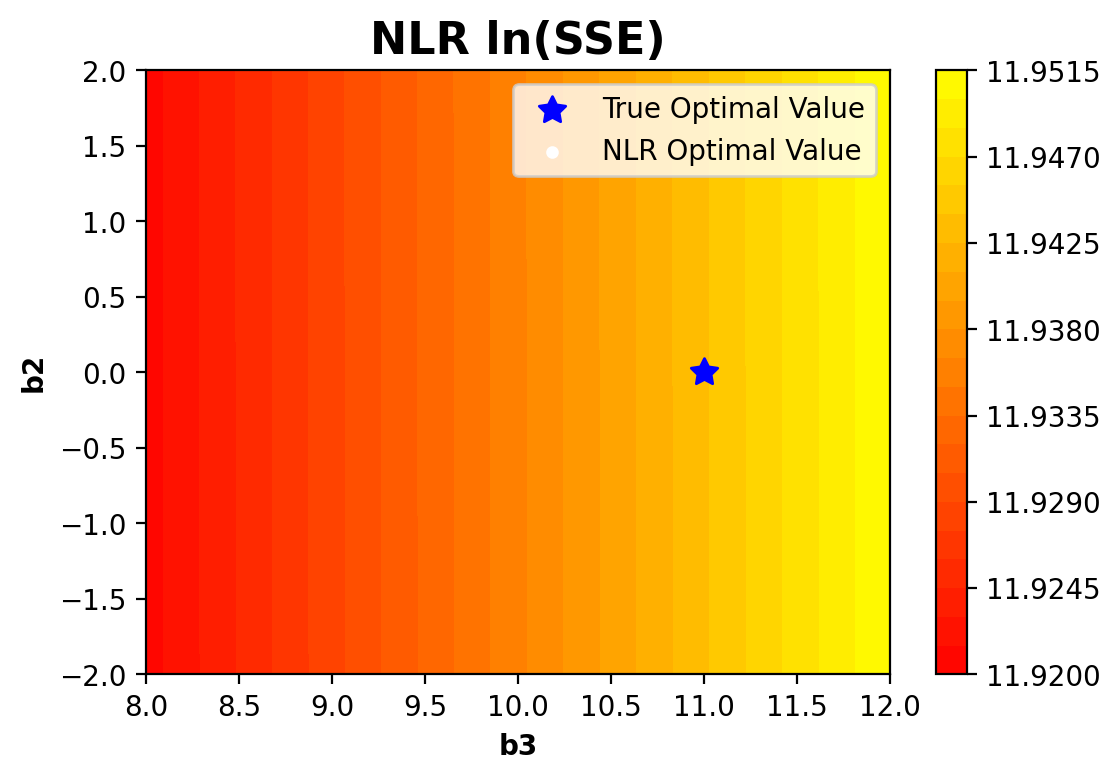

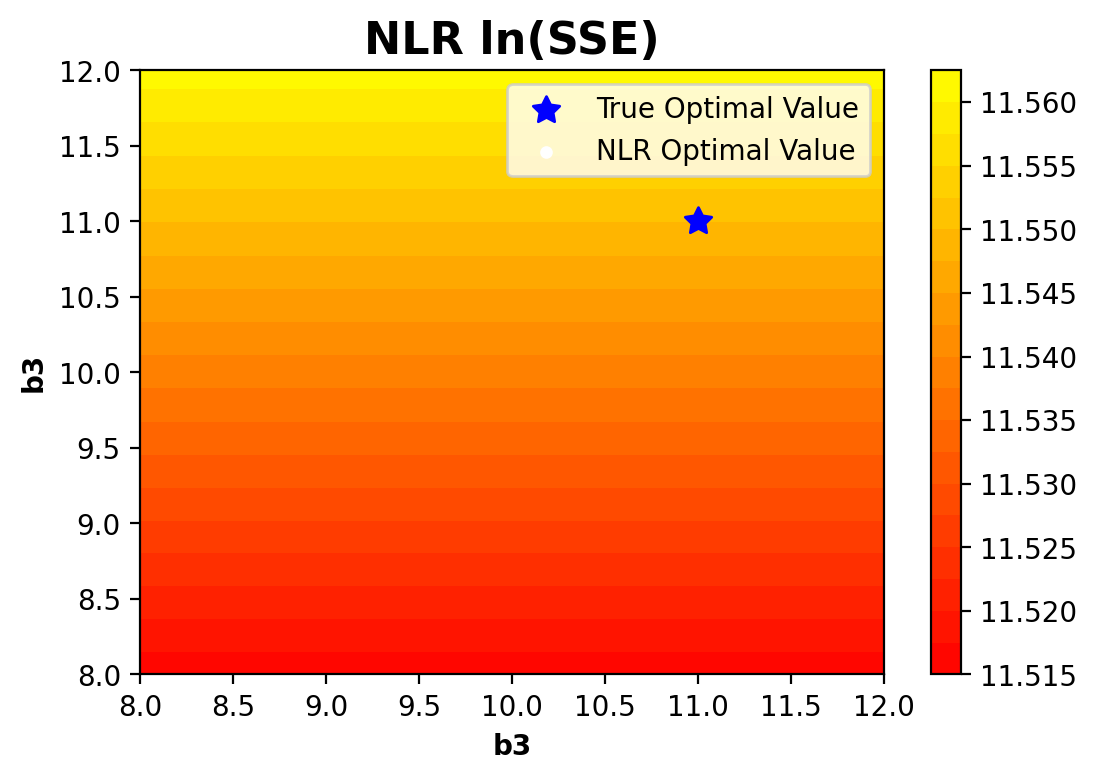

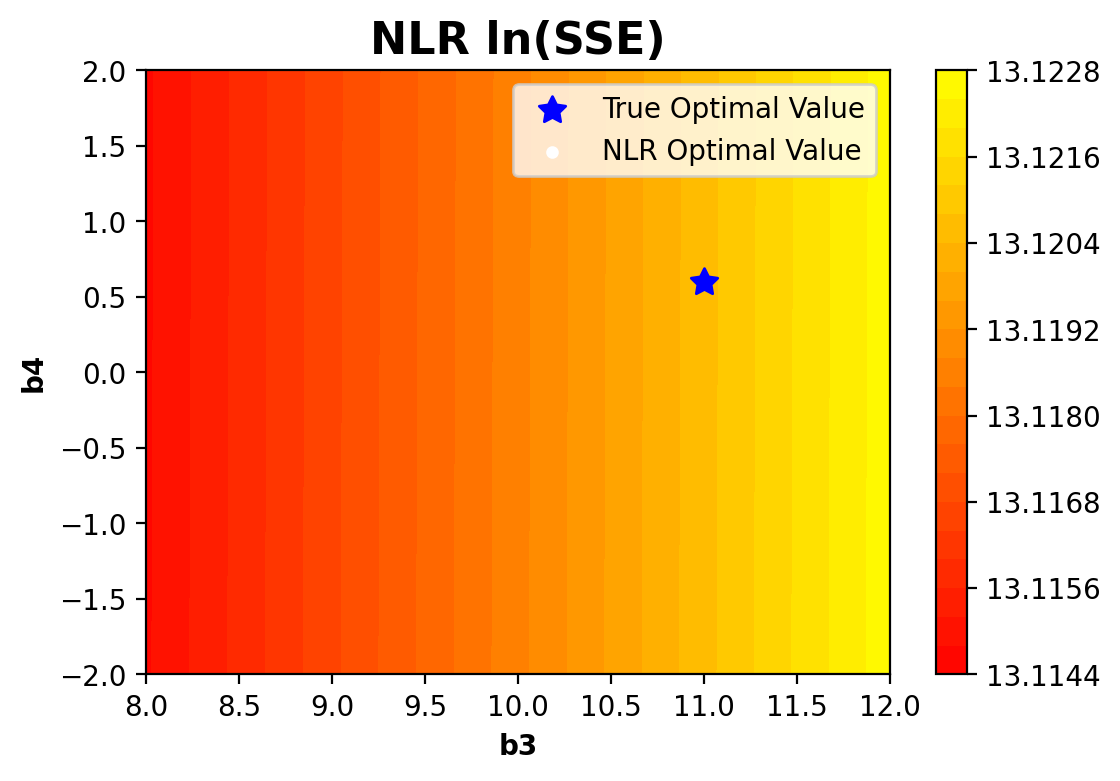

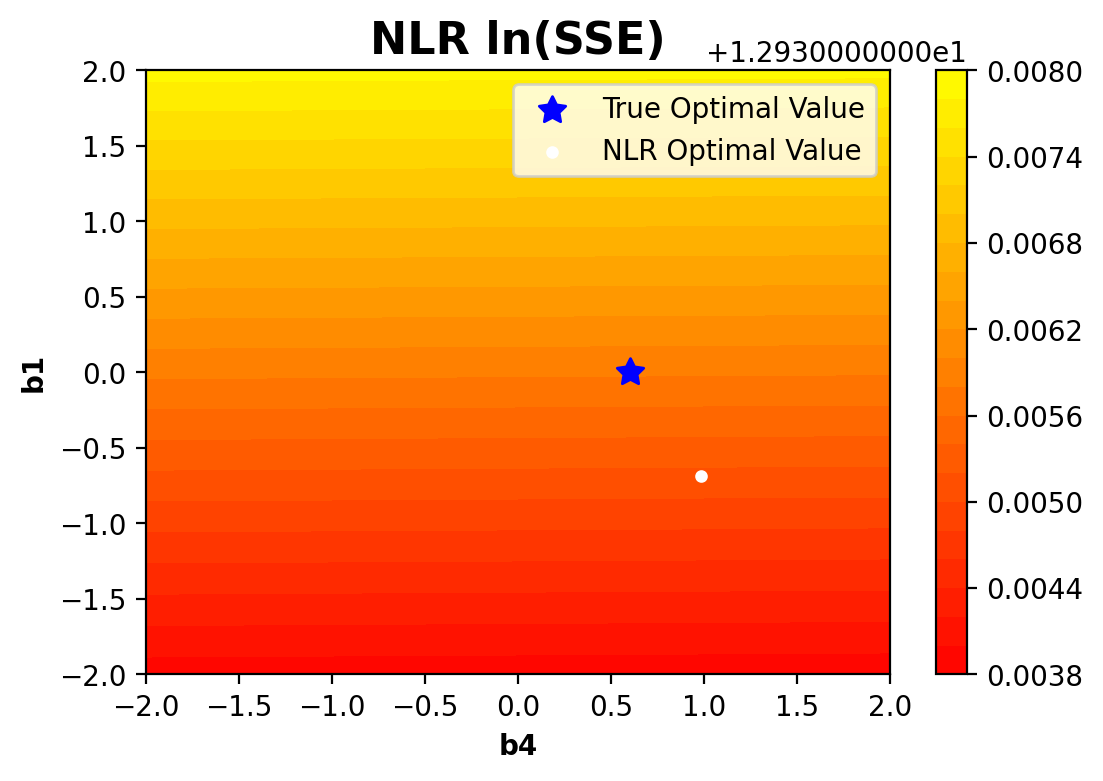

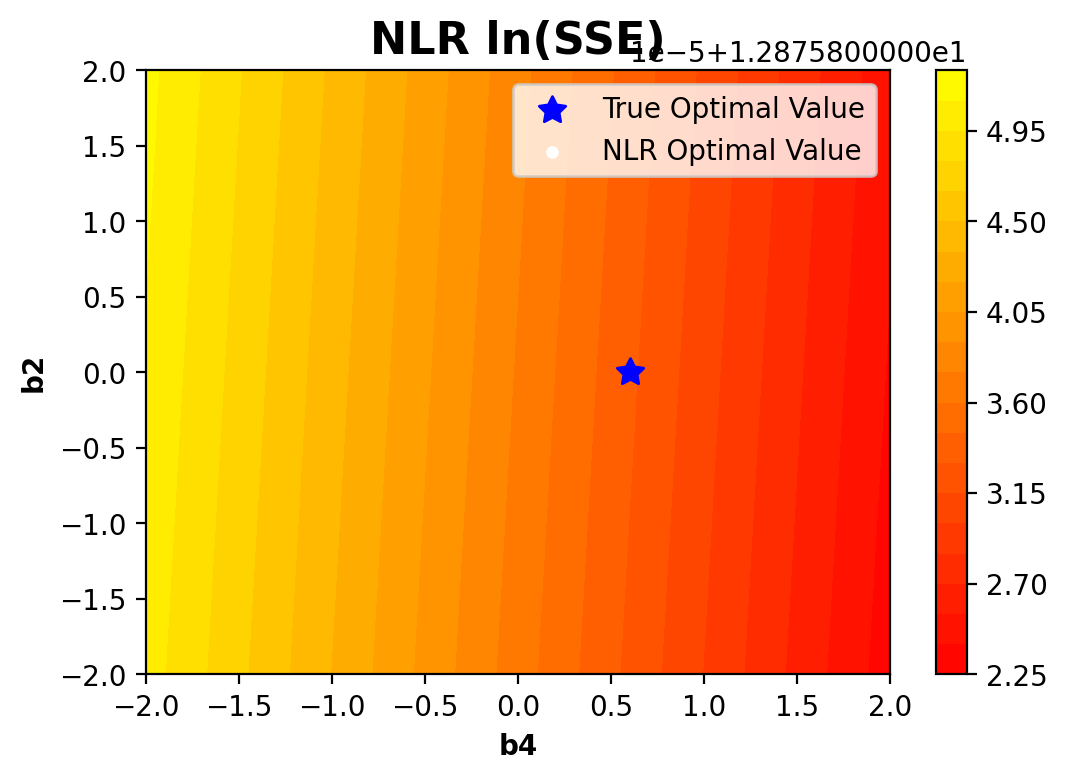

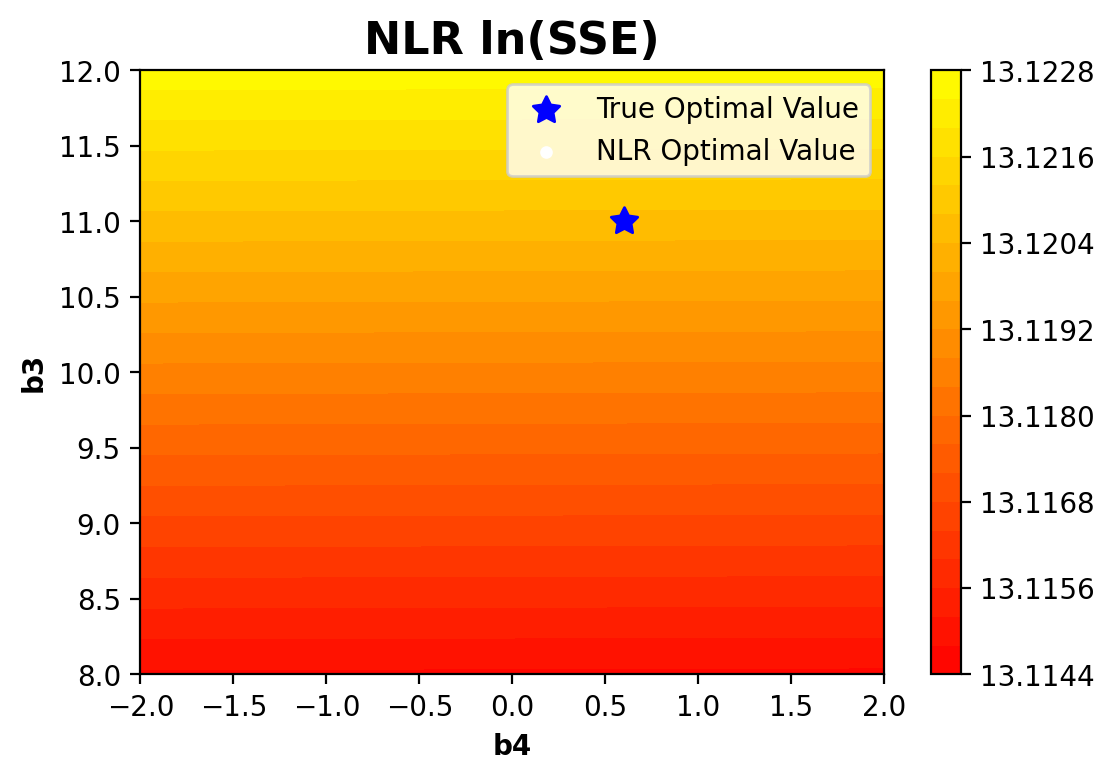

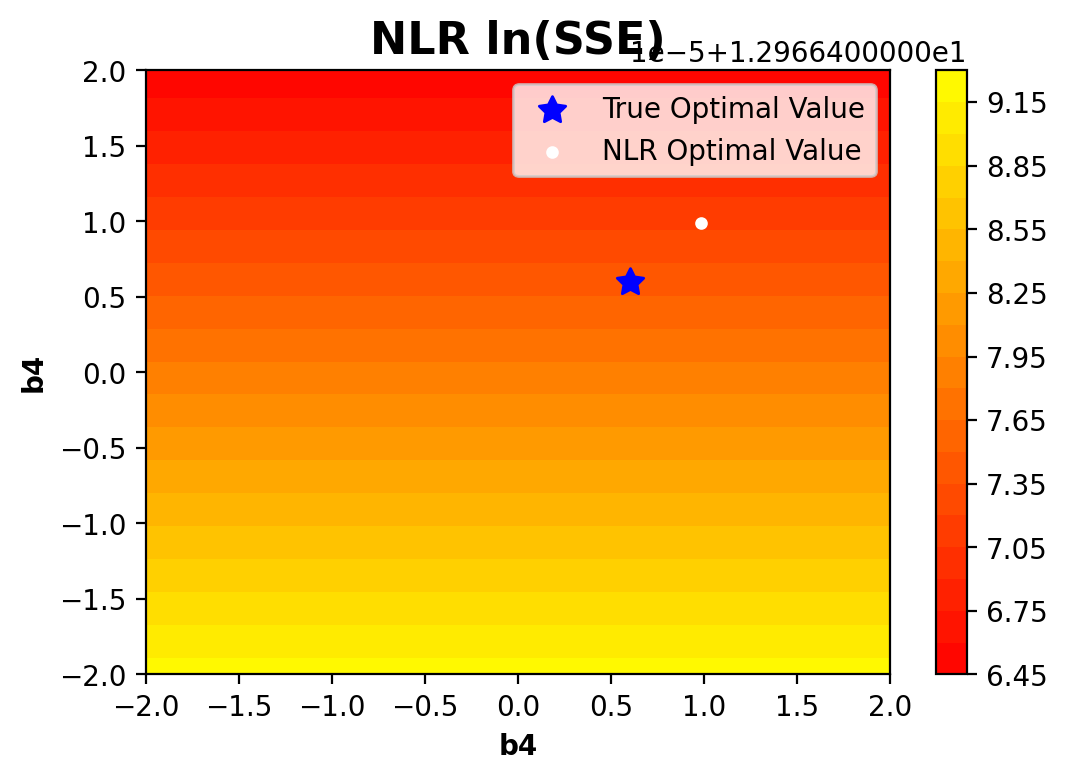

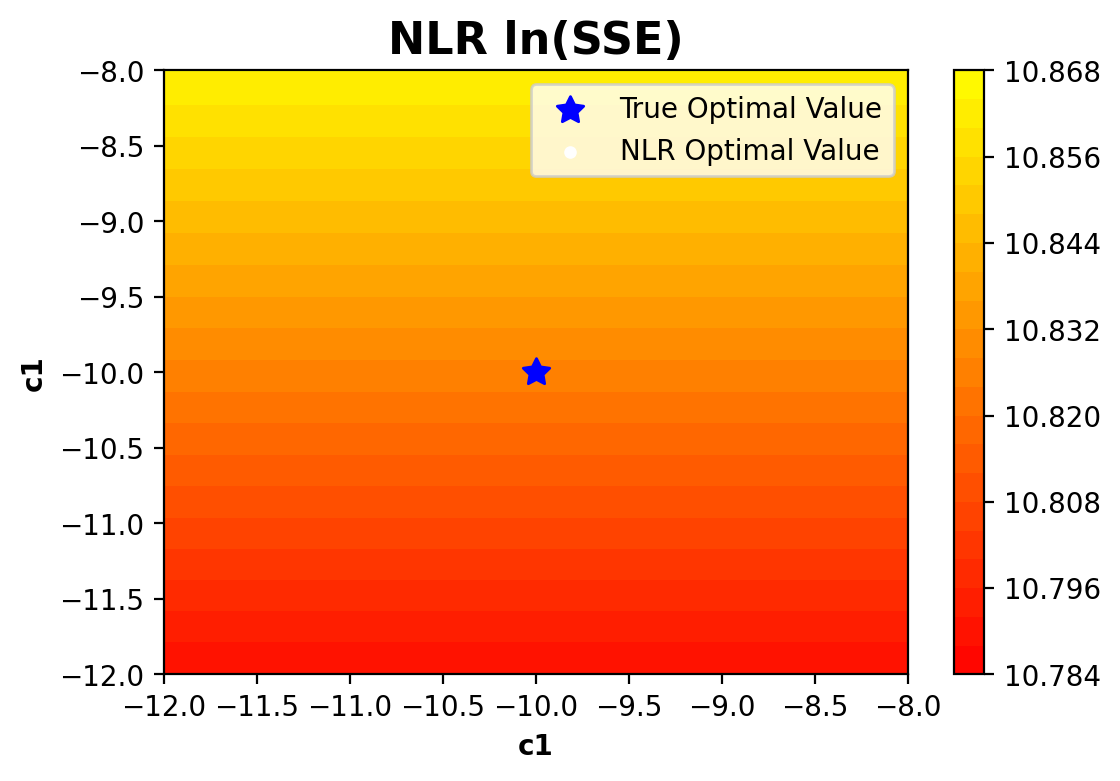

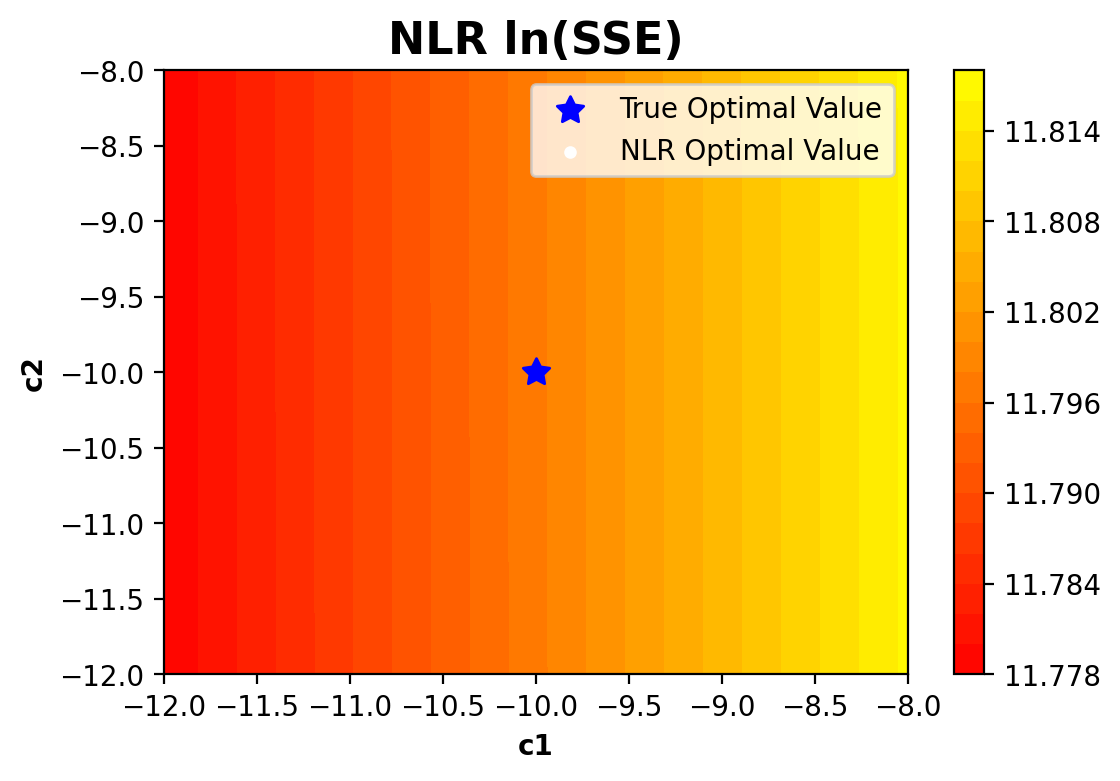

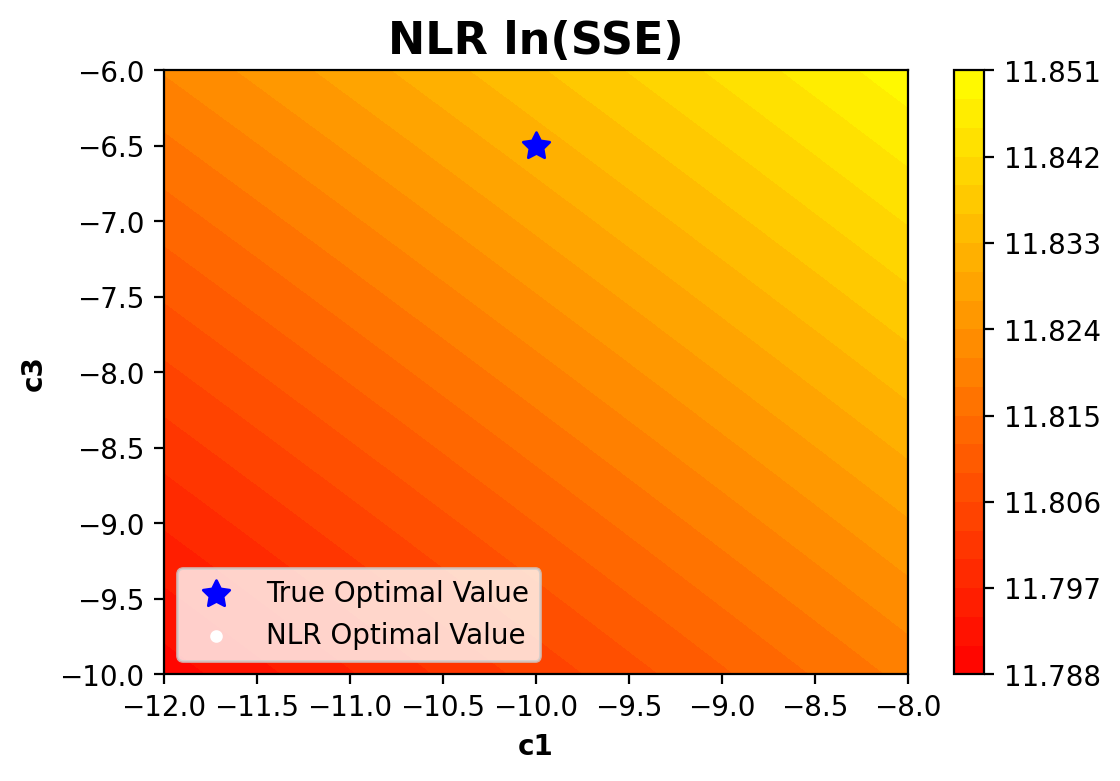

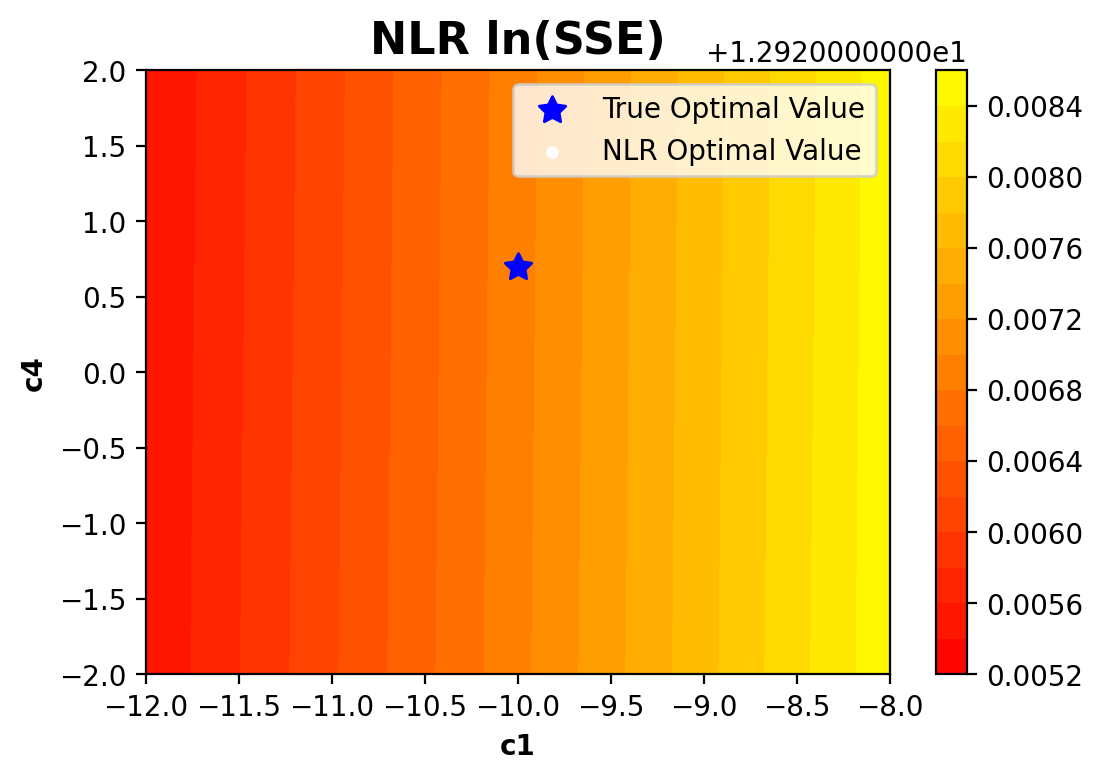

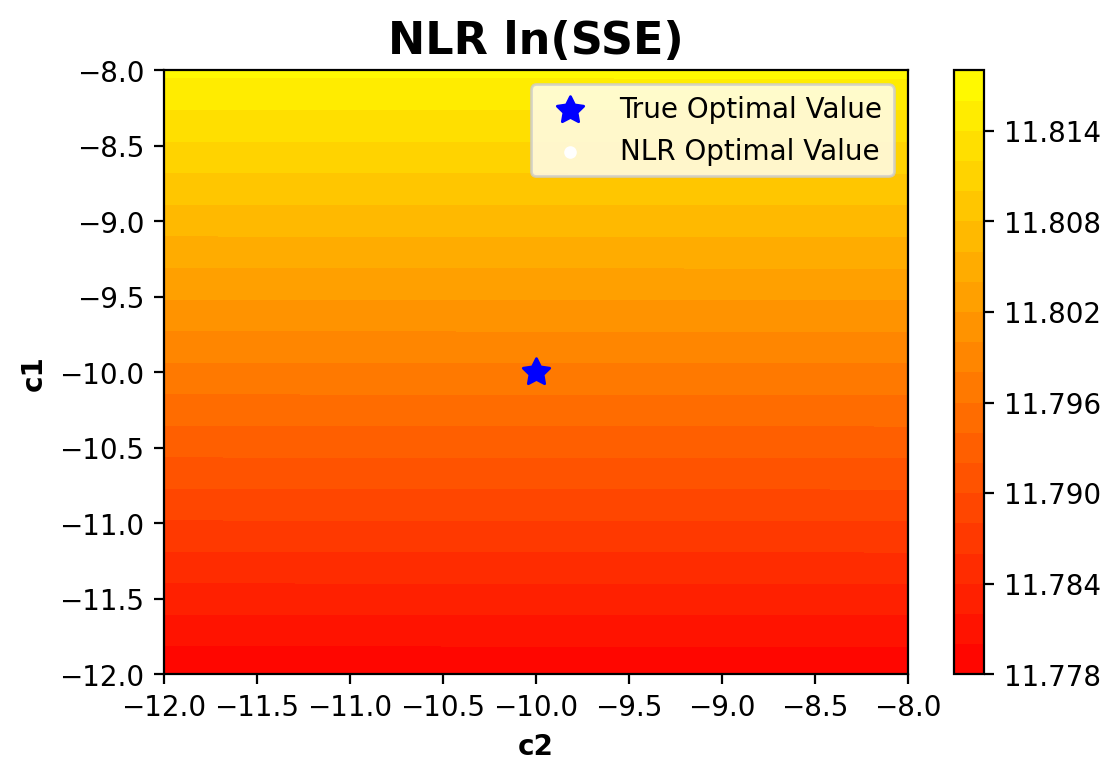

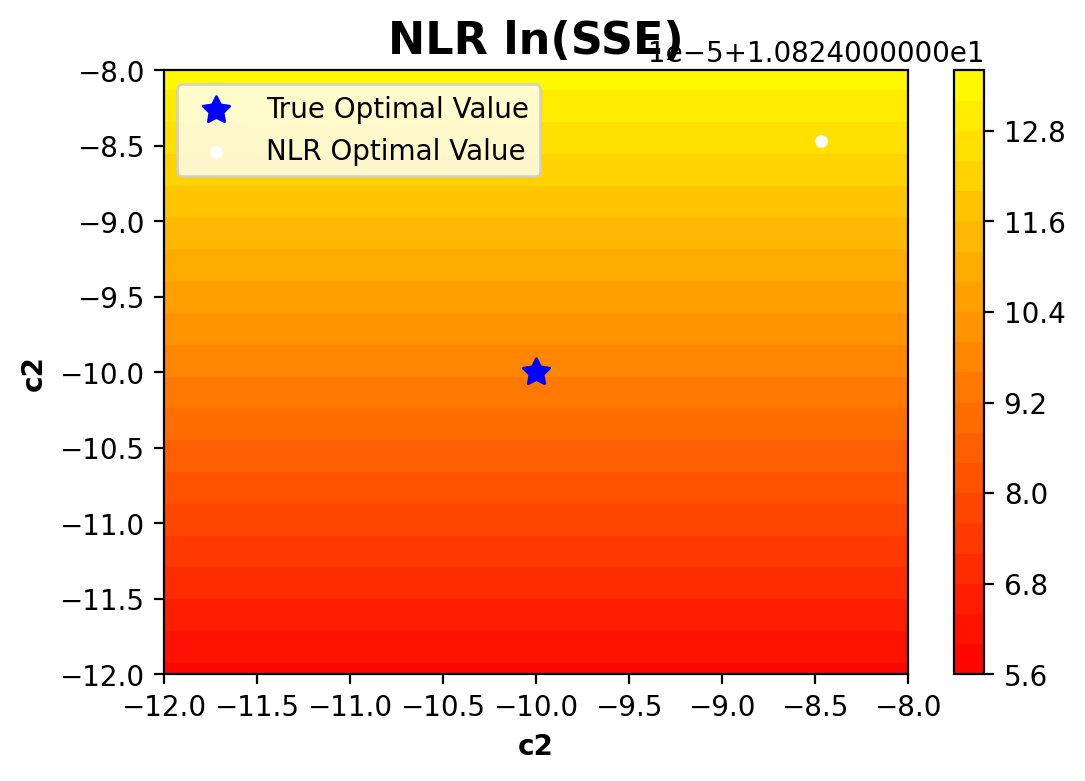

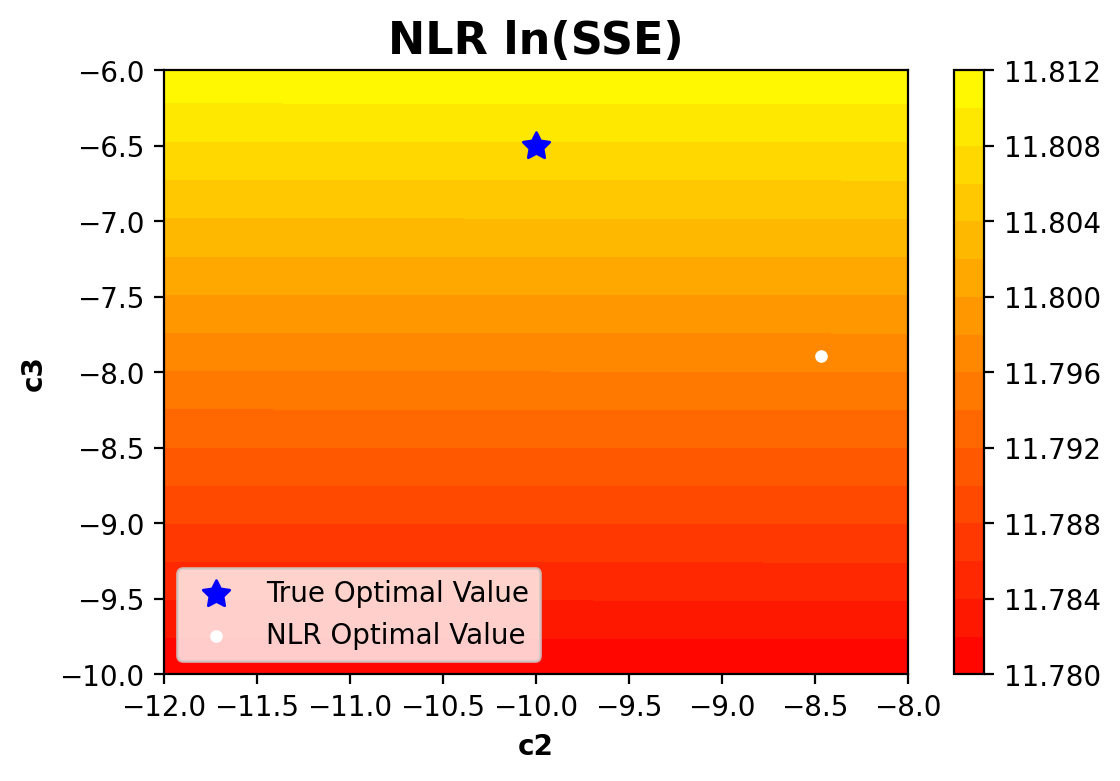

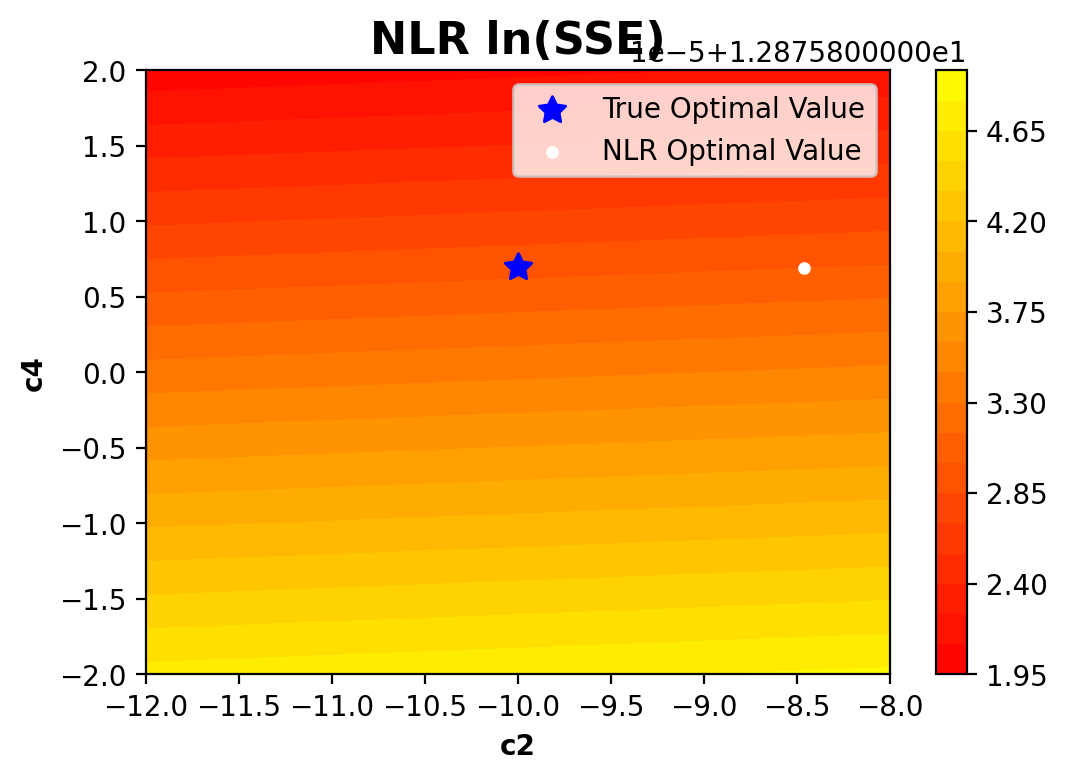

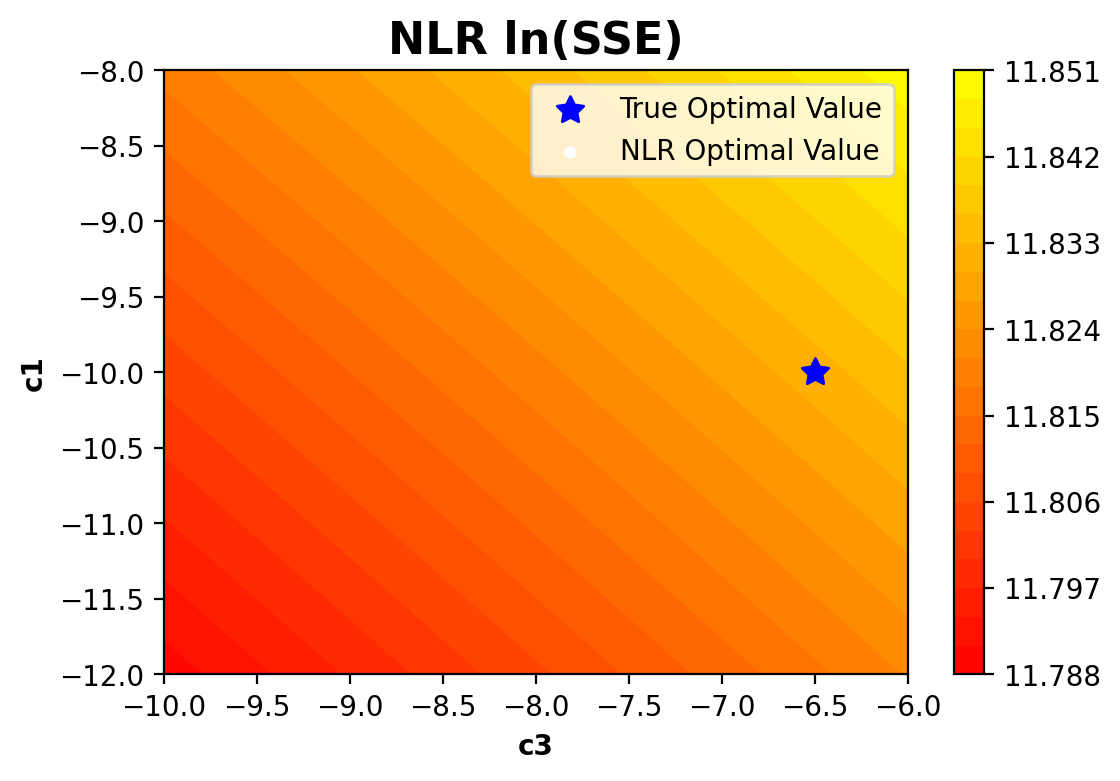

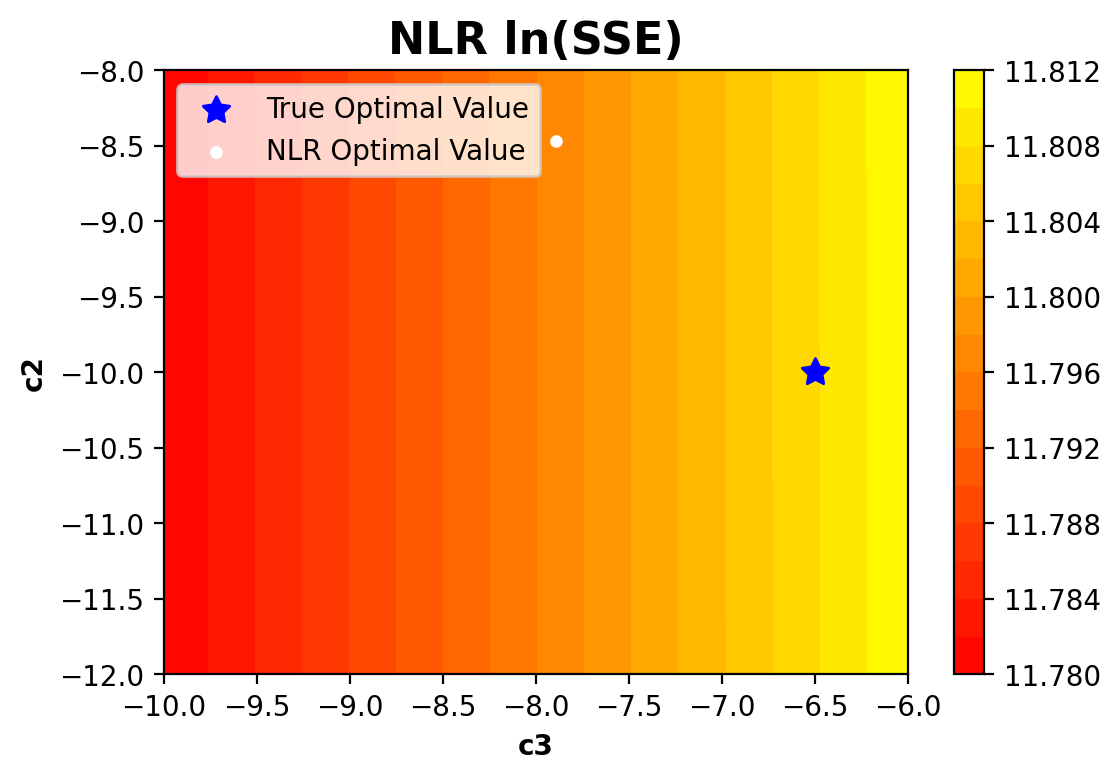

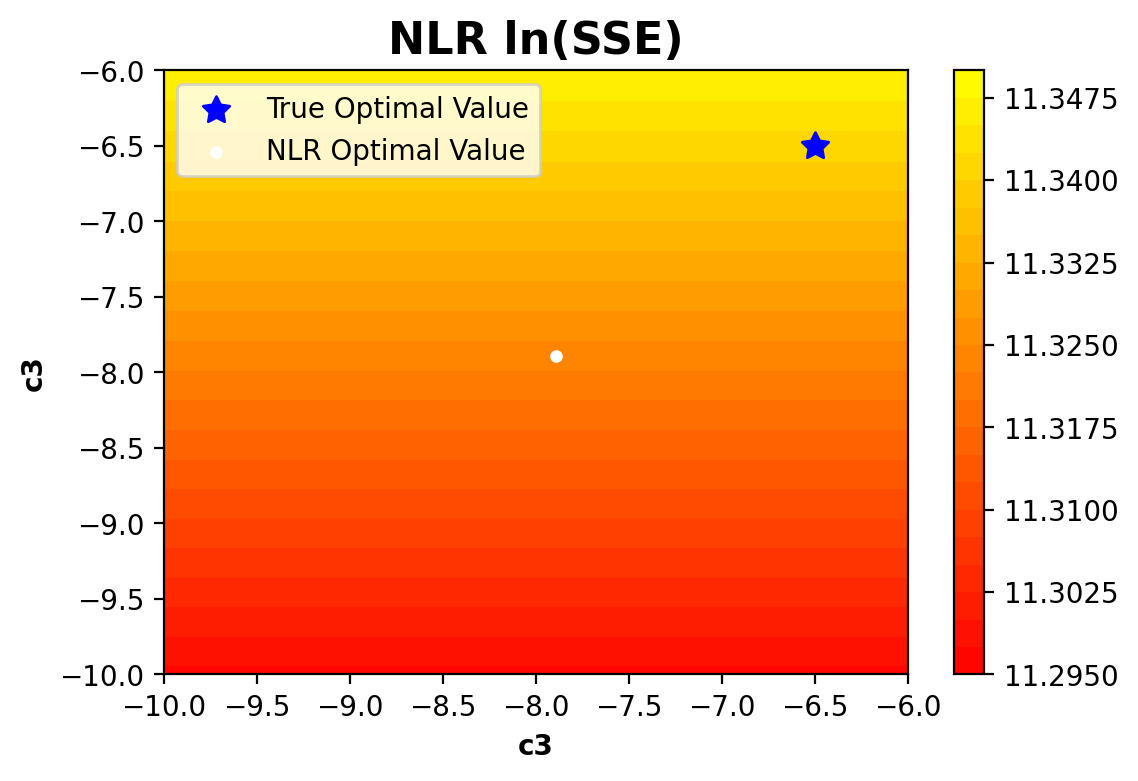

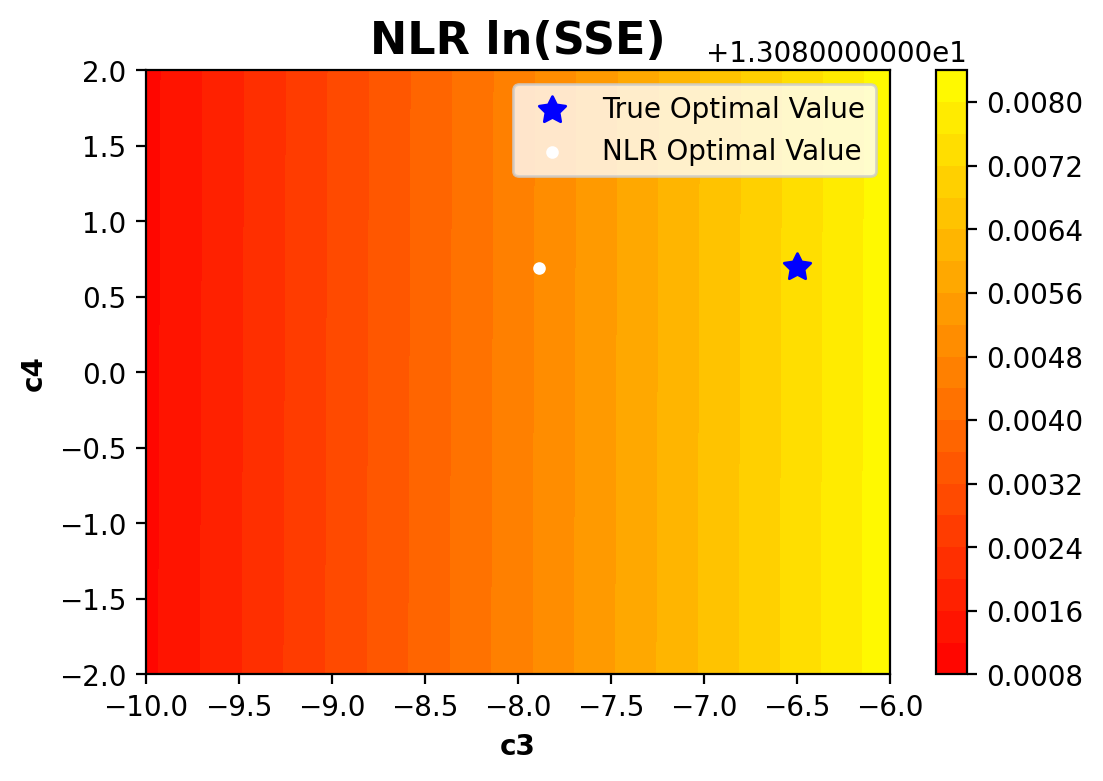

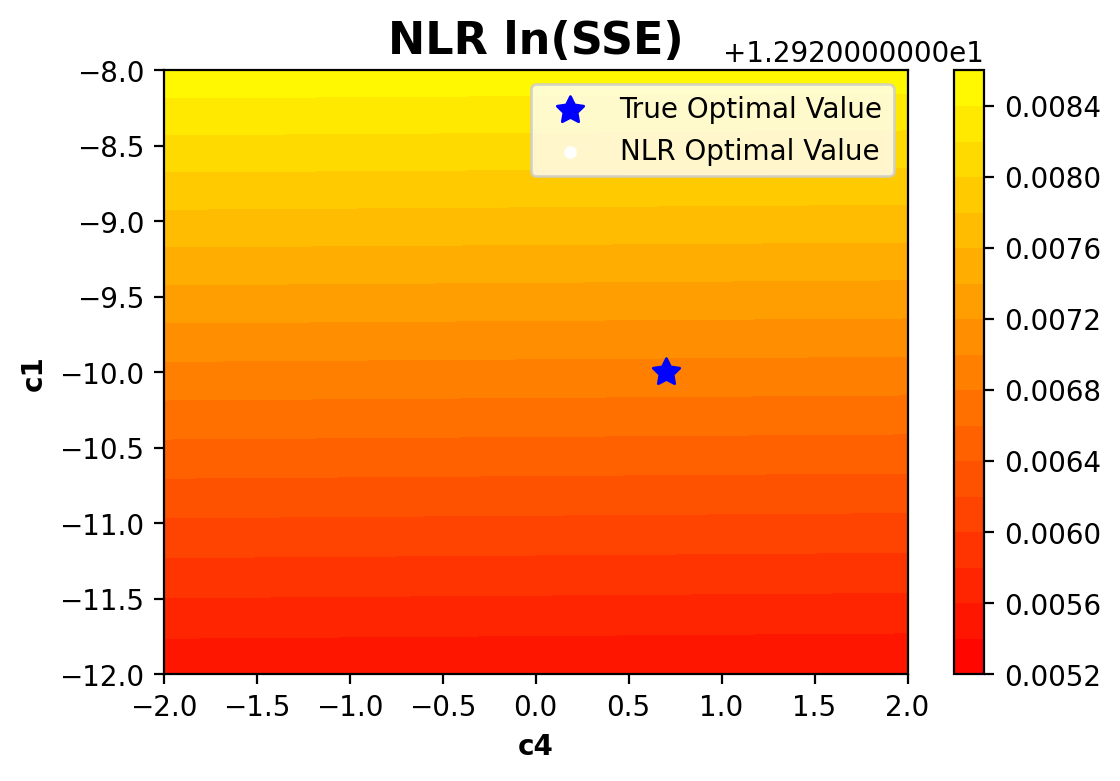

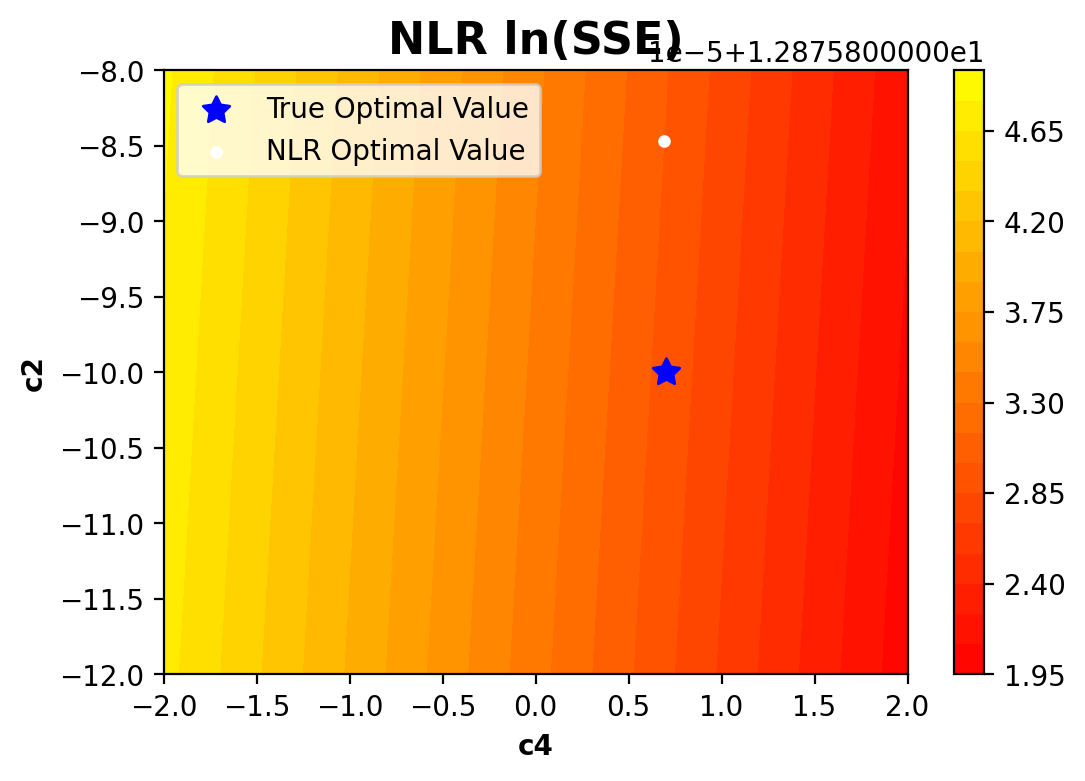

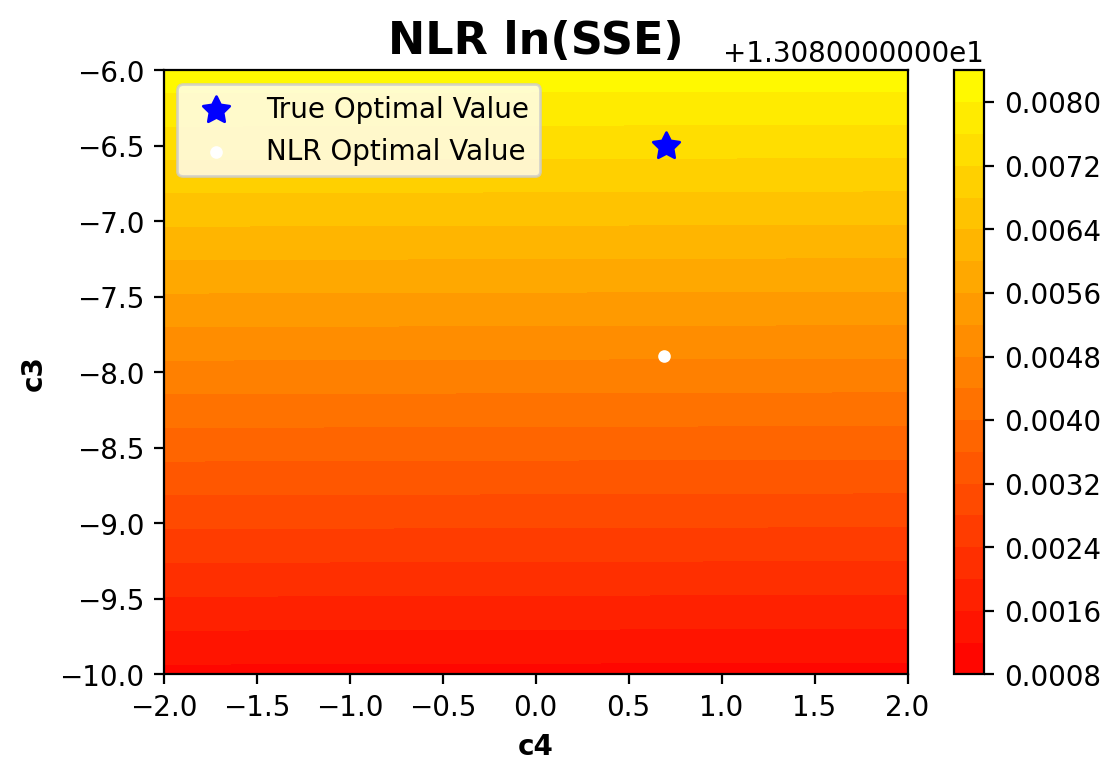

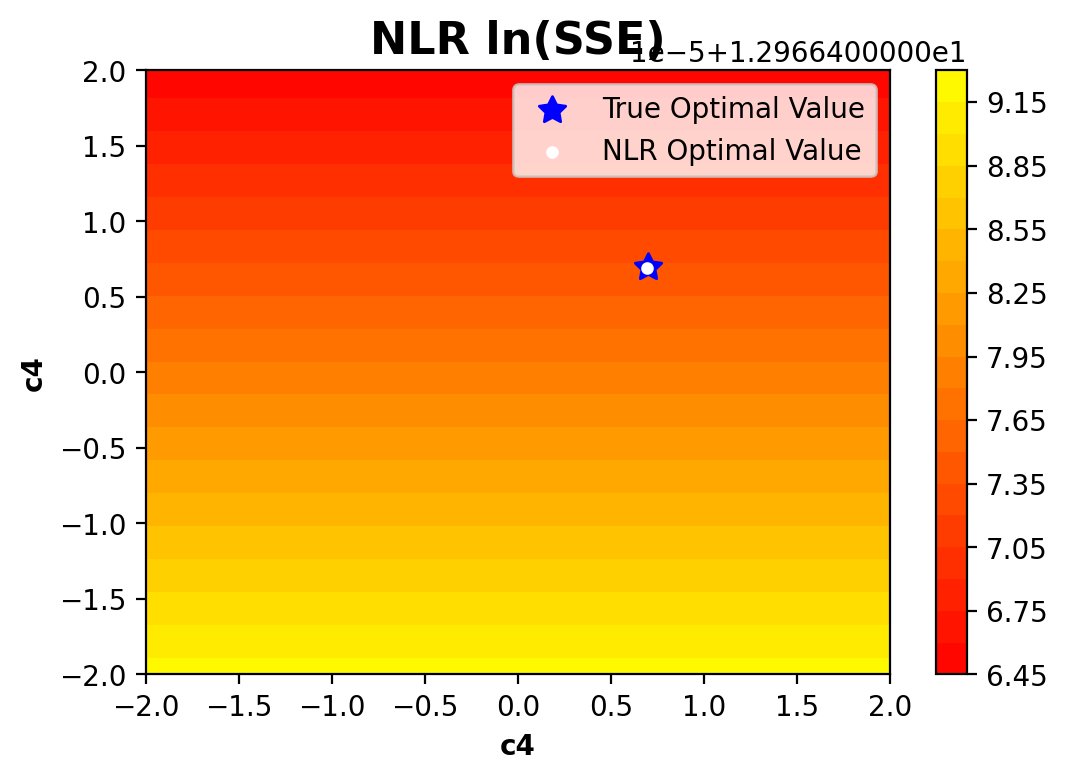

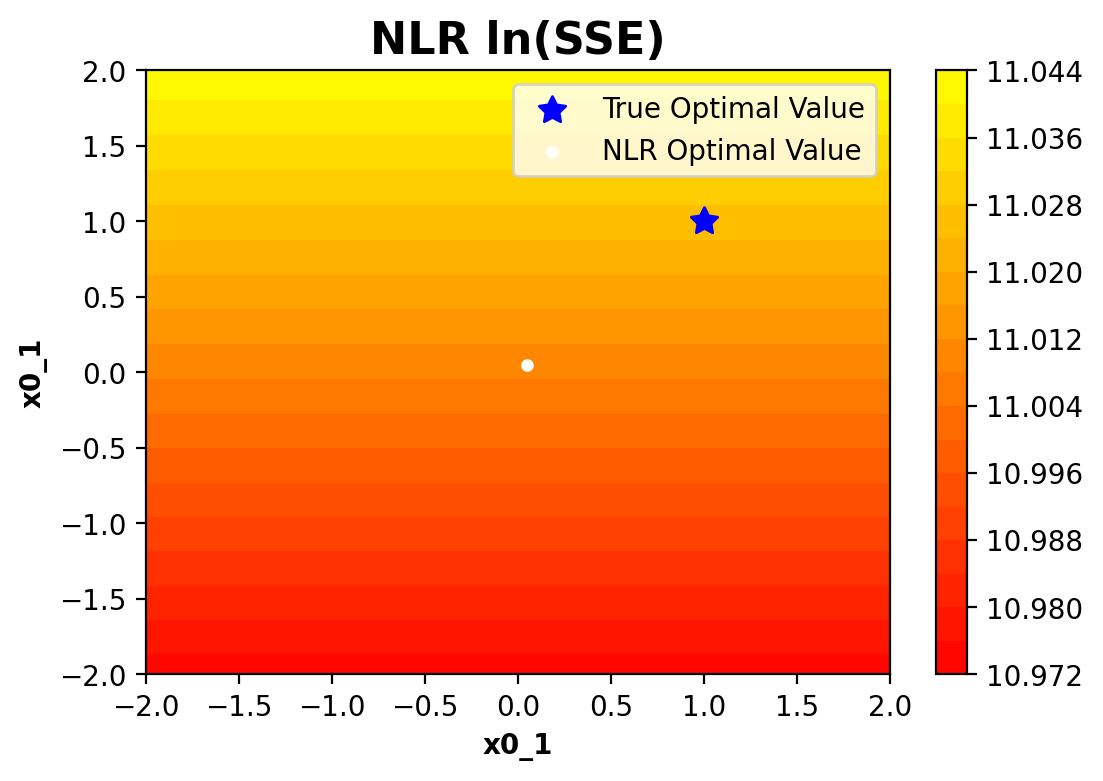

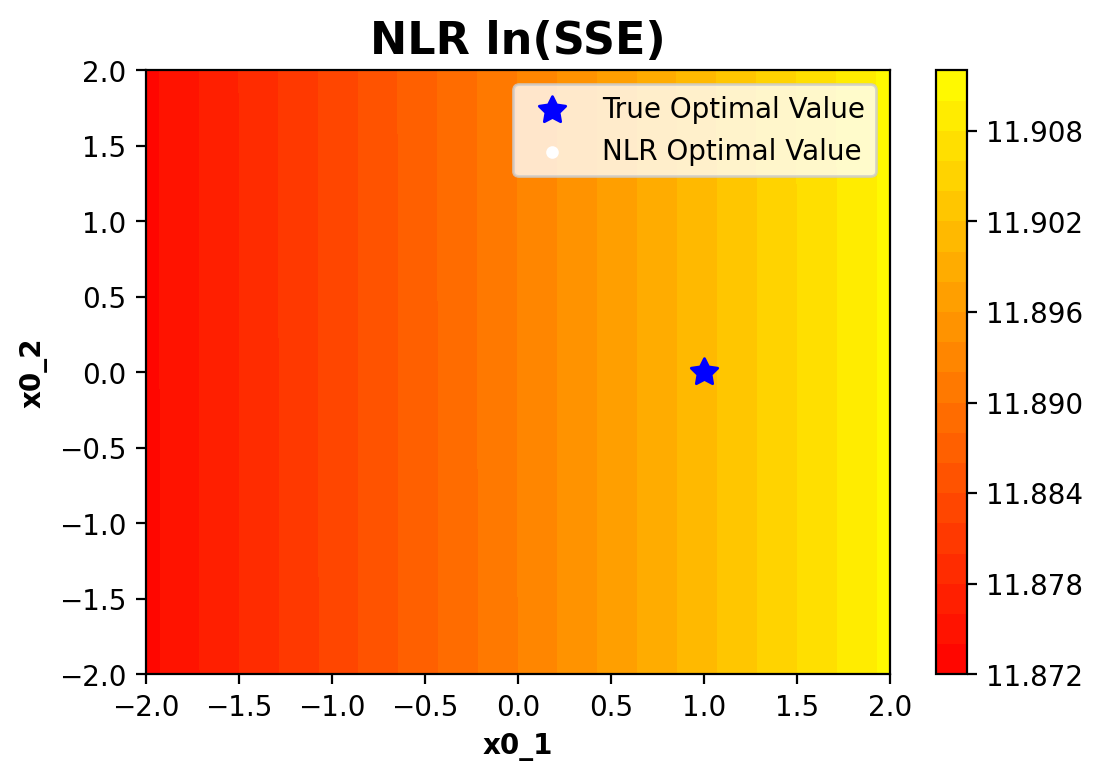

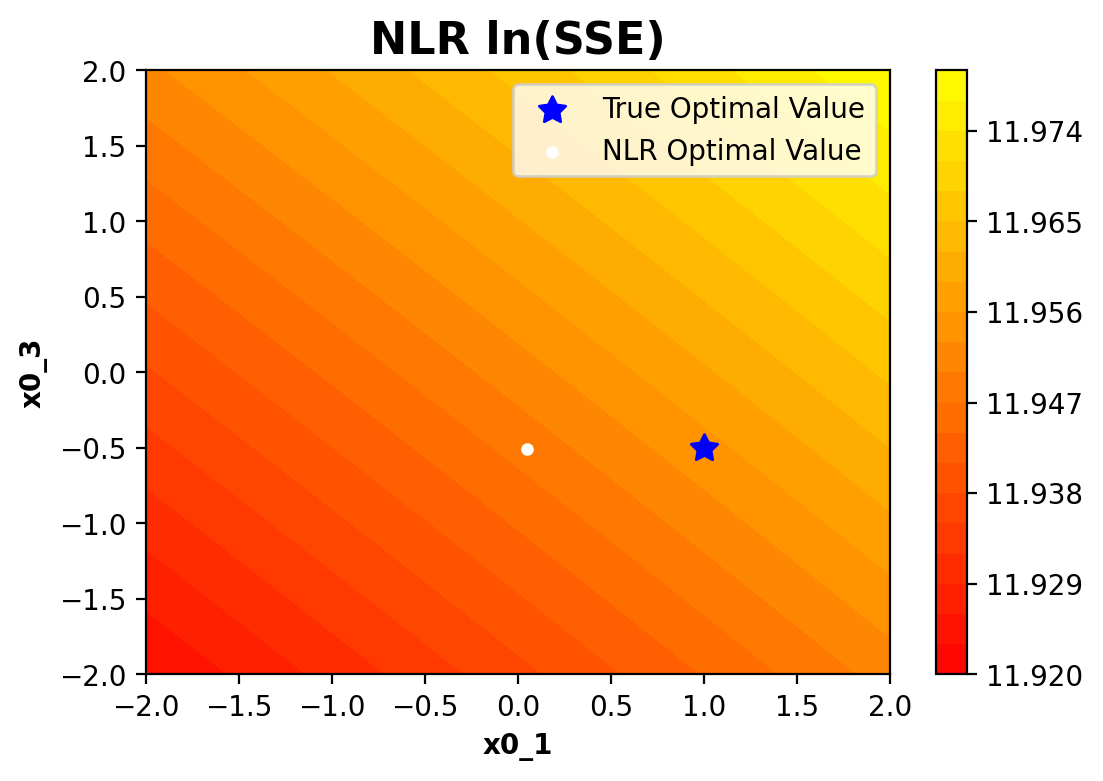

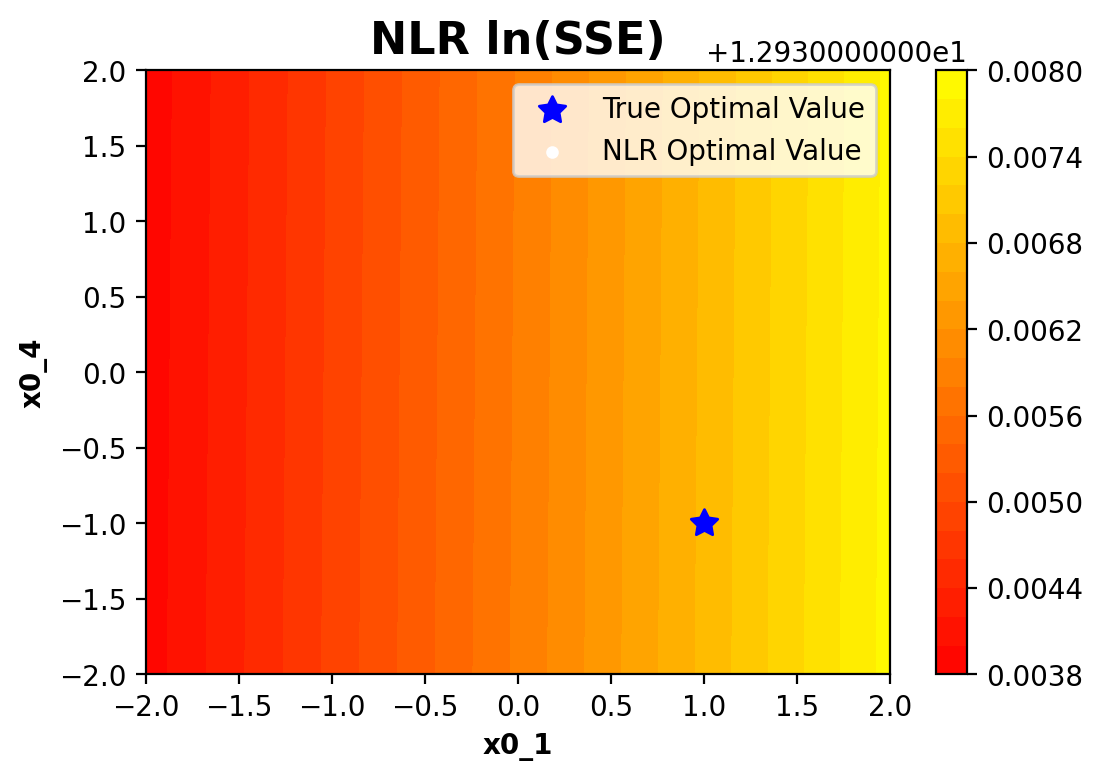

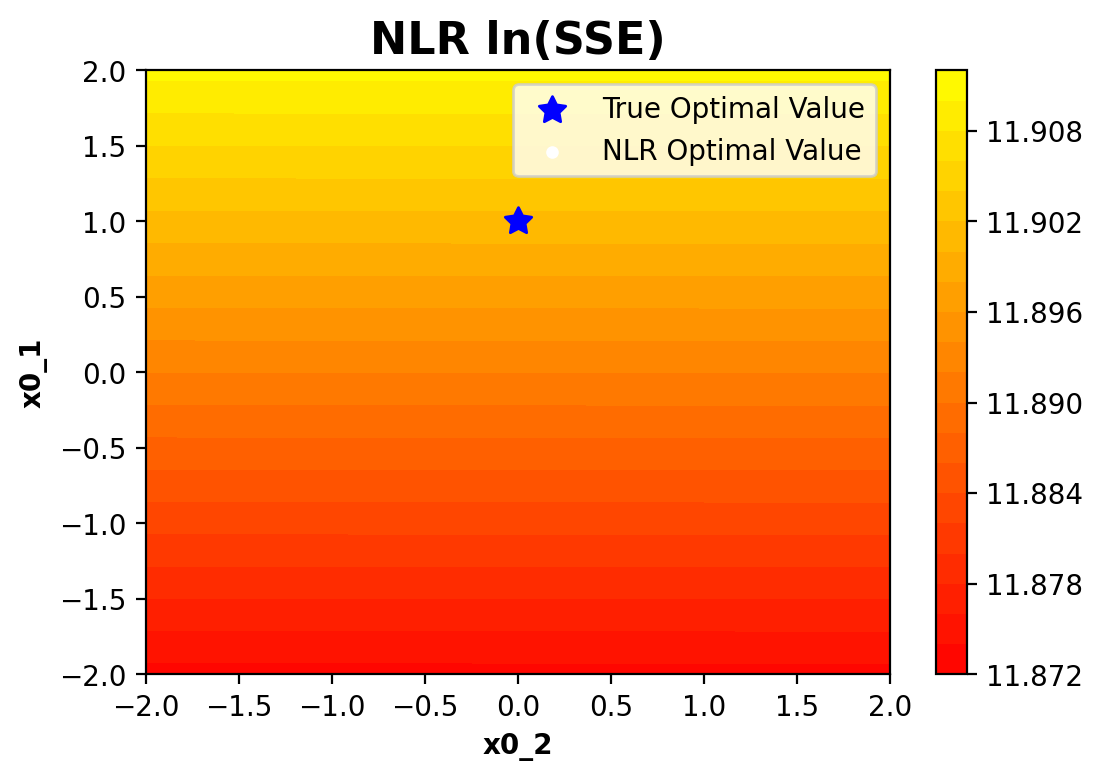

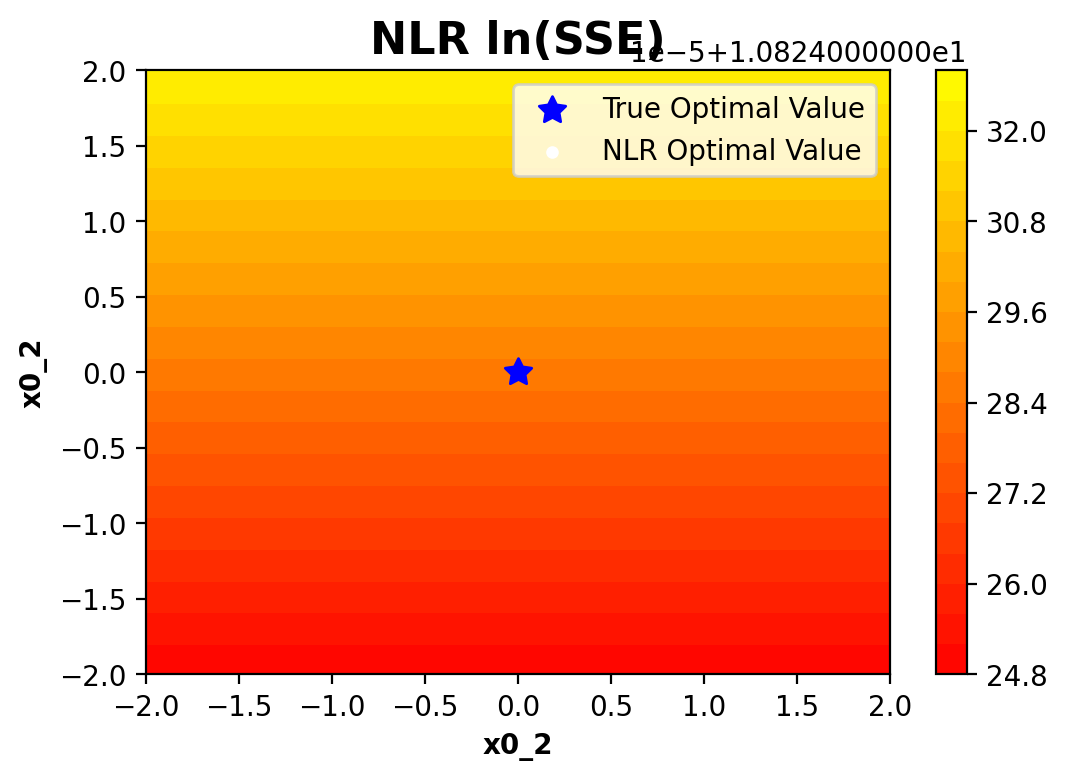

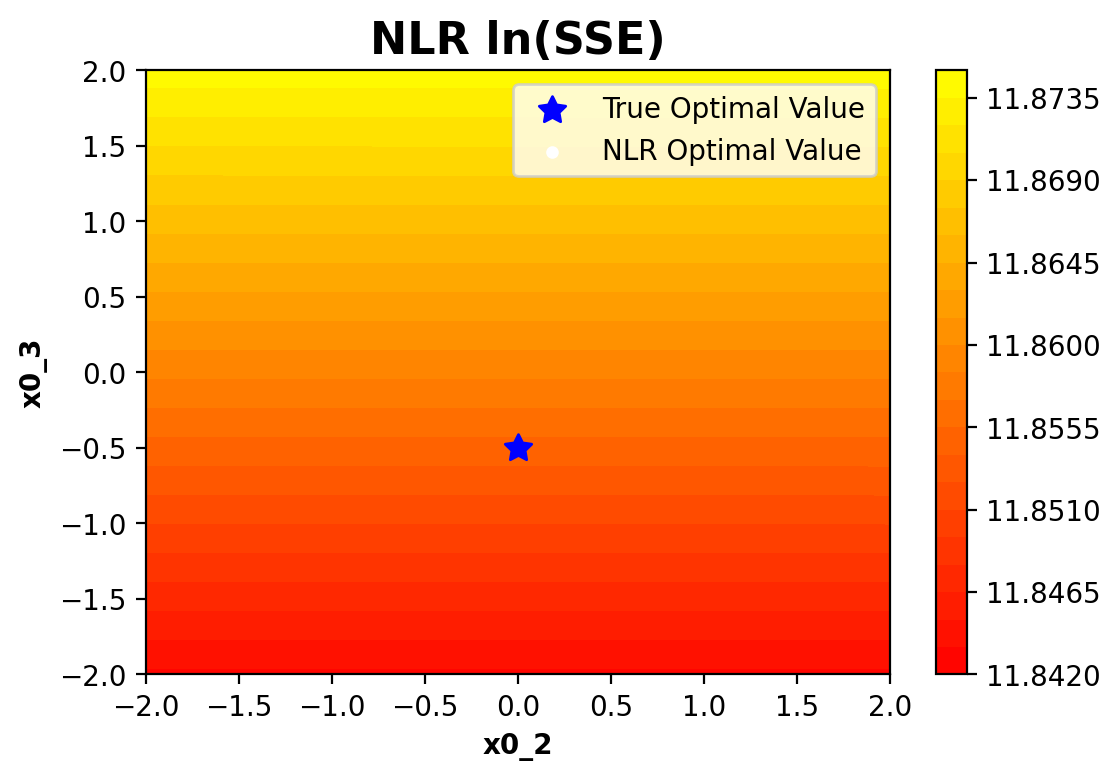

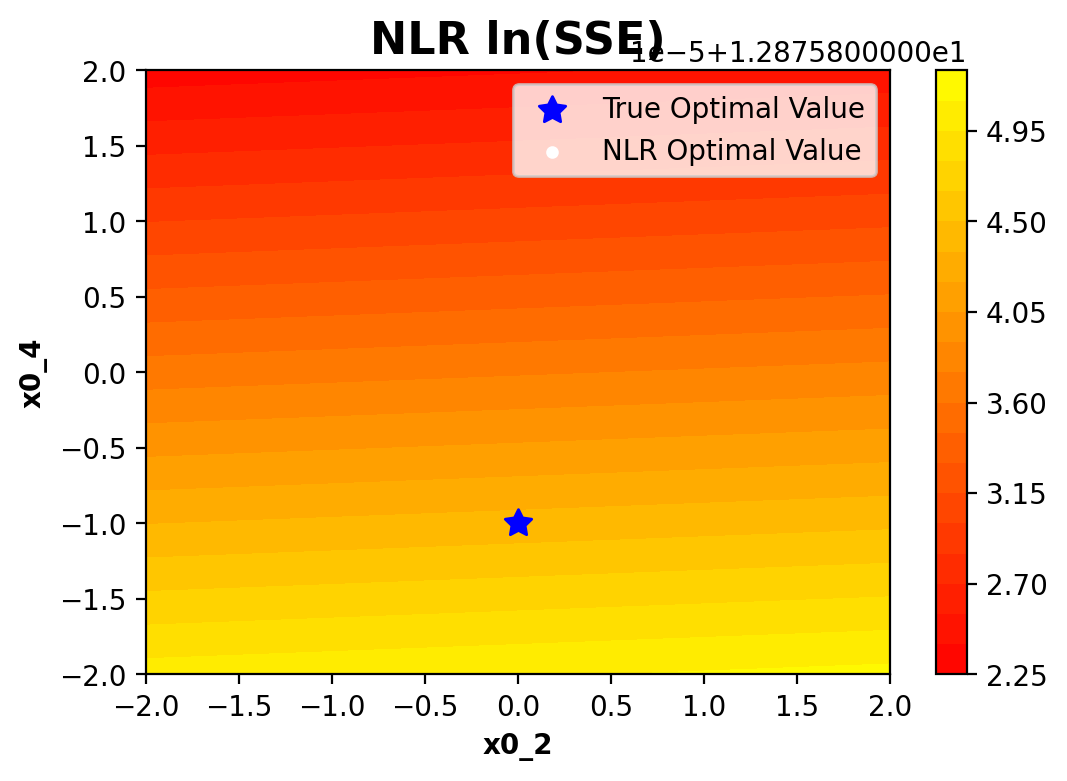

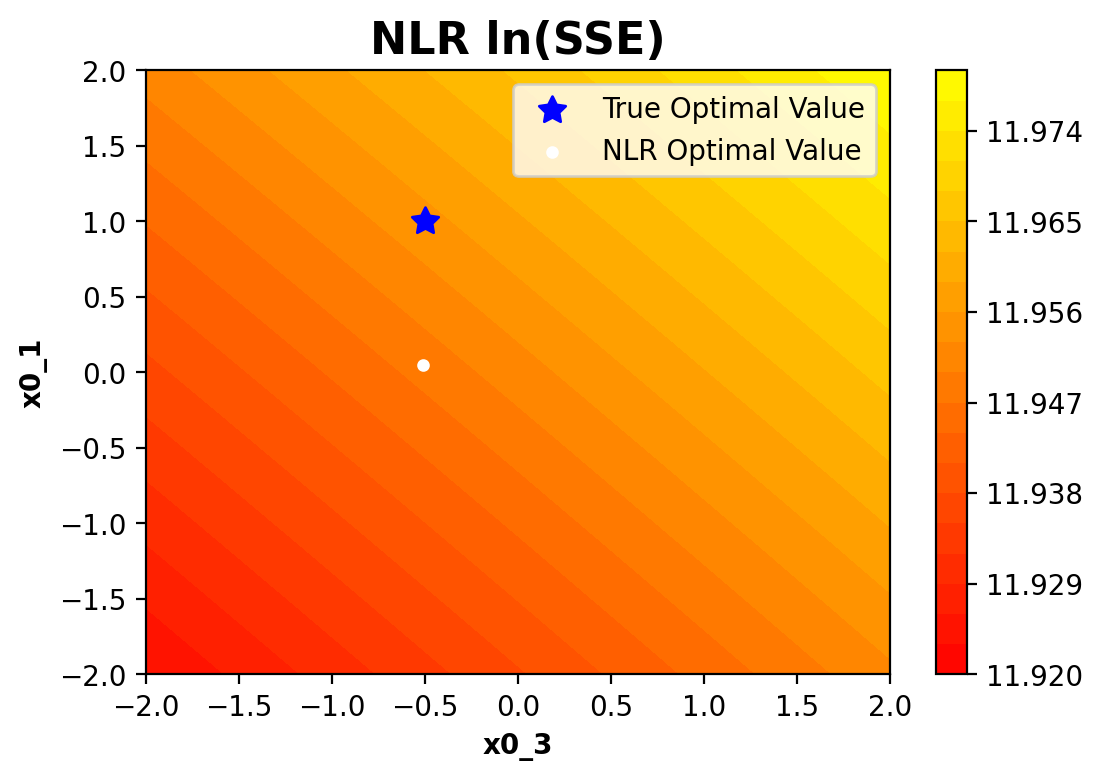

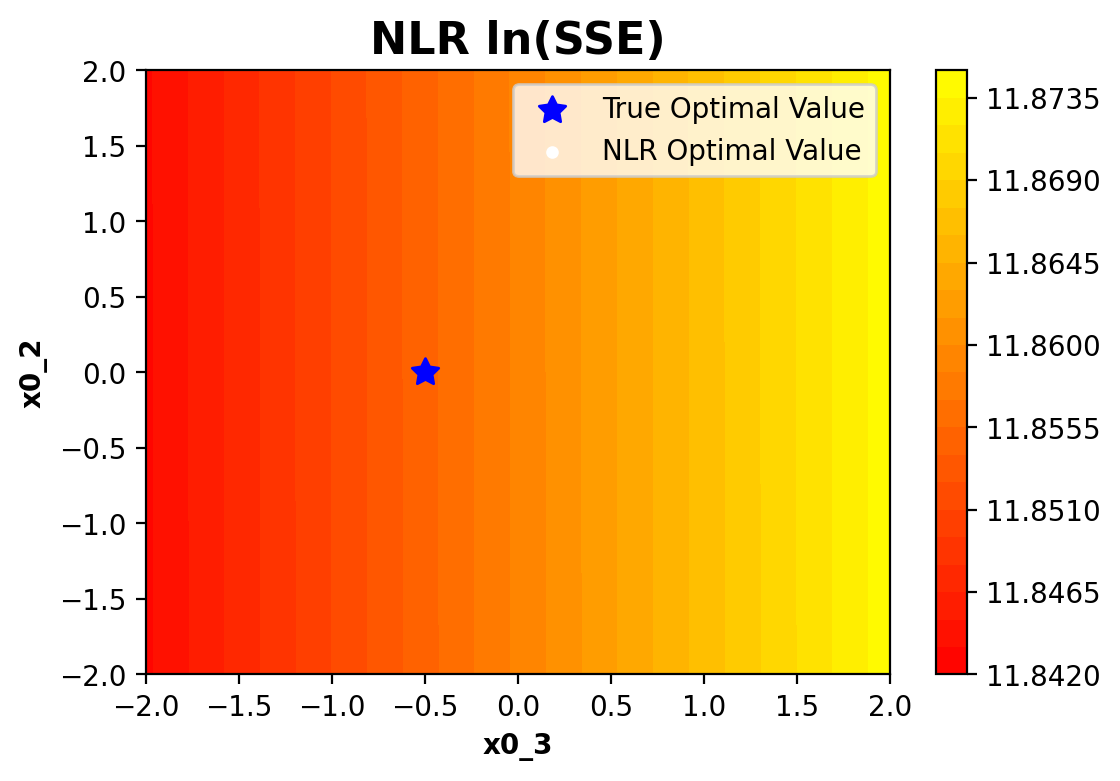

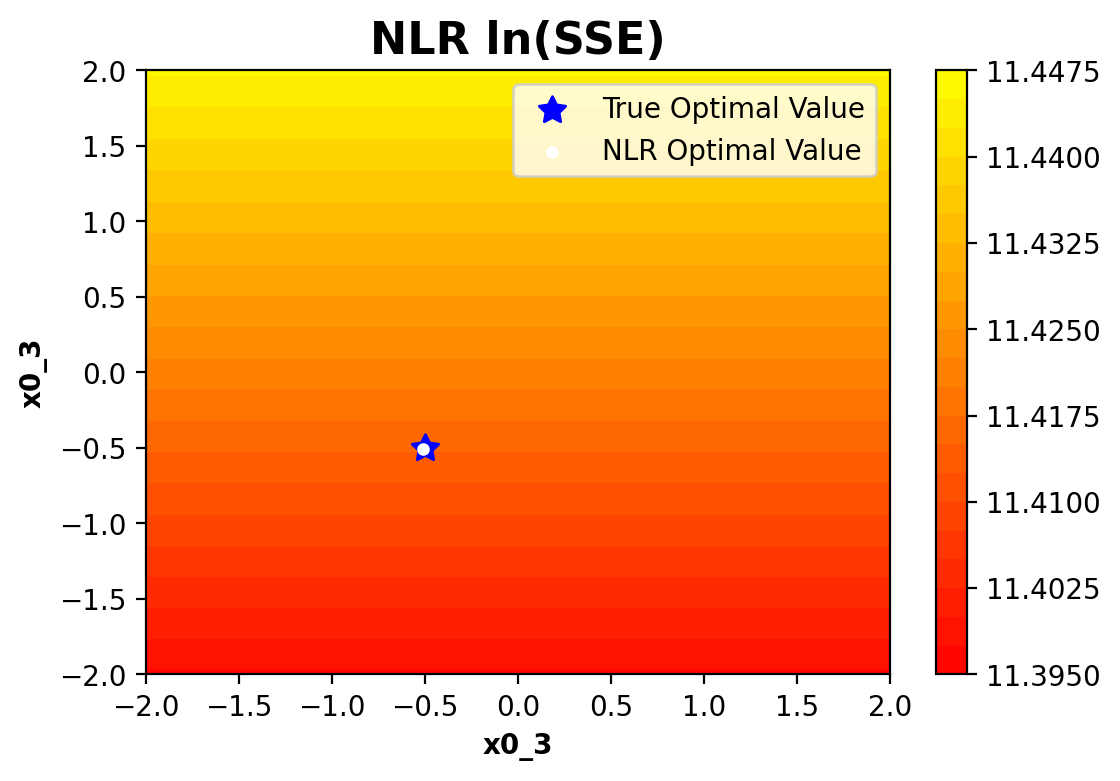

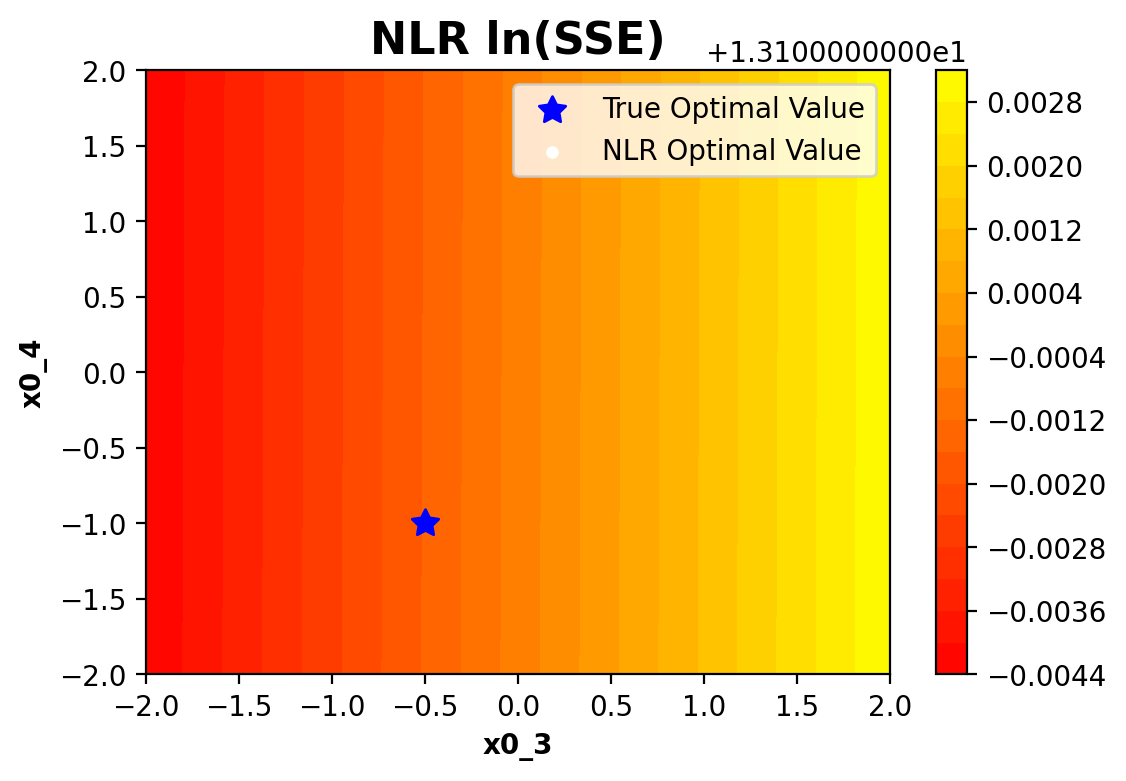

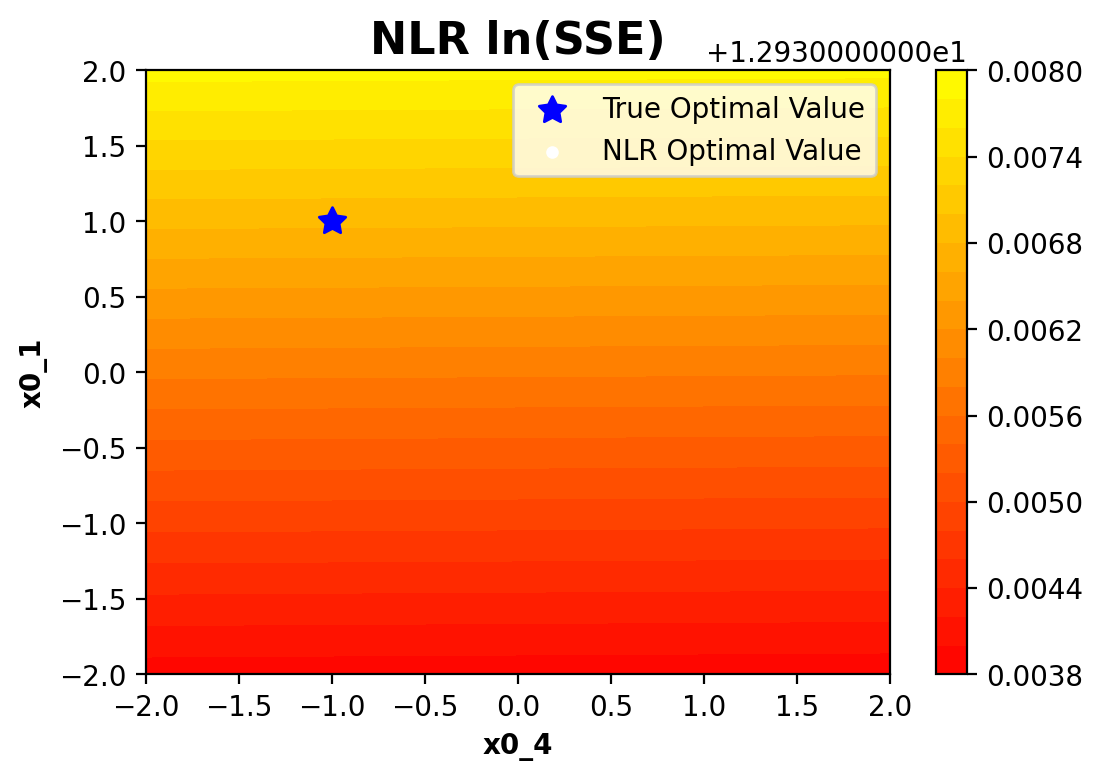

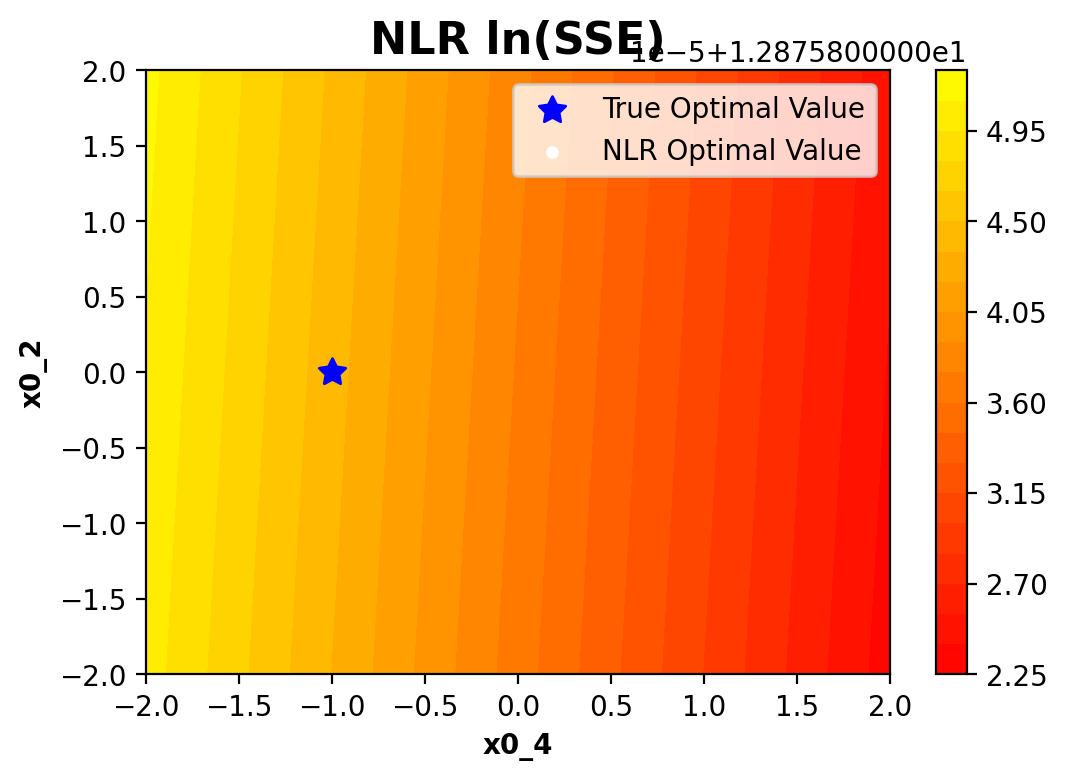

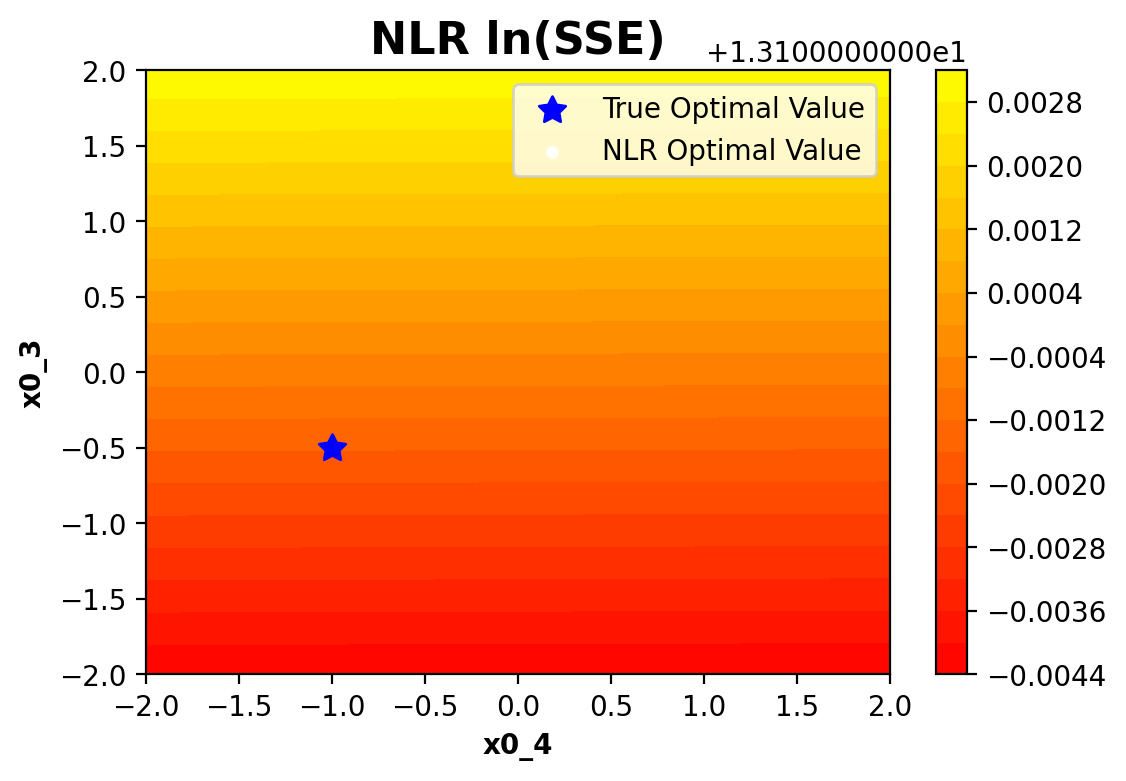

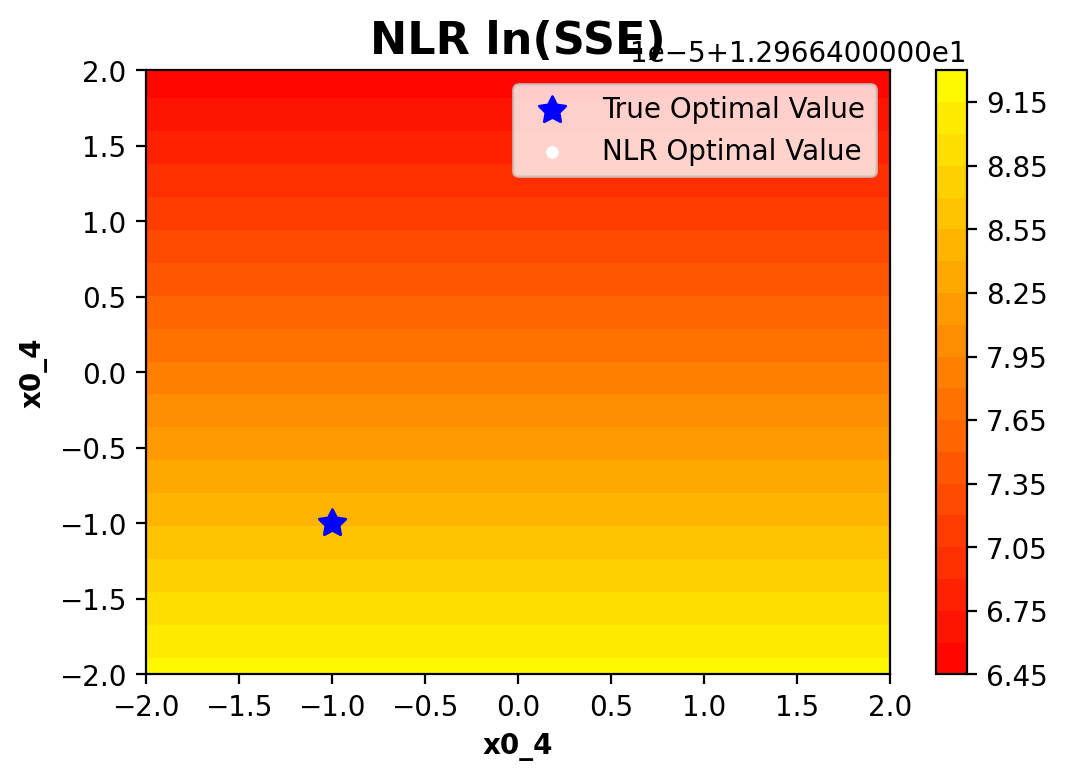

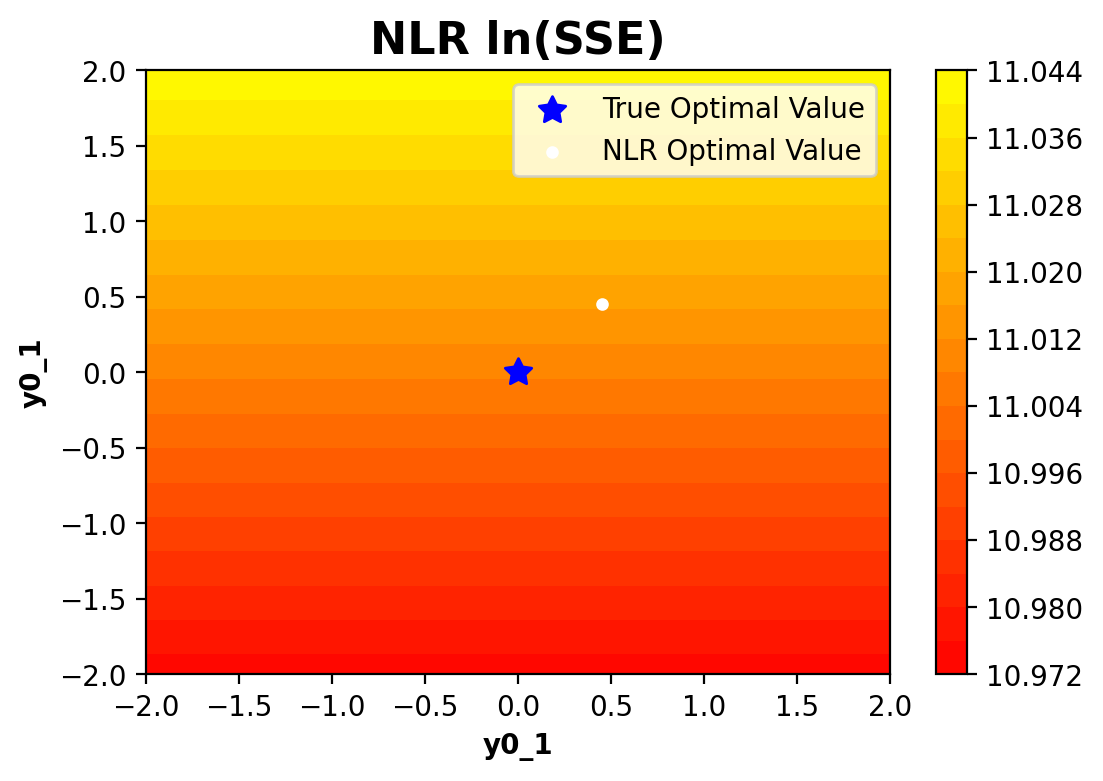

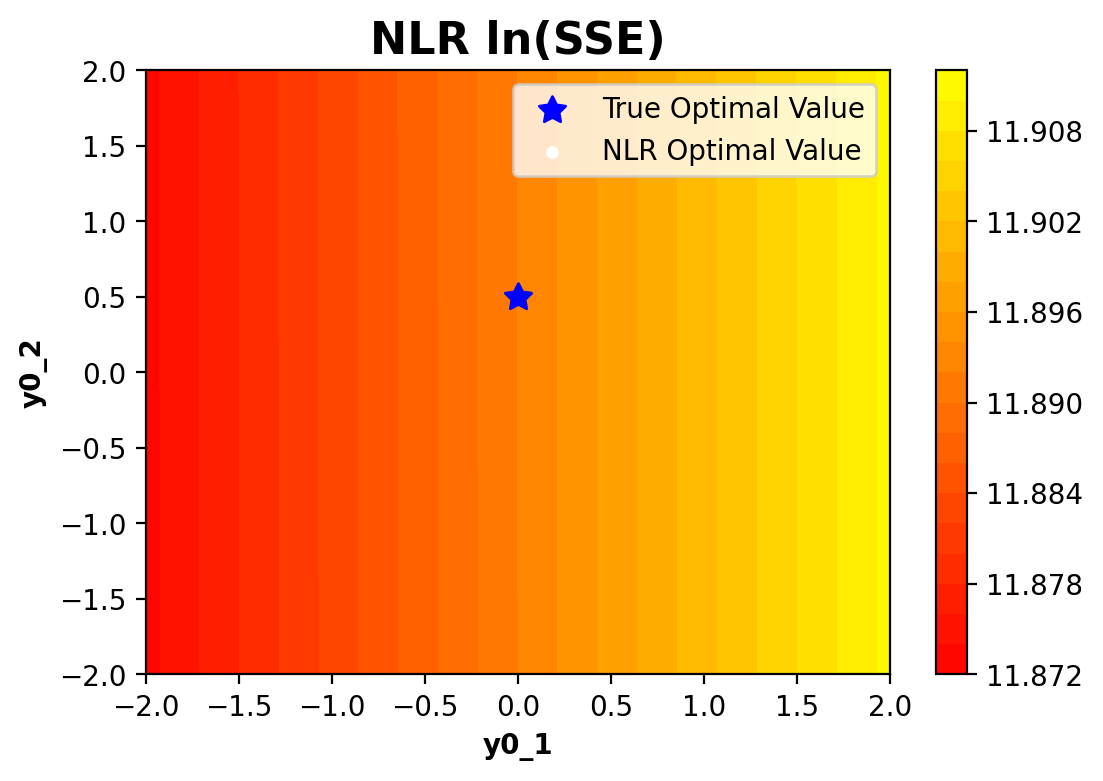

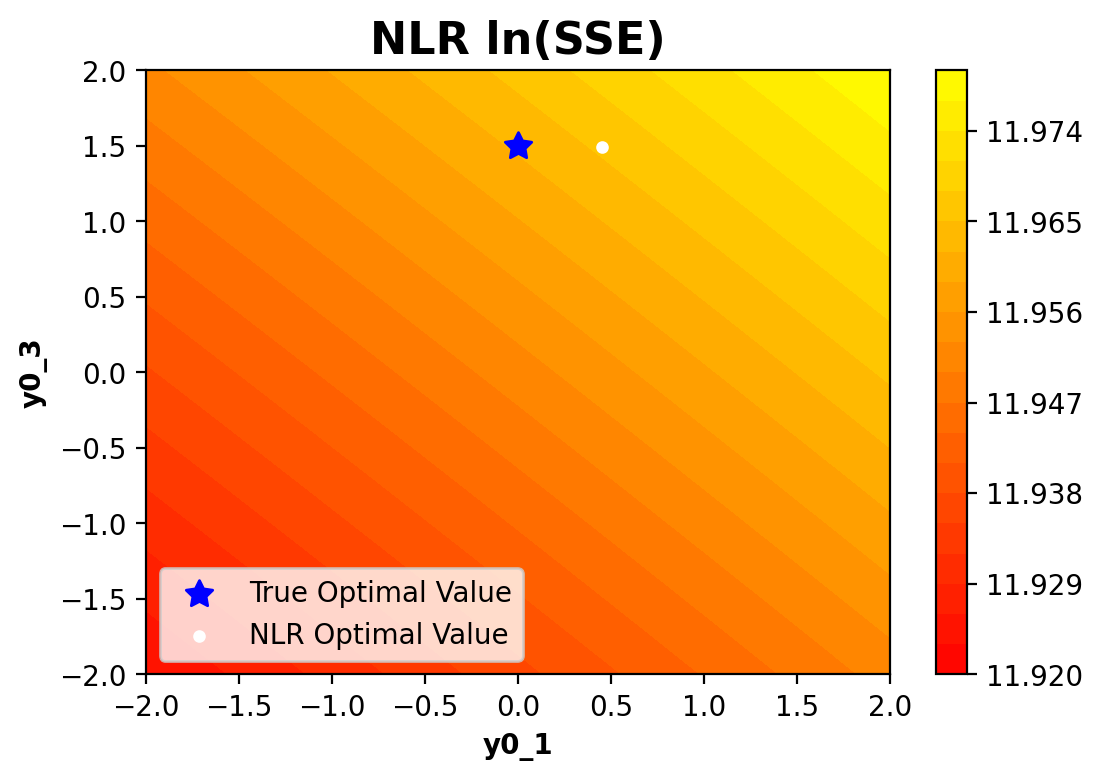

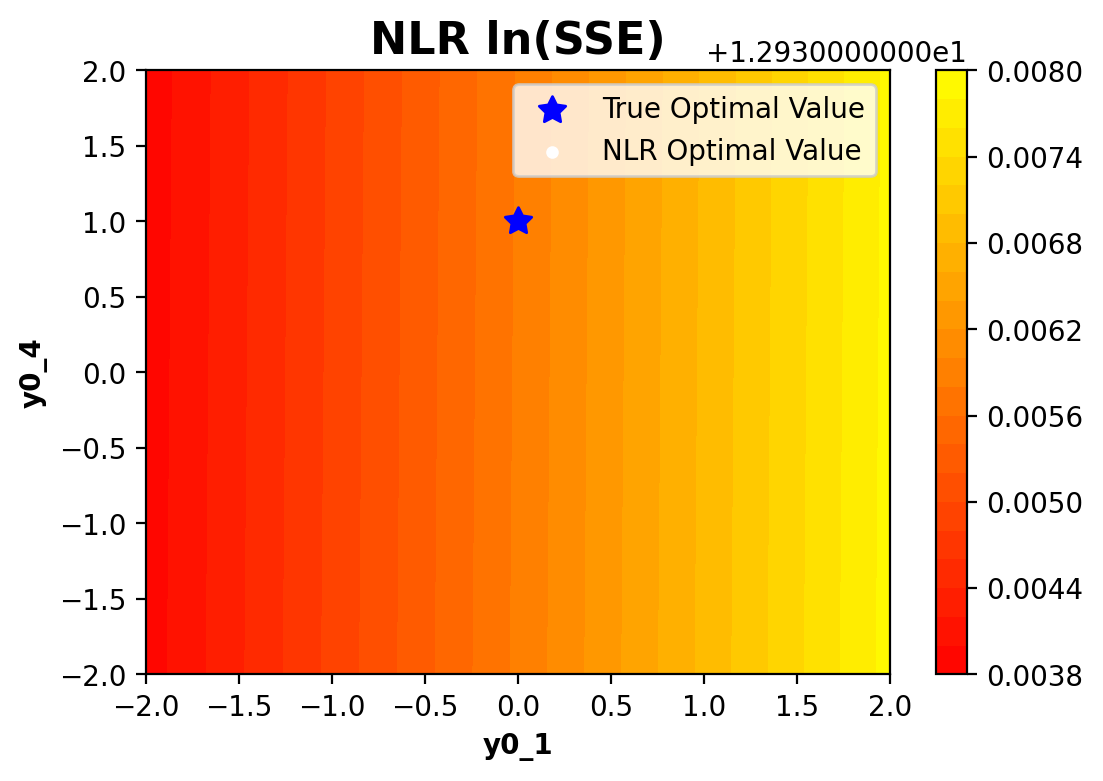

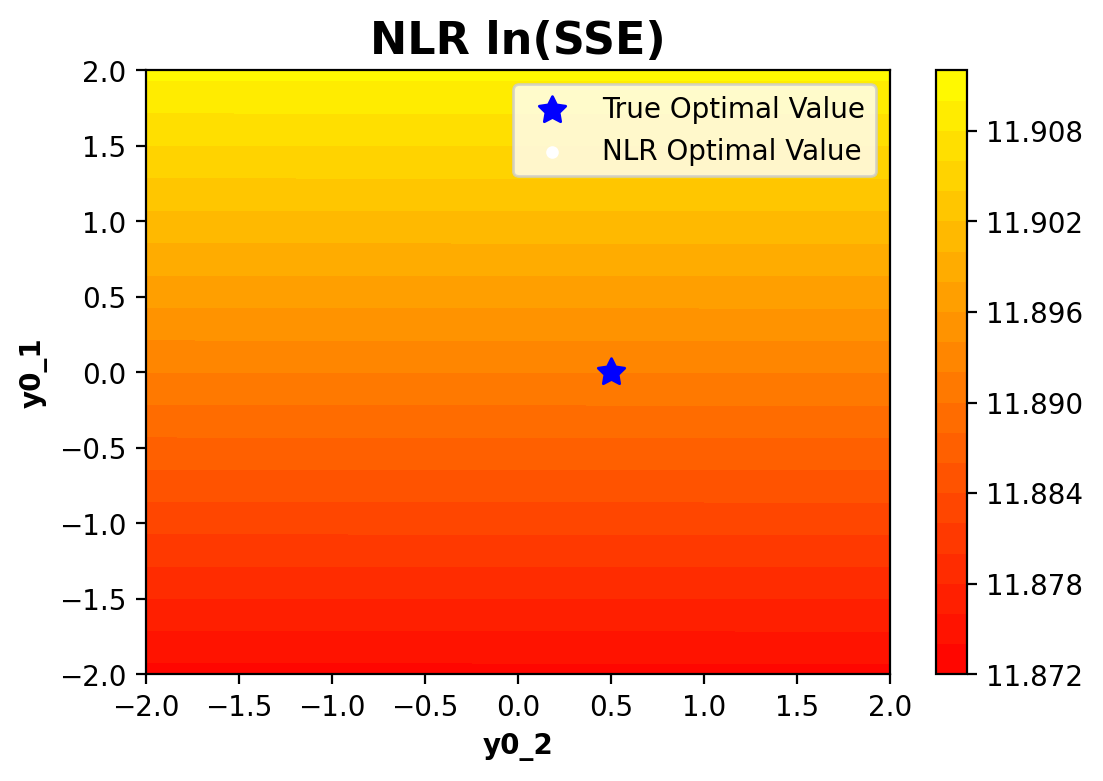

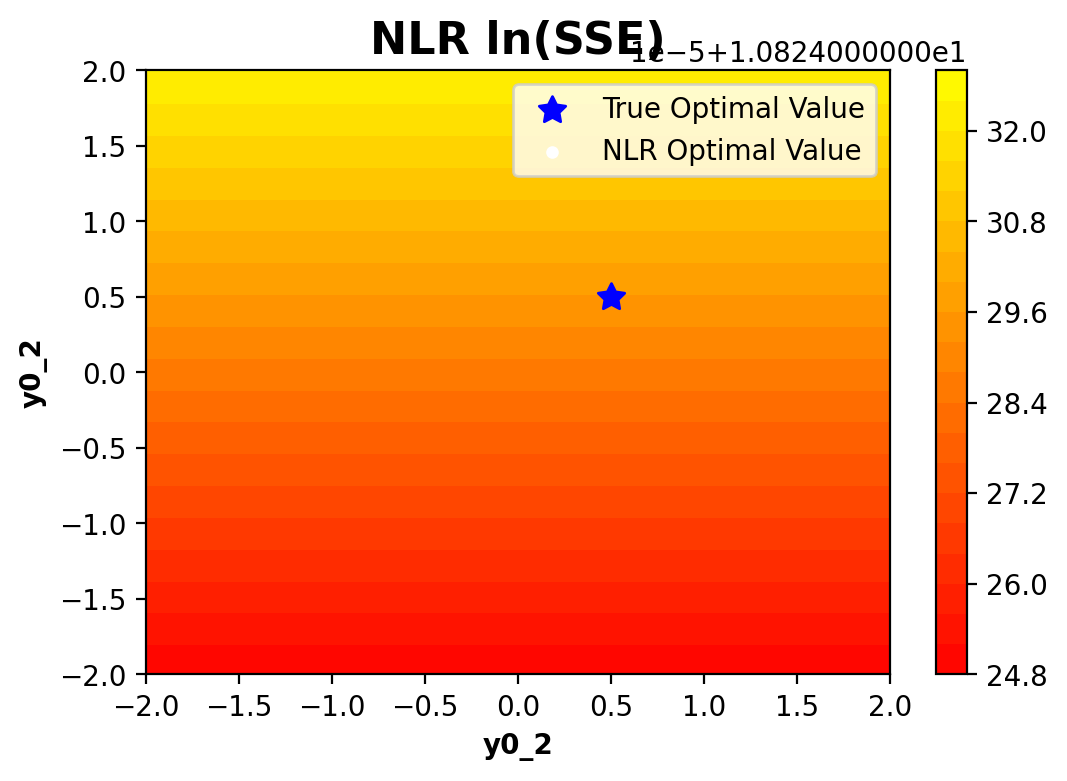

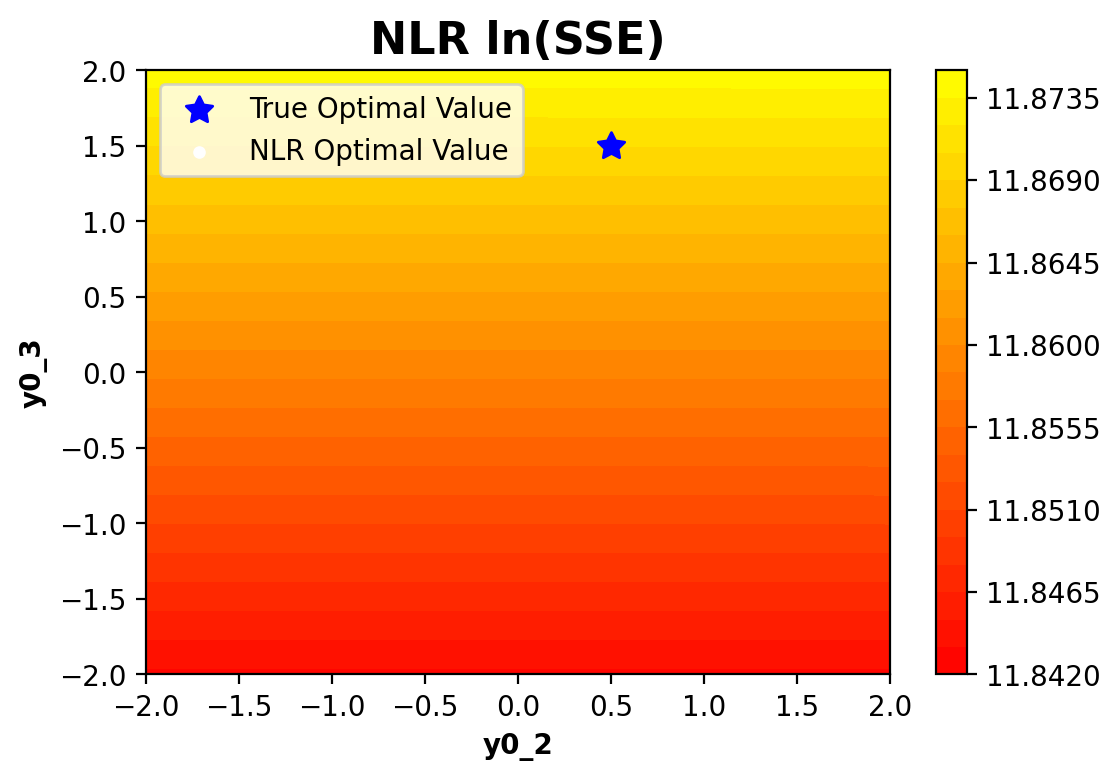

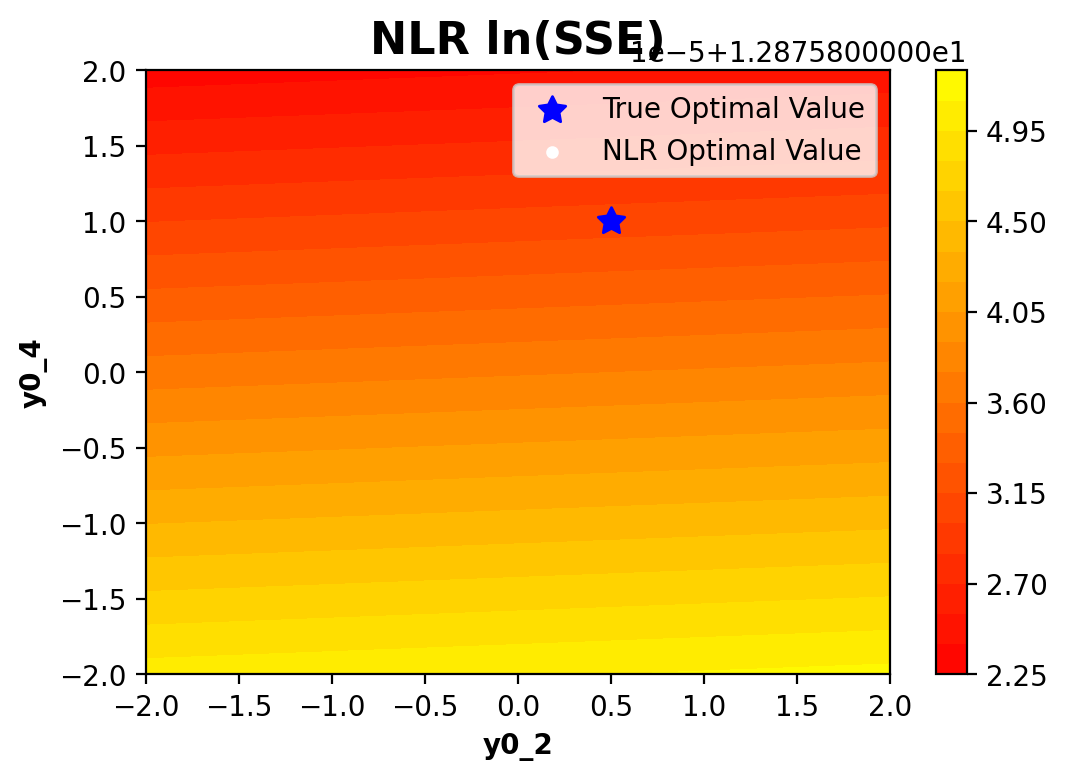

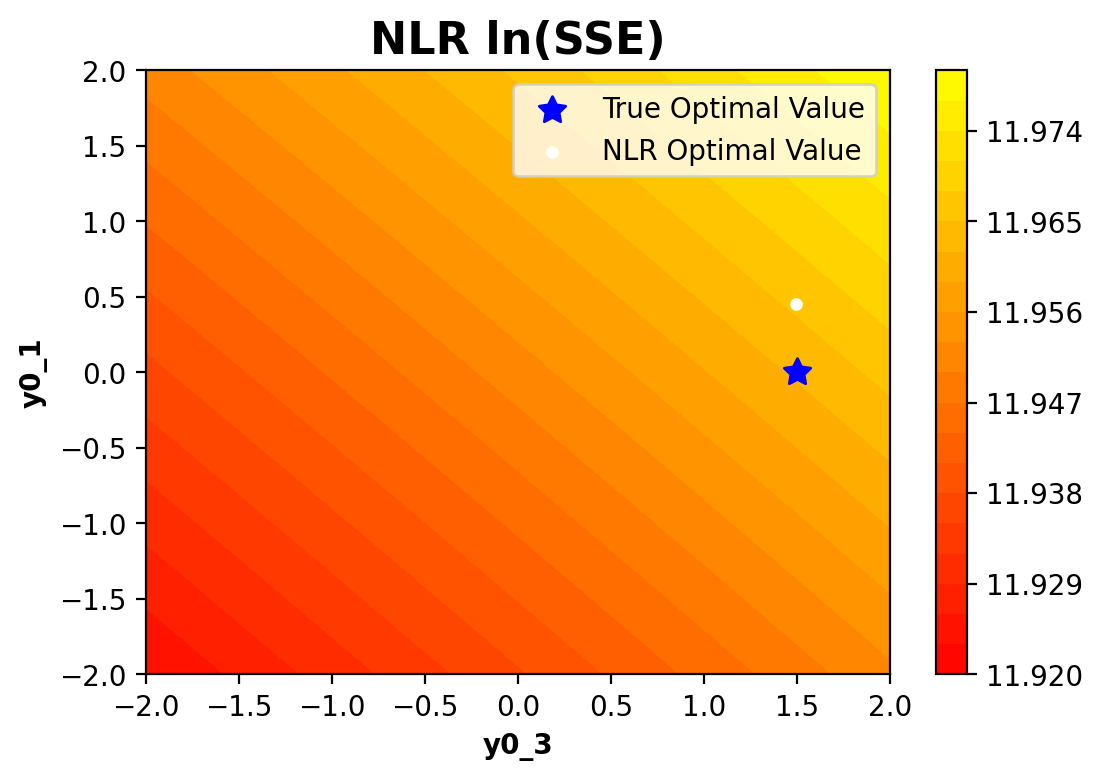

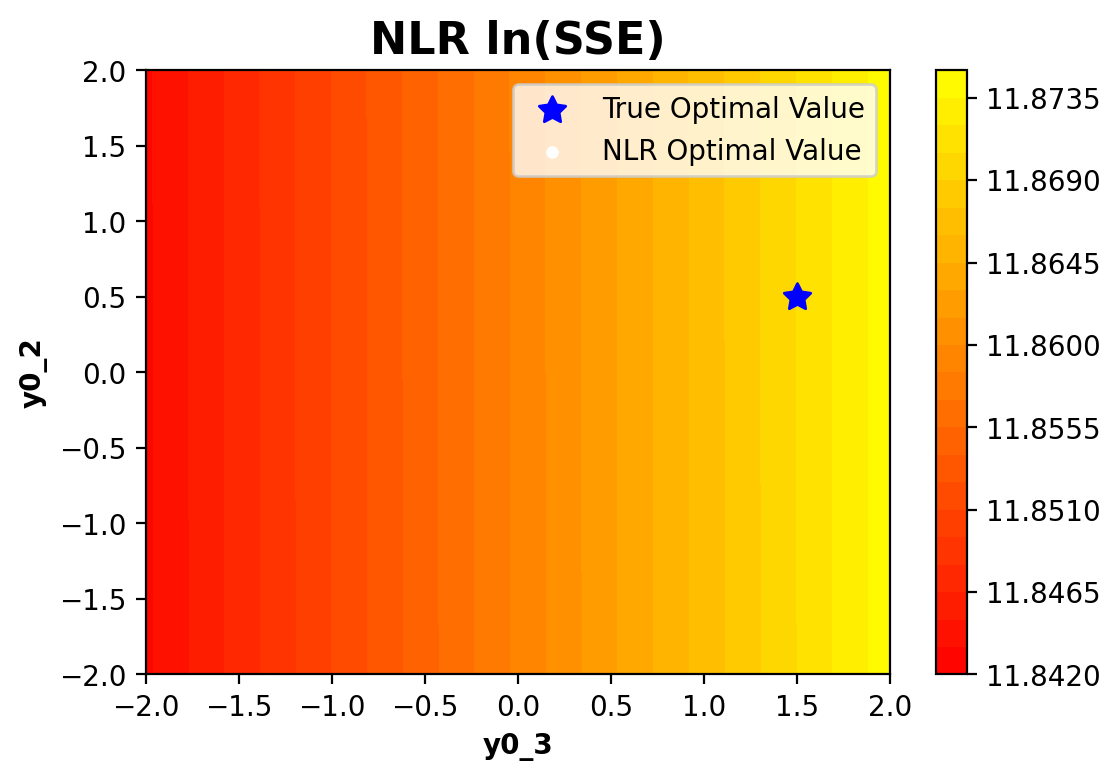

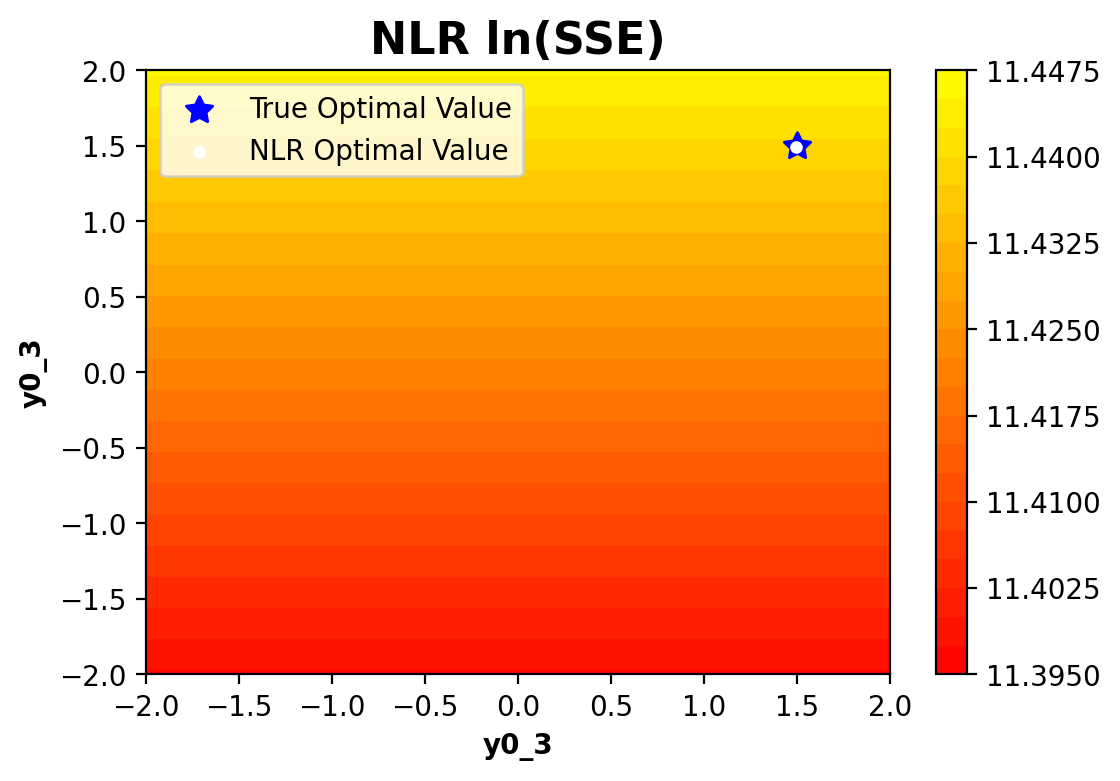

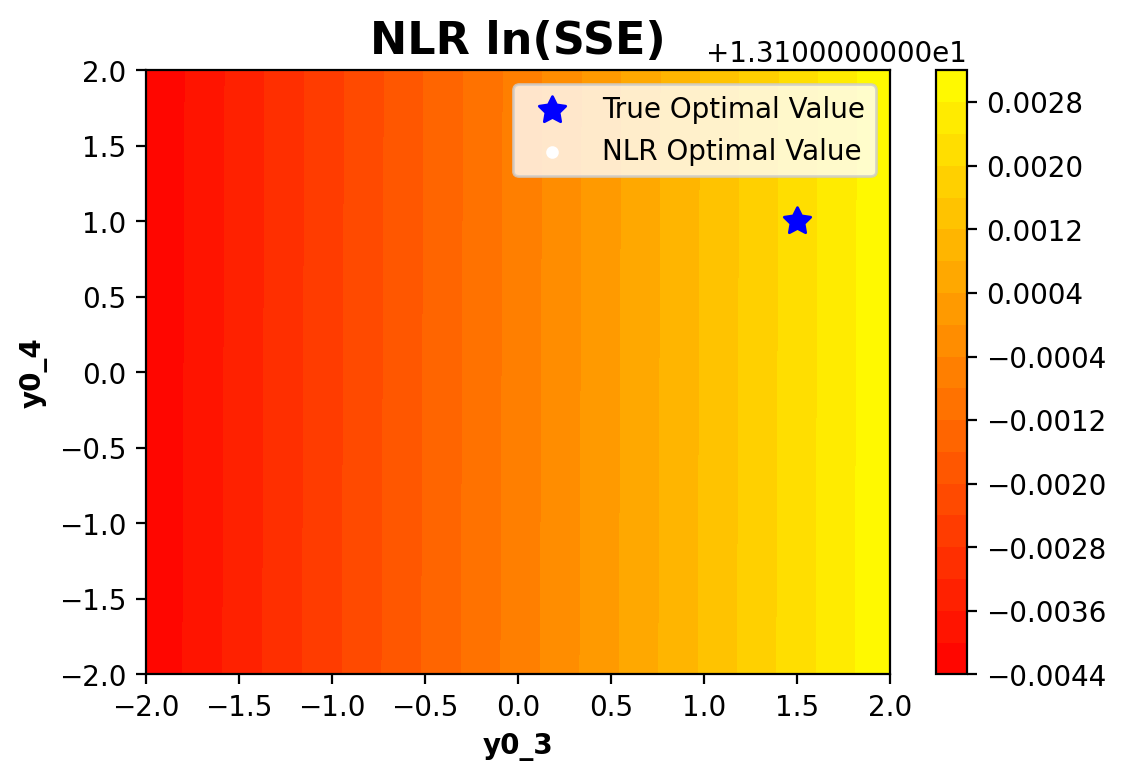

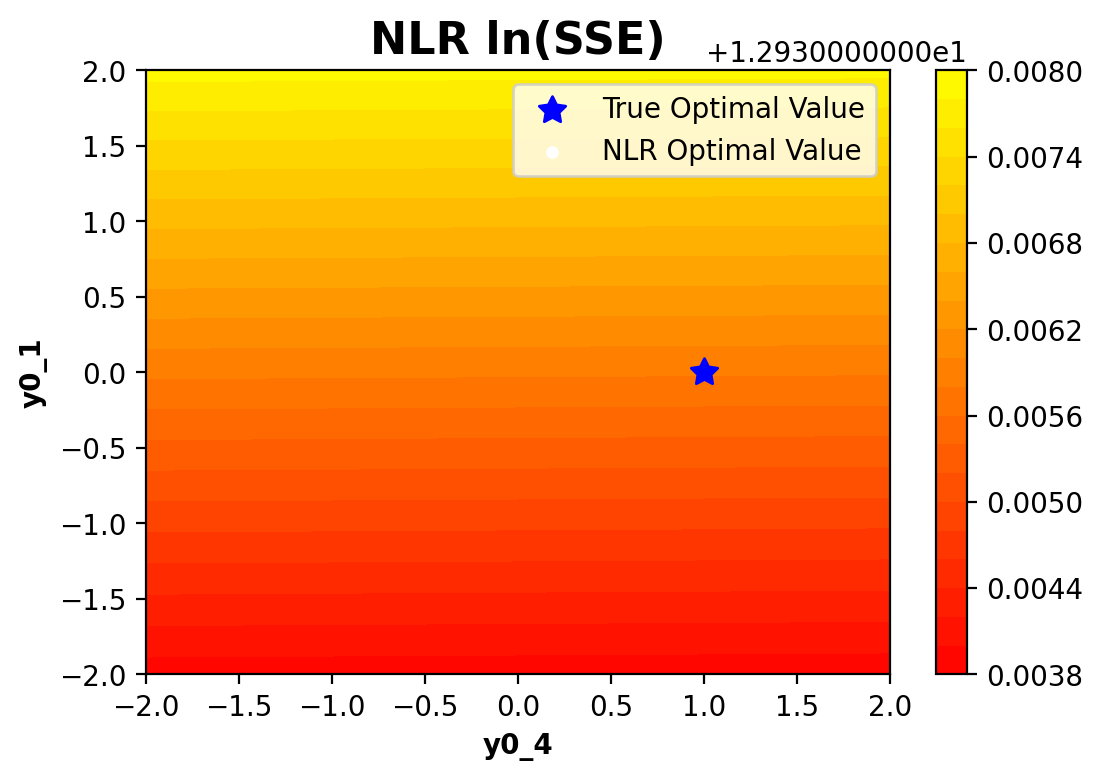

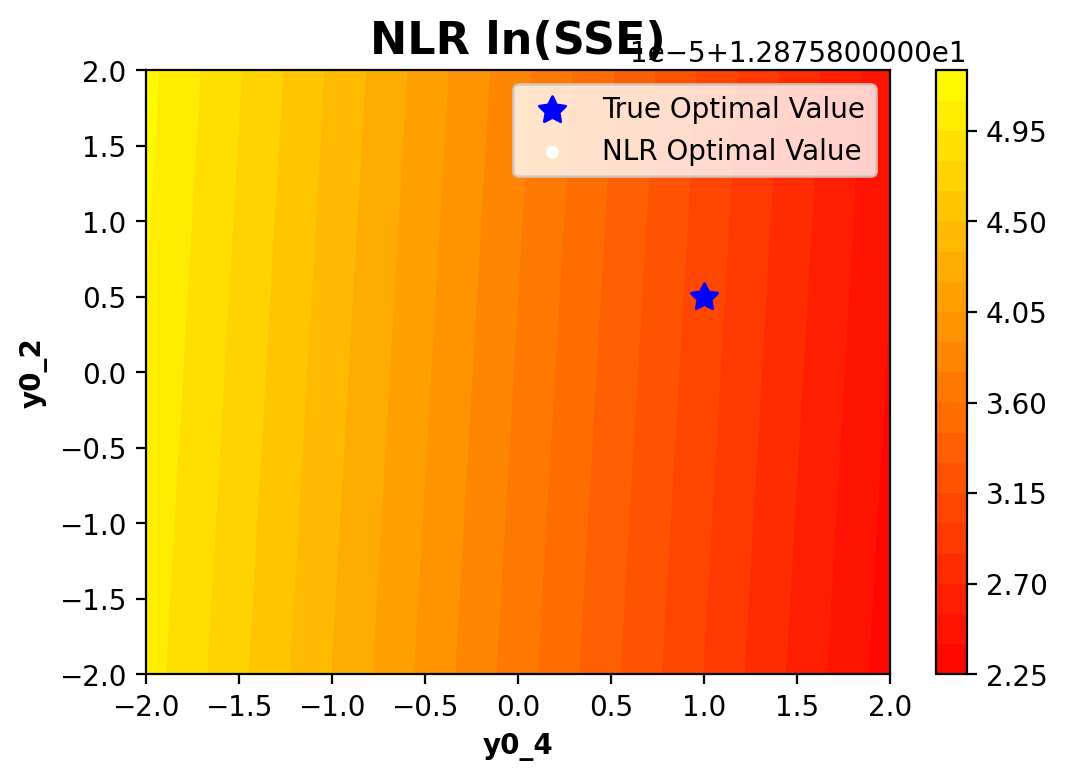

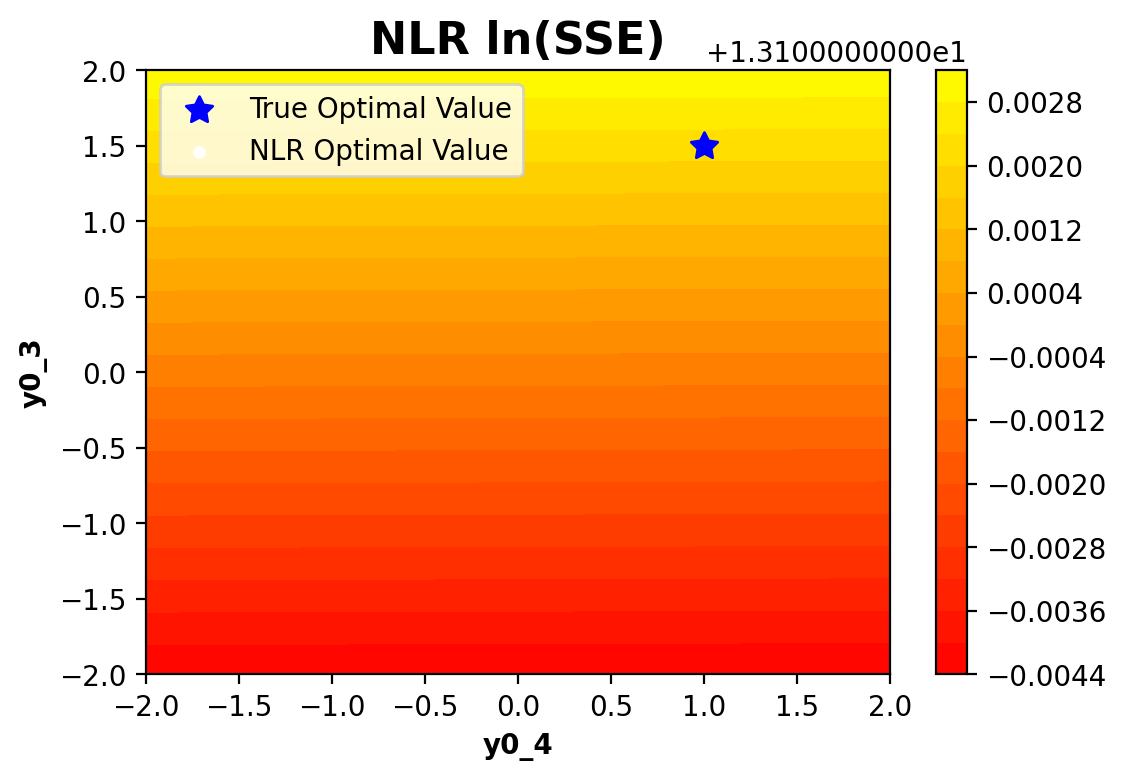

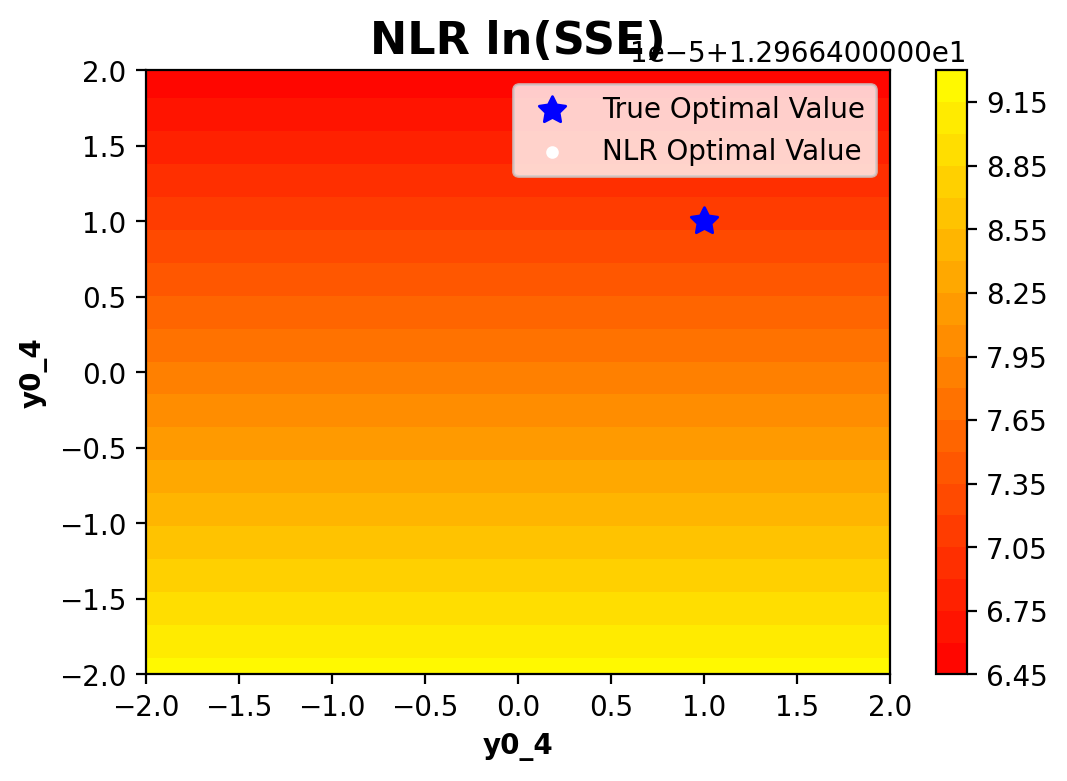

In [8]:
#New Cell
log_plot = True

# generate predictions
X_pred = np.array(X_mesh)
Y_pred = model(a_guess, Constants, X_pred)

#Generate Guesses for a1-a4
a1_lin = a2_lin = np.linspace(-2,0,10)
a3_lin = np.linspace(-10,2,10)
a4_lin = b1_lin = b2_lin = b4_lin = c4_lin = np.linspace(-2,2,10)
A1_lin = A2_lin = A3_lin = np.linspace(-250,50,10)
A4_lin = np.linspace(10,20,10)
b3_lin = np.linspace(8,12,10)
b4_lin = np.linspace(-2,2,10)
c1_lin = np.linspace(-12,-8,10)
c2_lin = np.linspace(-12,-8,10)
c3_lin = np.linspace(-10,-6,10)

x0_1_lin = x0_2_lin = x0_3_lin = x0_4_lin = np.linspace(-2,2,10)
y0_1_lin = y0_2_lin = y0_3_lin = y0_4_lin = np.linspace(-2,2,10)


axis_list = [A1_lin, A2_lin, A3_lin, A4_lin,
             a1_lin, a2_lin, a3_lin, a4_lin, 
             b1_lin, b2_lin, b3_lin, b4_lin, 
             c1_lin, c2_lin, c3_lin, c4_lin,
             x0_1_lin, x0_2_lin, x0_3_lin, x0_4_lin,
             y0_1_lin, y0_2_lin, y0_3_lin, y0_4_lin]

axis_label_list = ["A1", "A2", "A3", "A4",
                   "a1", "a2", "a3", "a4",
                   "b1", "b2", "b3", "b4",
                   "c1", "c2", "c3", "c4",
                   "x0_1", "x0_2", "x0_3", "x0_4",
                   "y0_1", "y0_2", "y0_3", "y0_4",]

#Loop over combinations of axes and create heatmaps
#How to do this with a for loop?
for k in range(num_param_guess):
    for i in range(Constants.shape[1]):
        for j in range(Constants.shape[1]):
            P_inds = np.array([i,j])
            P1_vals = axis_list[P_inds[0]+k*Constants.shape[1]]
            P2_vals = axis_list[P_inds[1]+k*Constants.shape[1]]
            #Use a_guesses to create heat map
            zz = sse_func(a_model, Xexp, Yexp, P_inds, P1_vals, P2_vals)

            if log_plot == True:
                zz = np.log(zz)
            #Better way to do this?
            plt.contourf(P1_vals,P2_vals, zz, cmap = "autumn", levels = 20)
            plt.colorbar()
            plt.axis()
            letter_index = int()
            plt.scatter(Constants[k][P_inds[0]],Constants[k][P_inds[1]], color="blue", s=100, #K +1 if not starting w/ A
                        label = "True Optimal Value", marker = (5,1)) #k +1 since we chose a&b&c
            plt.scatter(a_model_soln[k][P_inds[0]],a_model_soln[k][P_inds[1]], color="white",s=50, marker = ".",
                        label = "NLR Optimal Value")
            # plt.grid()
            plt.legend(loc = 'best')
            plt.xlabel(axis_label_list[P_inds[0]+k*Constants.shape[1]],weight='bold')
            plt.ylabel(axis_label_list[P_inds[1]+k*Constants.shape[1]],weight='bold')
            plt.xlim((np.amin(P1_vals), np.amax(P1_vals)))
            plt.ylim((np.amin(P2_vals),np.amax(P2_vals)))

            if log_plot == True:
                plt.title('NLR ln(SSE)', weight='bold',fontsize = 16)
    #             plt.savefig("Figures/NLR_ln(SSE).png",dpi=300)
            else:
                plt.title('Non-Linear Regression SSE', weight='bold',fontsize = 16)
    #             plt.savefig("Figures/NLR_SSE.png",dpi=300)

            plt.show()

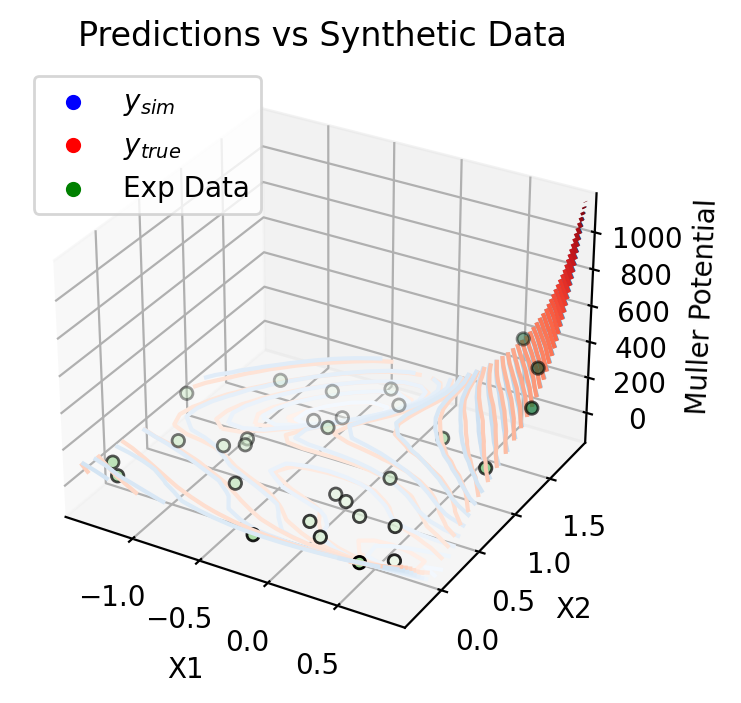

In [9]:
#New Cell
X_pred = np.array(np.meshgrid(x1,x2))
Y_pred = model(a_model, Constants, X_pred) #Not being printed
# print(Y_pred)
# create plot and compare predictions and experiments
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X1, X2, Y_pred, 50, cmap='Blues')
ax.contour3D(X1, X2, Y, 50, cmap='Reds')
ax.scatter3D(Xexp[:,0], Xexp[:,1], Yexp, c=Yexp, cmap='Greens', edgecolors = "k")
ax.scatter(1000,1000,1000, label = "$y_{sim}$", color = 'blue')
ax.scatter(1000,1000,1000, label = "$y_{true}$", color = 'red')
ax.scatter(1000,1000,1000, label = "Exp Data", color = 'green')
ax.legend(loc = "upper left") #Why won't this show all labels?
ax.set_zlim(np.amin(Y),np.amax(Y))
ax.set_xlim(np.amin(X1),np.amax(X1))
ax.set_ylim(np.amin(X2),np.amax(X2))
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Muller Potential');
plt.title("Predictions vs Synthetic Data")
plt.show()

# plt.savefig("Figures/sim_true_comp.png",dpi=300)
# plt.show()

SSE =  155.5980583892793


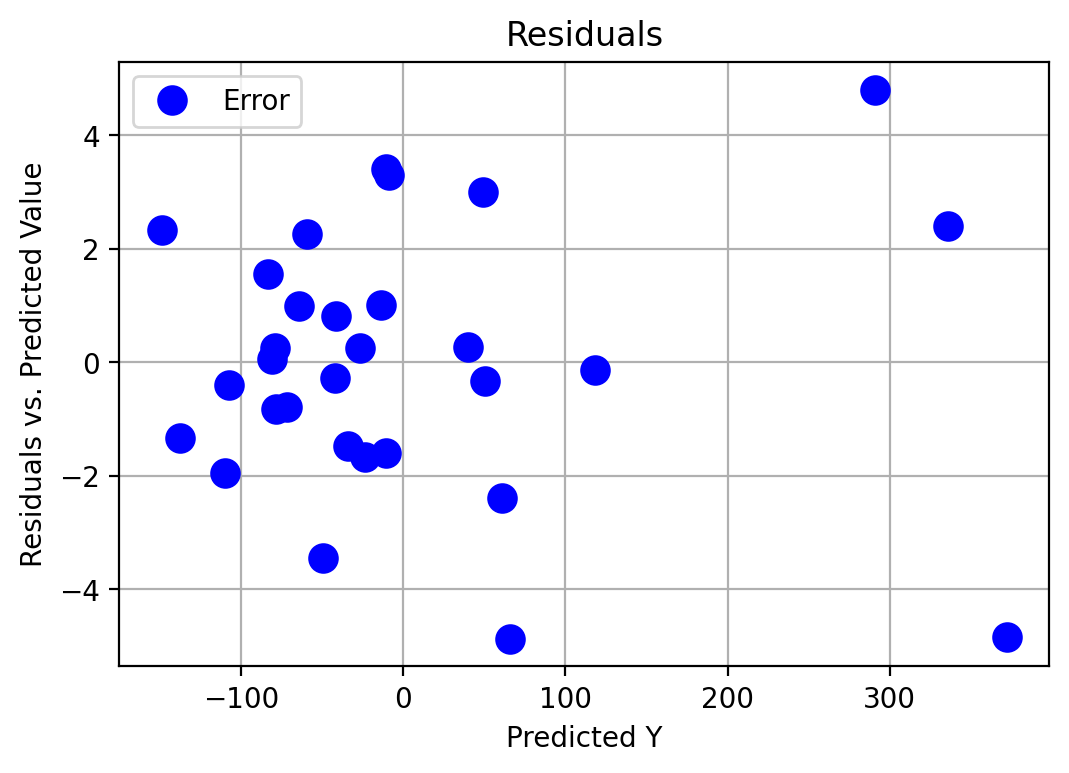

In [10]:
#Plot error
Y_pred_of_exp = model(a_model, Constants, Xexp)
# print(Y_pred_of_exp)
# print(Yexp)
error = (Yexp - Y_pred_of_exp)
print("SSE = ", np.sum(error**2))
plt.plot(Y_pred_of_exp,error,"b.",markersize=20, label = "Error")
plt.title("Residuals")
plt.xlabel('Predicted Y')
plt.ylabel('Residuals vs. Predicted Value')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
#Jacobian and Uncertainty Analysis
print("Jacobian =\n")
print(Solution.jac)
sigre = (error.T @ error)/(len(error) - 2)
Sigma_theta2 = sigre * np.linalg.inv(Solution.jac.T @ Solution.jac)
print("Covariance matrix:\n",Sigma_theta2)

Jacobian =

[[-3.66560886e-07 -0.00000000e+00 -2.21826524e-02 -1.16658545e-03
   7.62939453e-06 -0.00000000e+00  3.83723991e+00 -4.95705484e+04
   3.05175781e-05  0.00000000e+00  1.78944571e+00  4.15964809e+04
   9.53970170e-05 -0.00000000e+00  8.34484176e-01 -3.49052746e+04
   8.01086426e-05  0.00000000e+00  3.70166512e+01  9.77327631e+02
   7.78198242e-04  0.00000000e+00 -2.08432927e+01  7.12047137e+02]
 [-4.43655181e-02 -6.80748256e-12 -6.48133919e-02 -2.30434514e-05
   1.15355587e+01  1.60932541e-04  9.67270548e+00 -1.32518283e+03
  -3.60439038e+00  2.01512555e-05  5.82237062e+00  8.56944970e+02
   1.12622460e+00  2.50682995e-06  3.50470640e+00 -5.54155694e+02
  -1.34990590e+01 -4.49326072e-06 -8.26322365e+01  4.54920053e+00
   2.39935470e+01  1.68528761e-05  3.47879315e+01 -8.73313473e+00]
 [-7.53282621e-05 -0.00000000e+00 -8.57160685e-01 -1.08452933e-04
   8.75473022e-04 -0.00000000e+00  8.05610300e+00 -5.22643481e+03
  -3.45230103e-03  0.00000000e+00  7.23731351e+00  4.01143447e

Covariance matrix:
 [[ 2.38417677e+01  2.02963259e+07 -3.66320431e+00  2.37134970e+07
  -3.12198214e-01 -7.28150444e-01  1.43174376e+00  3.87486980e-01
   2.86613859e-01 -1.21253460e+00 -2.02066947e+00 -3.54307558e-01
  -3.00763284e+00 -3.11415063e+00  1.57216742e+00 -1.55613642e-01
  -2.11520387e-01 -3.94503984e+02  5.00999666e-03  1.18536794e+02
   7.92000330e-02 -8.81210370e+01 -4.82940362e-03 -8.38082779e+01]
 [ 2.02963241e+07  5.65633199e+13 -1.45384894e+07  2.66538197e+13
  -1.88260041e+05 -2.74294446e+06  1.40363062e+06  4.48288332e+05
  -7.25540461e+05  1.13330369e+06 -1.63597742e+06 -7.32038946e+05
  -7.69388614e+05 -1.34044107e+07  1.18102410e+06 -5.74293104e+05
  -9.61031801e+04 -1.09094415e+09  3.23409080e+04  1.38422073e+08
   1.47043304e+04 -2.42044160e+08  3.81495941e+04 -1.00510500e+08]
 [-3.66320404e+00 -1.45384899e+07  1.12397582e+01 -1.11524303e+07
  -1.05610845e-01  6.63833850e-01 -4.78769115e-01 -1.88573806e-01
   4.50118754e-01 -4.71266272e-01  6.51879037e-01  2.8

In [12]:
import scipy.linalg as linalg
val, vec = linalg.eig(Sigma_theta2)
print(val)
print(vec)

[8.15779302e+13+0.j 2.81628683e+13+0.j 1.44192368e+01+0.j
 6.66945520e+00+0.j 2.77098138e+00+0.j 1.80405689e+00+0.j
 8.47412958e-01+0.j 3.55546236e-01+0.j 1.80033035e-01+0.j
 9.11680257e-02+0.j 5.92585535e-02+0.j 2.73372492e-02+0.j
 1.45663272e-02+0.j 5.71145610e-03+0.j 3.26294565e-03+0.j
 1.79225257e-04+0.j 1.22173372e-04+0.j 1.10578613e-04+0.j
 4.27262017e-05+0.j 8.97935976e-06+0.j 8.35457837e-06+0.j
 1.09320360e-07+0.j 3.63198130e-09+0.j 3.07198298e-10+0.j]
[[ 3.80340305e-07 -1.20793231e-07  8.32075501e-01  4.88286801e-01
   5.95181159e-02  7.53090292e-02  1.82407184e-01 -1.52009923e-01
  -2.52491078e-02  1.44115340e-02  2.68387462e-02 -3.78005911e-02
  -1.68484263e-02 -1.74599798e-02  5.31630676e-03 -2.45137913e-03
   3.46580845e-03  9.56066743e-04 -1.19142208e-03  5.42200340e-04
  -1.02688036e-03 -6.95484966e-05  1.51094244e-05 -3.66607811e-06]
 [ 7.29173265e-01  6.84329059e-01 -1.44295624e-07 -5.54176946e-06
   8.09041757e-06 -3.31703352e-06  1.48976878e-05  3.19036369e-06
  -6.6